In [1]:
# Mount Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)
project_path= '/content/drive/MyDrive/P10- RAG-GAS/'
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv('data_eng.csv')

In [ ]:
text = data['Summary']

In [ ]:
from sentence_transformers import SentenceTransformer
encoder_name = 'bert-base-nli-mean-tokens'
encoder = SentenceTransformer(encoder_name, trust_remote_code=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Split stratificato 80-20
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    stratify=data['Successful'],
    random_state=42
)

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")


Train size: 9523
Test size: 2381


In [ ]:
# Encoding dei testi
import numpy as np
X_train = encoder.encode(train_data['Summary'].tolist(), show_progress_bar=True)
X_test = encoder.encode(test_data['Summary'].tolist(), show_progress_bar=True)

y_train = np.array(train_data['Successful'].tolist())
y_test = np.array(test_data['Successful'].tolist())

Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create the table
df_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance (%)': explained_variance * 100,
    'Cumulative Variance (%)': cumulative_variance * 100
})

df_variance


Component  Explained Variance (%)  Cumulative Variance (%)
0       PC1               39.112034                39.112034
1       PC2               11.383082                50.495117
2       PC3                7.943926                58.439045

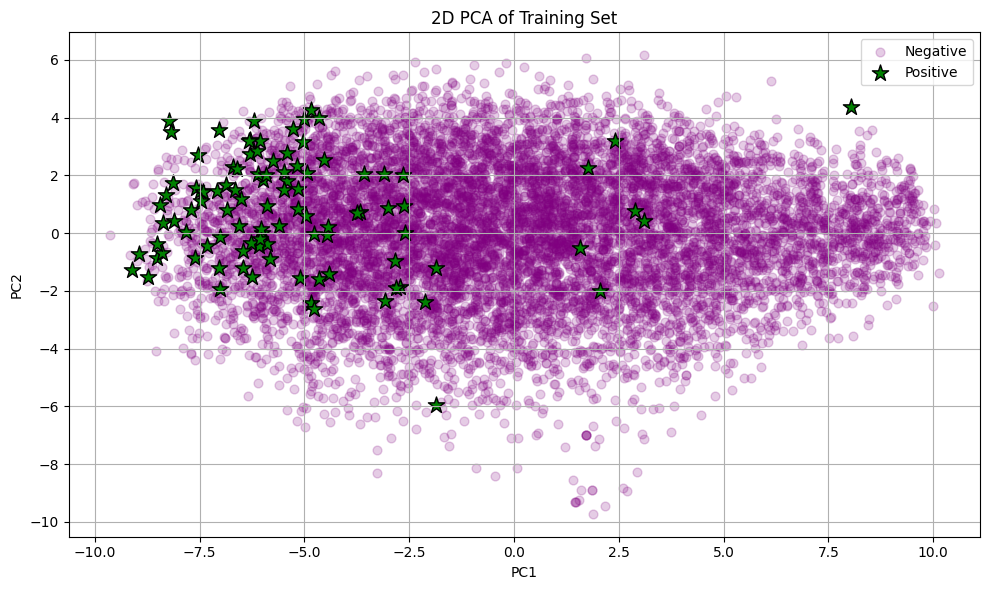

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter 2D
#(-)
plt.scatter(X_train_pca[y_train == False, 0], X_train_pca[y_train == False, 1],
            color='purple', marker='o', s=40, alpha=0.2, label='Negative')

#(+)
plt.scatter(X_train_pca[y_train == True, 0], X_train_pca[y_train == True, 1],
            color='green', marker='*', s=150, edgecolor='black', label='Positive')

plt.title("2D PCA of Training Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

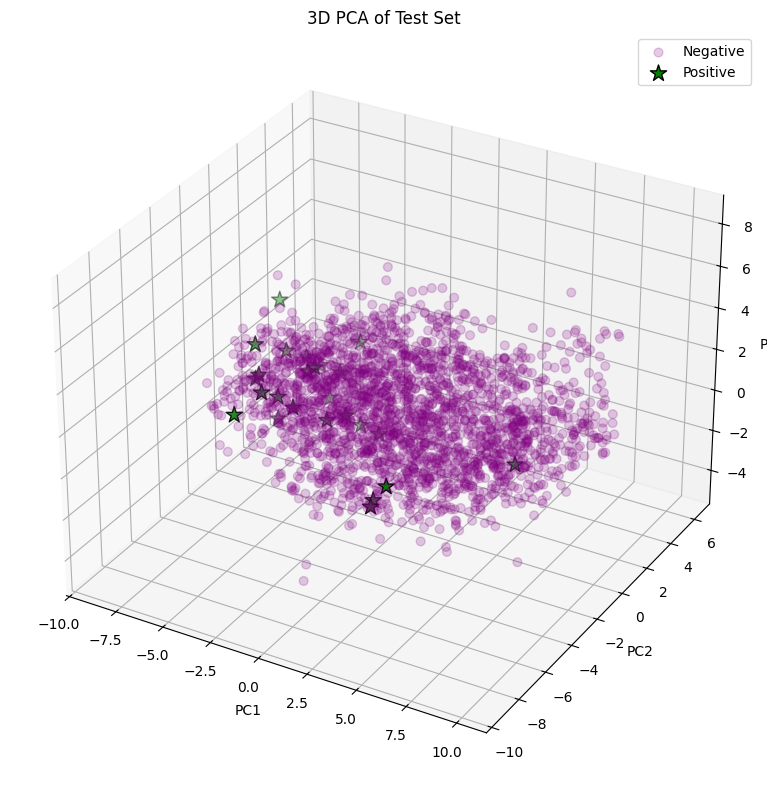

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(X_test_pca[y_test == False, 0], X_test_pca[y_test == False, 1], X_test_pca[y_test == False, 2],
           color='purple', marker='o', s=40, alpha=0.2, label='Negative')

ax.scatter(X_test_pca[y_test == True, 0], X_test_pca[y_test == True, 1], X_test_pca[y_test == True, 2],
           color='green', marker='*', s=150, edgecolor='black', label='Positive')

ax.set_title("3D PCA of Test Set")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()

## Interactive Graphics

In [ ]:
! pip install plotly

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

# Negativi
fig.add_trace(go.Scatter(
    x=X_train_pca[y_train == False, 0],
    y=X_train_pca[y_train == False, 1],
    mode='markers',
    name='Negative',
    marker=dict(
        symbol='circle',
        color='purple',
        size=5,
        opacity=0.2
    ),
    hoverinfo='skip'
))

# Positivi
fig.add_trace(go.Scatter(
    x=X_train_pca[y_train == True, 0],
    y=X_train_pca[y_train == True, 1],
    mode='markers',
    name='Positive',
    marker=dict(
        symbol='star',
        color='green',
        size=15,
        line=dict(color='black', width=1),
        opacity=1.0
    ),
    hoverinfo='skip'
))

fig.update_layout(
    title="2D PCA of Training Set (Selective Transparency)",
    xaxis_title="PC1",
    yaxis_title="PC2",
    legend=dict(itemsizing='constant'),
    width=800,
    height=600
)

fig.show()


# Probability Density Functions $f_{+}(\vec{x})$,$f_{-}(\vec{x})$, $f(\vec{x})$

We try to estimate the probability density function of positive points within the PCA plan.

As can be seen in previous chapters, reducing by PCA, it's evident that there is a region of the graph having high concentration of positives, while negatives seems to be (bivariate) normally distributed.



In [ ]:
from scipy.stats import norm, multivariate_normal
def fit_marginal_normal(data):
    mu, sigma = norm.fit(data)
    return mu, sigma

def fit_multivariate_normal(data):
    mu = np.mean(data, axis=0)
    cov = np.cov(data.T)
    return mu, cov

In [ ]:
def plot_distribution(data, mu, sigma, title, xlabel):

    # Real Distribution
    count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.6, color='black',
                               edgecolor='black')

    # Valori continui per la PDF teorica
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf = norm.pdf(x_vals, loc=mu, scale=sigma)

    # Plot della distribuzione teorica
    plt.plot(x_vals, pdf, 'r--', label=f'N({mu:.2f}, {sigma:.2f})')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f'$f_-({xlabel})$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pdf


In [ ]:
def plot_bivariate_heatmap(mu, cov, data, title, show_points=True):
    """
    Heatmap della distribuzione normale bivariata stimata, con opzione per mostrare o nascondere i punti.

    :param mu: array-like, media della distribuzione (2 elementi)
    :param cov: array-like, matrice di covarianza 2x2
    :param data: numpy array di shape (n_samples, 2)
    :param title: str, titolo del grafico
    :param show_points: bool, se True mostra i punti scatter
    """
    x, y = np.mgrid[
        min(data[:, 0]):max(data[:, 0]):100j,
        min(data[:, 1]):max(data[:, 1]):100j
    ]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean=mu, cov=cov)
    z = rv.pdf(pos)

    plt.figure(figsize=(6, 5))
    contour = plt.contourf(x, y, z, levels=50, cmap='viridis')

    if show_points:
        plt.scatter(data[:, 0], data[:, 1],
                    alpha=0.4, s=10, color='white', edgecolor='black', linewidth=0.5)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(contour, label='Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_bivariate_3d(mu, cov, data, title):
    """
    Plot 3D superficie della PDF stimata.
    """
    x, y = np.mgrid[
        min(data[:, 0]):max(data[:, 0]):100j,
        min(data[:, 1]):max(data[:, 1]):100j
    ]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean=mu, cov=cov)
    z = rv.pdf(pos)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("f")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_dual_bivariate_heatmap(
    data_neg, data_pos,
    mu_neg, cov_neg,
    mu_pos, cov_pos,
    title="Bivariate (+) vs (-)",
    show_points=True
):
    plt.style.use('default')
    plt.figure(figsize=(6, 5))

    # Griglia combinata
    x_min = min(data_neg[:, 0].min(), data_pos[:, 0].min())
    x_max = max(data_neg[:, 0].max(), data_pos[:, 0].max())
    y_min = min(data_neg[:, 1].min(), data_pos[:, 1].min())
    y_max = max(data_neg[:, 1].max(), data_pos[:, 1].max())

    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    pos = np.dstack((x, y))

    # Distribuzioni
    rv_neg = multivariate_normal(mean=mu_neg, cov=cov_neg)
    rv_pos = multivariate_normal(mean=mu_pos, cov=cov_pos)
    z_neg = rv_neg.pdf(pos)
    z_pos = rv_pos.pdf(pos)

    # Livelli comuni
    max_density = max(z_neg.max(), z_pos.max())
    levels = np.linspace(0, max_density, 20)

    # Contourf trasparenti
    plt.contourf(x, y, z_neg, levels=levels, cmap='Purples', alpha=0.4, zorder=1)
    plt.contourf(x, y, z_pos, levels=levels, cmap='Greens', alpha=0.4, zorder=2)

    # Punti reali (opzionali)
    if show_points:
        plt.scatter(data_pos[:, 0], data_pos[:, 1], color='gray', s=30, marker='*', edgecolor='black', label='(+)', zorder=4)
        plt.scatter(data_neg[:, 0], data_neg[:, 1], color='gray', s=10, alpha=0.3, label='(-)', zorder=3)

    # Etichette e layout
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_dual_bivariate_surface(
    data_neg, data_pos,
    mu_neg, cov_neg,
    mu_pos, cov_pos,
    title="Bivariate Density Curves (+) vs (-)"
):
    plt.style.use('default')
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Griglia combinata
    x_min = min(data_neg[:, 0].min(), data_pos[:, 0].min())
    x_max = max(data_neg[:, 0].max(), data_pos[:, 0].max())
    y_min = min(data_neg[:, 1].min(), data_pos[:, 1].min())
    y_max = max(data_neg[:, 1].max(), data_pos[:, 1].max())

    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    pos = np.dstack((x, y))

    # Distribuzioni
    rv_neg = multivariate_normal(mean=mu_neg, cov=cov_neg)
    rv_pos = multivariate_normal(mean=mu_pos, cov=cov_pos)
    z_neg = rv_neg.pdf(pos)
    z_pos = rv_pos.pdf(pos)

    # Curve wireframe
    ax.plot_wireframe(x, y, z_neg, rstride=5, cstride=5, color='purple', label='(-)', alpha=0.7)
    ax.plot_wireframe(x, y, z_pos, rstride=5, cstride=5, color='green', label='(+)', alpha=0.7)

    # Etichette
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Densità")
    ax.set_title(title)
    ax.view_init(elev=30, azim=135)

    # Legenda 3D "finta" usando linee
    red_line = plt.Line2D([0], [0], linestyle="none", marker='s', color='purple', label='(-)')
    green_line = plt.Line2D([0], [0], linestyle="none", marker='s', color='green', label='(+)')
    ax.legend(handles=[red_line, green_line], loc='upper left')

    plt.tight_layout()
    plt.show()

## $f_{-}(\vec{x})$

L'assunzione di normalità sembra essere confermata dai grafici: i punti negativi possono essere considerati distribuiti normalmente sul piano individuato dalla PCA.

Questo, per noi, significa modellare i (-) come rumore gaussiano.

In [ ]:
train_negatives = X_train_pca[np.array(y_train) == False]
mu_neg, varcov_neg = fit_multivariate_normal(train_negatives)

In [ ]:
mu_neg

array([ 0.05605463, -0.0083128 ,  0.01174863], dtype=float32)

In [ ]:
varcov_neg

array([[ 1.73373996e+01,  4.49516815e-02, -5.80943603e-02],
       [ 4.49516815e-02,  5.11364048e+00,  3.95489256e-03],
       [-5.80943603e-02,  3.95489256e-03,  3.56301685e+00]])

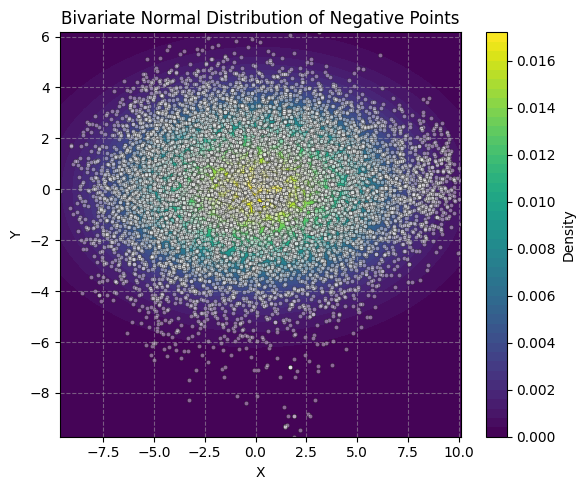

In [ ]:
# We do only consider x,y
plot_bivariate_heatmap(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "Bivariate Normal Distribution of Negative Points",show_points = True)

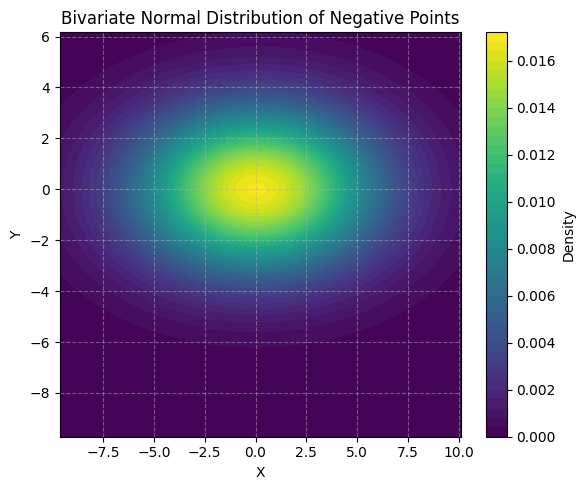

In [ ]:
# We do only consider x,y
plot_bivariate_heatmap(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "Bivariate Normal Distribution of Negative Points",show_points = False)

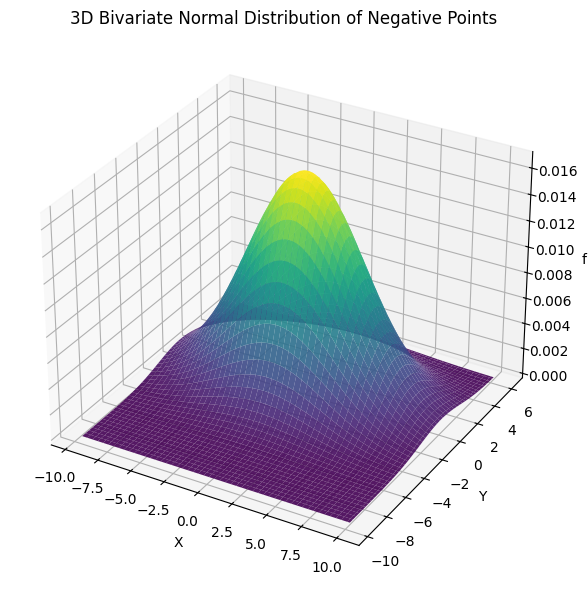

In [ ]:
plot_bivariate_3d(mu_neg[:2], varcov_neg[:2, :2], train_negatives, "3D Bivariate Normal Distribution of Negative Points")

### Marginal of x $f_{-}(x)$

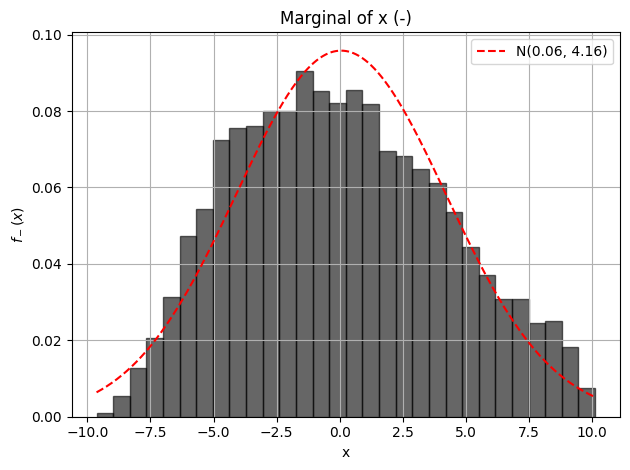

In [ ]:
# Plot
pdf_neg_x = plot_distribution(train_negatives[:, 0], mu_neg[0], np.sqrt(varcov_neg[0][0]), "Marginal of x (-)", "x")

### Marginal of y $f_{-}(y)$

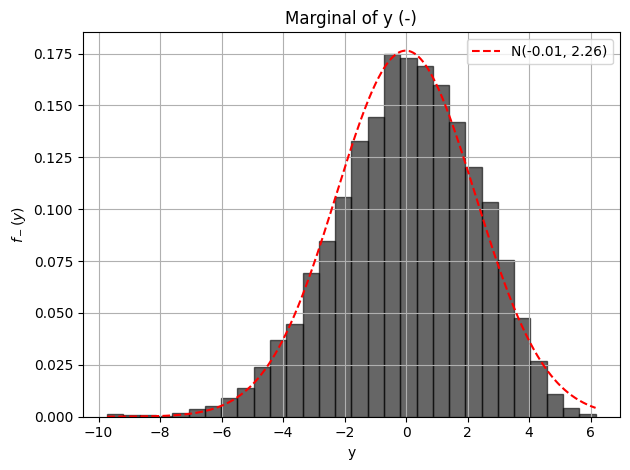

In [ ]:
# Plot
pdf_neg_y = plot_distribution(train_negatives[:, 1], mu_neg[1], np.sqrt(varcov_neg[1][1]), "Marginal of y (-)", "y")

### Marginal of z $f_{-}(z)$

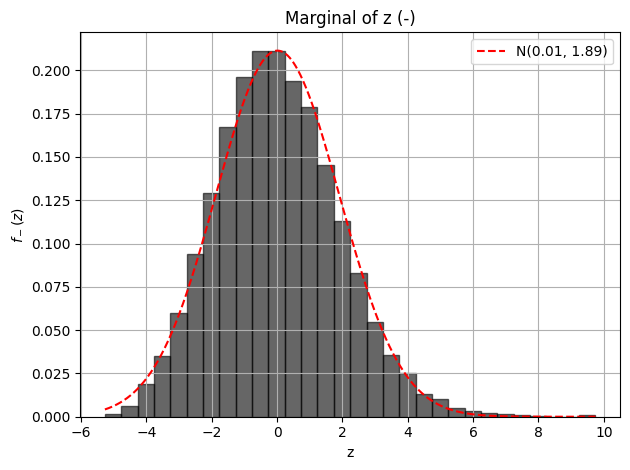

In [ ]:
# Plot
pdf_neg_z = plot_distribution(train_negatives[:, 2], mu_neg[2], np.sqrt(varcov_neg[2][2]), "Marginal of z (-)", "z")

## $f_+(\vec{x}) $
L'assuzione di normalità sembra essere ok ma leggermente meno robusta:
- x non sembra seguirla
- y e z invece si, e bene.

In [ ]:
train_positives = X_train_pca[y_train == True]
mu_pos, varcov_pos = fit_multivariate_normal(train_positives)

In [ ]:
mu_pos

array([-5.2293286 ,  0.77554774, -1.0960758 ], dtype=float32)

In [ ]:
varcov_pos

array([[ 8.4777925 , -0.0945894 , -0.37831943],
       [-0.0945894 ,  3.59029834,  0.49536372],
       [-0.37831943,  0.49536372,  2.23935728]])

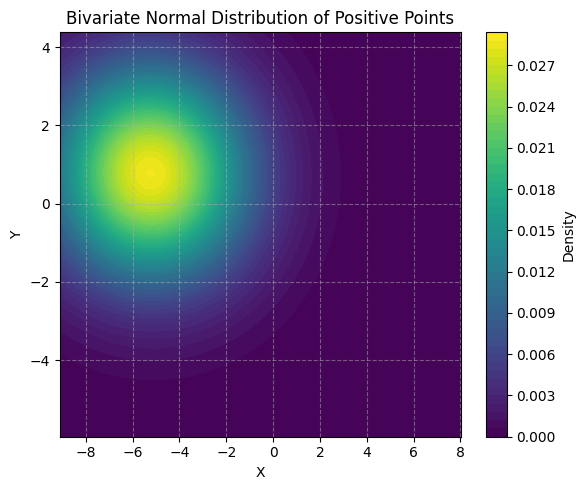

In [ ]:
# We do only consider x,y
plot_bivariate_heatmap(mu_pos[:2], varcov_pos[:2, :2], train_positives, "Bivariate Normal Distribution of Positive Points",show_points = False)

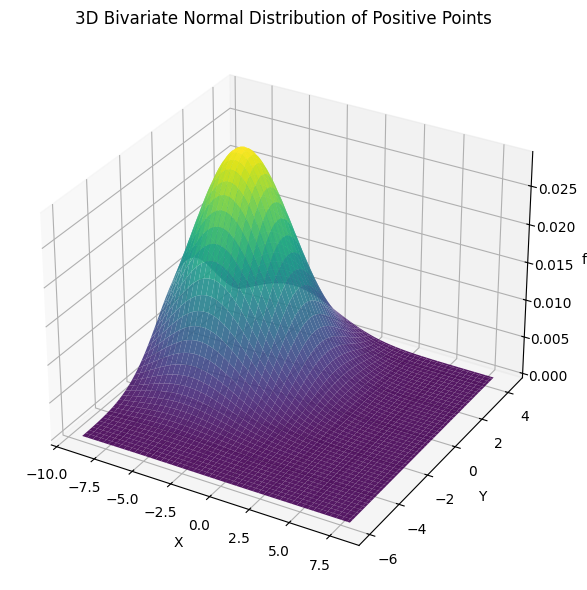

In [ ]:
plot_bivariate_3d(mu_pos[:2], varcov_pos[:2, :2], train_positives, "3D Bivariate Normal Distribution of Positive Points")

### Marginal of x $f_+(x)$

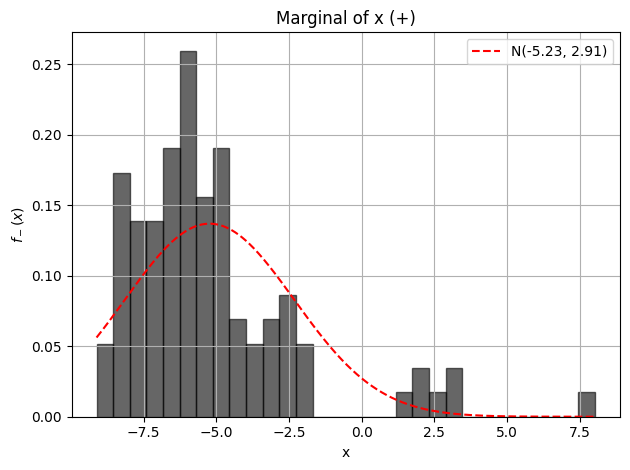

In [ ]:
pdf_pos_x = plot_distribution(train_positives[:, 0], mu_pos[0], np.sqrt(varcov_pos[0][0]), "Marginal of x (+)", "x")

### Marginal of y $f_+(y)$

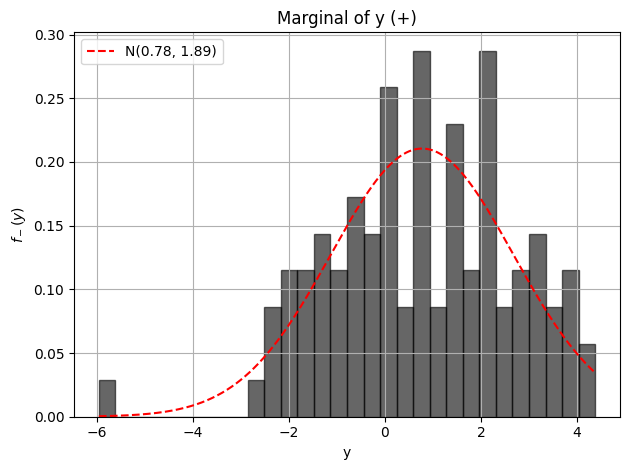

In [ ]:
pdf_pos_z = plot_distribution(train_positives[:, 1], mu_pos[1], np.sqrt(varcov_pos[1][1]), "Marginal of y (+)", "y")

### Marginal of z $f_+(z)$

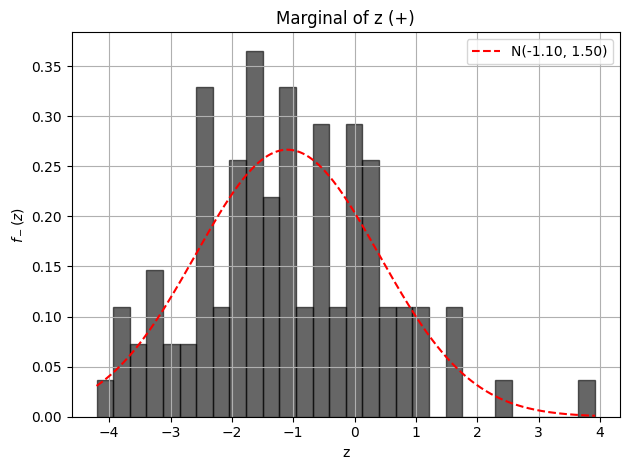

In [ ]:
pdf_pos_z = plot_distribution(train_positives[:, 2], mu_pos[2], np.sqrt(varcov_pos[2][2]), "Marginal of z (+)", "z")

## $f_+$ vs $f_-$

<ipython-input-85-f35526ff0738>:43: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



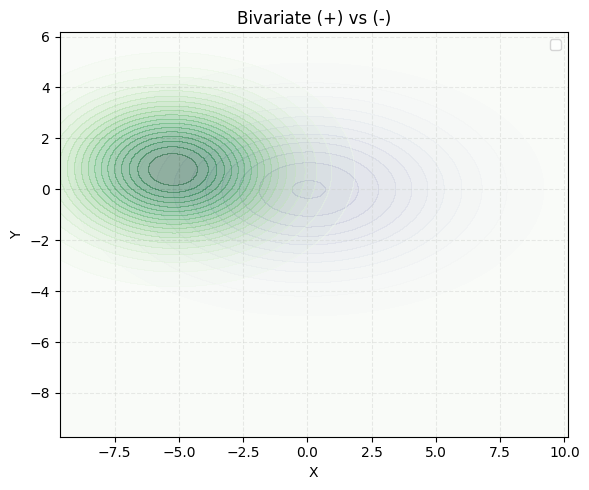

In [ ]:
plot_dual_bivariate_heatmap(train_negatives[:,:2], train_positives[:,:2], mu_neg[:2], varcov_neg[:2,:2], mu_pos[:2], varcov_pos[:2,:2], show_points=False)

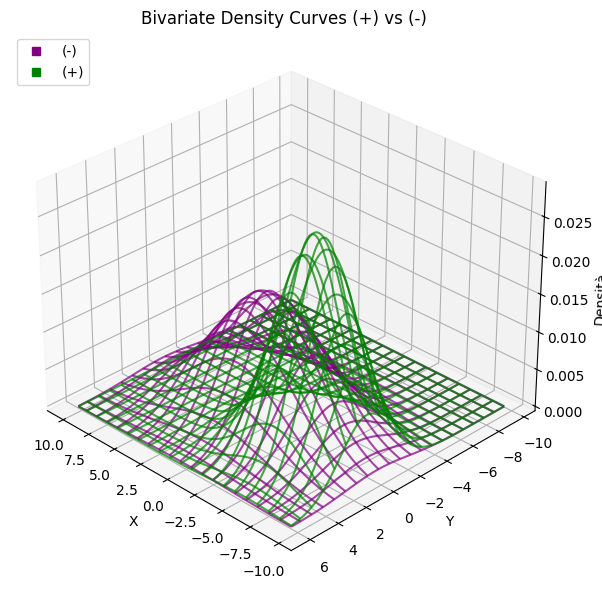

In [ ]:
plot_dual_bivariate_surface(train_negatives[:,:2], train_positives[:,:2], mu_neg[:2], varcov_neg[:2,:2], mu_pos[:2], varcov_pos[:2,:2])

# Bayesian Classifier

In [ ]:
def bayes_classifier(X, mu_pos, cov_pos, mu_neg, cov_neg, prior_pos=0.5, prior_neg=0.5):

    # p(x|C+): density of x if generated through C+
    p_x_given_pos = multivariate_normal.pdf(X, mean=mu_pos, cov=cov_pos)

    # p(x|C-): density of x if generated through C-
    p_x_given_neg = multivariate_normal.pdf(X, mean=mu_neg, cov=cov_neg)

    # BAYES P(C+|x) = p(x|C+)P(C+)/p(x) probability of x to belogn to C+
    posterior_pos = p_x_given_pos * prior_pos

    # BAYES P(C-|x) = p(x|C-)p(C-) probability of x to belong to C-
    posterior_neg = p_x_given_neg * prior_neg

    # P(C-|x) + P(C+|x) = 1
    # p(x) = p(x|C+)p(C+) + p(x|C-)P(C-)

    y_pred = posterior_pos > posterior_neg
    return y_pred.astype(int), posterior_pos / (posterior_pos + posterior_neg)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal

def evaluate_bayesian_classifier(
    X_test_pca,
    y_test,
    mu_pos, cov_pos,
    mu_neg, cov_neg,
    prior_pos=0.5,
    prior_neg=0.5,
    use_dims=2  # numero di componenti PCA da usare (default: 2)
):
    # Taglia i dati alle dimensioni richieste
    X_sub = X_test_pca[:, :use_dims]
    mu_pos_sub = mu_pos[:use_dims]
    mu_neg_sub = mu_neg[:use_dims]
    cov_pos_sub = cov_pos[:use_dims, :use_dims]
    cov_neg_sub = cov_neg[:use_dims, :use_dims]

    # Classificazione bayesiana
    p_x_given_pos = multivariate_normal.pdf(X_sub, mean=mu_pos_sub, cov=cov_pos_sub)
    p_x_given_neg = multivariate_normal.pdf(X_sub, mean=mu_neg_sub, cov=cov_neg_sub)

    posterior_pos = p_x_given_pos * prior_pos
    posterior_neg = p_x_given_neg * prior_neg

    y_pred = (posterior_pos > posterior_neg).astype(int)
    posterior_probs = posterior_pos / (posterior_pos + posterior_neg)

    # Costruzione DataFrame dei risultati
    df_results = pd.DataFrame({
        'PC1': X_test_pca[:, 0],
        'PC2': X_test_pca[:, 1],
        'PC3': X_test_pca[:, 2],
        'y_true': y_test.astype(int),
        'y_pred': y_pred,
        'P(C+|x)': posterior_probs
    })

    # Confusion Matrix
    cm = confusion_matrix(df_results['y_true'], df_results['y_pred'])
    cm_df = pd.DataFrame(cm, index=['-', '+'], columns=['-', '+'])

    return df_results, cm_df


In [ ]:
# L'assunzione giusta secondo me è questa: un punto può essere ( a priori) egualmente positivo o negativo
# Il fatto che abbiamo più negativi è un problema simile a quello del survivorship bias.
p_pos = 50; p_neg=50
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=2)
cfm

-    +
-  1659  697
+     4   21

In [ ]:
# Il problema che abbiamo è esattamente questo: abbiamo raccolto male. Troppi -, Pochissimi +! Altrimenti, il limite è della tecnologia (non funziona la patch)
p_pos = (y_train==True).sum() / y_train.shape[0]; p_neg= 1 - p_pos
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=2)
cfm

-  +
-  2356  0
+    25  0

In [ ]:
# Aggiungere una dimensione migliora le cose!
p_pos = 50; p_neg=50
df, cfm = evaluate_bayesian_classifier(X_test_pca,y_test,mu_pos,varcov_pos,mu_neg,varcov_neg,prior_neg=p_neg,prior_pos=p_pos,use_dims=3)
cfm

-    +
-  1737  619
+     2   23

### Number of PCA components

In [ ]:
# Proviamo ad aggiungere altre dimensioni e vediamo fino a dove arriviamo.

p_pos = 0.5
p_neg = 0.5

pca = PCA(n_components=6)
X_train_pca_B = pca.fit_transform(X_train)
X_test_pca_B = pca.transform(X_test)
mu_pos_B, varcov_pos_B = fit_multivariate_normal(X_train_pca_B[y_train == True])
mu_neg_B, varcov_neg_B = fit_multivariate_normal(X_train_pca_B[y_train == False])
df_B_ncomp4, cfm_B_ncomp4 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=4)
df_B_ncomp5, cfm_B_ncomp5 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=5)
df_B_ncomp6, cfm_B_ncomp6 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=6)

# Explained variance
explained_variance_B = pca.explained_variance_ratio_
cumulative_variance_B = np.cumsum(explained_variance_B)

# Create the table
df_variance_B = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_B))],
    'Explained Variance (%)': explained_variance_B * 100,
    'Cumulative Variance (%)': cumulative_variance_B * 100
})

df_variance_B

Component  Explained Variance (%)  Cumulative Variance (%)
0       PC1               39.112034                39.112034
1       PC2               11.383082                50.495117
2       PC3                7.943926                58.439045
3       PC4                4.277780                62.716824
4       PC5                3.348837                66.065666
5       PC6                3.003843                69.069504

In [ ]:
pca = PCA(n_components=20)
X_train_pca_B = pca.fit_transform(X_train)
X_test_pca_B = pca.transform(X_test)

In [ ]:
cfm_B_ncomp4

-    +
-  1790  566
+     3   22

In [ ]:
cfm_B_ncomp5

-    +
-  1935  421
+     2   23

In [ ]:
cfm_B_ncomp6

-    +
-  1960  396
+     3   22

In [ ]:
# Explained variance
explained_variance_B = pca.explained_variance_ratio_
cumulative_variance_B = np.cumsum(explained_variance_B)

# Create the table
df_variance_B = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_B))],
    'Explained Variance (%)': explained_variance_B * 100,
    'Cumulative Variance (%)': cumulative_variance_B * 100
})

df_variance_B

Component  Explained Variance (%)  Cumulative Variance (%)
0        PC1               39.112034                39.112034
1        PC2               11.383082                50.495117
2        PC3                7.943926                58.439045
3        PC4                4.277780                62.716824
4        PC5                3.348837                66.065666
5        PC6                3.003843                69.069504
6        PC7                2.610551                71.680054
7        PC8                2.062960                73.743019
8        PC9                1.988300                75.731316
9       PC10                1.756541                77.487854
10      PC11                1.269523                78.757385
11      PC12                1.097319                79.854706
12      PC13                1.048934                80.903641
13      PC14                0.904472                81.808105
14      PC15                0.849120                82.657227
15      PC16                0.802862                83.460091
16      PC17                0.759086                84.219185
17      PC18                0.685306                84.904488
18      PC19                0.664812                85.569298
19      PC20                0.587981                86.157280

In [ ]:
mu_pos_B, varcov_pos_B = fit_multivariate_normal(X_train_pca_B[y_train == True])
mu_neg_B, varcov_neg_B = fit_multivariate_normal(X_train_pca_B[y_train == False])
df_B_ncomp20, cfm_B_ncomp20 = evaluate_bayesian_classifier(X_test_pca_B,y_test,mu_pos_B,varcov_pos_B,mu_neg_B,varcov_neg_B,prior_neg=p_neg,prior_pos=p_pos,use_dims=20)
cfm_B_ncomp20

-    +
-  2151  205
+     7   18

# Retrieval Systems

We test Retrievals in different settings.

We set the baseline through `Basic`. `Basic` works as o as of now: scoring points on the base of similarity only. In our previous studies, $<p,q>$ was found best for _bert-nli_. Therefore, this is the only option available here.

The other methods tested here make use of the "*probability of the query to be interested in positive points*". We model this interest through $P(C+|q)$.

As discussed earlier, we use as prior $P(C+)=P(C-)=0.5$: the technology (Madflex Patch from CoRe), a priori, has the same probability to succeed or not. We claim that the misproportion [+]/[-] in the database is due to a bias analogus to the _survivor bias_: the company was more interested in failures, to better their product.

Therefore, the interest in [+]es is calculeted as:
$$P(C+|q) = \frac{p(q|C+)p(C+)}{p(q|C+)p(C+) + p(q|C-)p(C-)}$$

That in our assumption of $P(C+)=P(C-)=0.5$ becomes:
$$P(C+|q) = \frac{p(q|C+)}{p(q|C+) + p(q|C-)}$$

where p(q|C⋅) depends about the assumpion over the generative function of the class C⋅. So far, we assumed both [+] and [-] as multivariate gaussian over the components of the PCA plan, but we do experiment alternatives (e.g. Uniform for (-)es).


We test an approach based on $P(C+|q)$ only (`Binomial`), along with a scoring function that combines both similarity and probability (`Linear`,`Log`). We sample either split-wise (k from [+]es and k from [-]es) when `Split` or unified-wise `Unified`. In any case, we do always return $k$ elements.


To evaluate our systems, we propose 3 metrics:
- $Presence(\cdot)@k$: for each class (+),(-),  counts if _at least_ one element of the same class is retrieved
- $Precision(\cdot)@k$: counts how many of the retrieved points share the class with the query $q$
- **K-Nearest Neighbors**: $F1$-Macro and the $Confusion\ Matrix$ provide insight into how often the majority of retrieved items for a query share the same class as the query itself, helping assess the consistency of class-based retrieval.


In [3]:
%%capture
! pip install faiss-cpu -q

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from abc import ABC, abstractmethod
import faiss
from sklearn.model_selection import train_test_split

In [5]:
class RetrievalSystem(ABC):
    def __init__(
        self,
        db: pd.DataFrame,
        embedding_model_name: str = 'bert-base-nli-mean-tokens',
        text_col: str = "Summary",
        label_col: str = "Successful",
        n_components: int = 2,
        positive_distribution: str = "Gaussian",
        negative_distribution: str = "Gaussian",
        coverage_range: float = 0.95
    ):
        self.text_col = text_col
        self.label_col = label_col
        self.positive_distribution = positive_distribution
        self.negative_distribution = negative_distribution
        self.coverage_range = coverage_range
        self.db = db

        print(f"\n[INFO] Loading embedding model: {embedding_model_name}")
        self.embedding_model = SentenceTransformer(embedding_model_name, trust_remote_code=True)

        print("[INFO] Computing embeddings...")
        self.embeddings = self.embedding_model.encode(self.db[text_col].tolist(), show_progress_bar=True)
        self.db['embedding'] = list(self.embeddings)

        print(f"[INFO] Applying PCA (n_components={n_components})...")
        self.pca = PCA(n_components=n_components)
        self.embeddings_pca = self.pca.fit_transform(self.embeddings)
        self.db['pca'] = list(self.embeddings_pca)

        # Split DB
        self.db_pos = self.db[self.db[label_col] == True].reset_index(drop=True)
        self.db_neg = self.db[self.db[label_col] == False].reset_index(drop=True)

        self.X_pos = np.vstack(self.db_pos['pca'].to_numpy())
        self.X_neg = np.vstack(self.db_neg['pca'].to_numpy())

        if positive_distribution == "Gaussian":
            self.mu_pos = np.mean(self.X_pos, axis=0)
            self.cov_pos = np.cov(self.X_pos, rowvar=False)

        if negative_distribution == "Gaussian":
            self.mu_neg = np.mean(self.X_neg, axis=0)
            self.cov_neg = np.cov(self.X_neg, rowvar=False)

        if negative_distribution == "Uniform":
            q = coverage_range
            low_q = 0.5 - q / 2
            high_q = 0.5 + q / 2
            self.lower_bounds = np.quantile(self.X_neg, low_q, axis=0)
            self.upper_bounds = np.quantile(self.X_neg, high_q, axis=0)
            self.volume = np.prod(self.upper_bounds - self.lower_bounds)

        self._setup_faiss()

        self.print_summary()
        print("[INFO] Done!")

    def _setup_faiss(self):
        print("[INFO] Setting up FAISS indexes...")

        self.embeddings_pos = np.vstack(self.db_pos['embedding'].to_numpy()).astype('float32')
        self.embeddings_neg = np.vstack(self.db_neg['embedding'].to_numpy()).astype('float32')
        self.embeddings_all = np.vstack(self.db['embedding'].to_numpy()).astype('float32')

        dim = self.embeddings_all.shape[1]

        self.index_pos = faiss.IndexFlatIP(dim)
        self.index_neg = faiss.IndexFlatIP(dim)
        self.index_all = faiss.IndexFlatIP(dim)

        self.index_pos.add(self.embeddings_pos)
        self.index_neg.add(self.embeddings_neg)
        self.index_all.add(self.embeddings_all)

    def _posterior_probabilities(self, pca_query, prior_pos=0.5, prior_neg=0.5):
        # Positive
        if self.positive_distribution == "Gaussian":
            p_x_pos = multivariate_normal.pdf(pca_query, mean=self.mu_pos, cov=self.cov_pos)
        else:
            p_x_pos = 1.0

        # Negative
        if self.negative_distribution == "Gaussian":
            p_x_neg = multivariate_normal.pdf(pca_query, mean=self.mu_neg, cov=self.cov_neg)
        elif self.negative_distribution == "Uniform":
            in_bounds = np.all((pca_query >= self.lower_bounds) & (pca_query <= self.upper_bounds))
            p_x_neg = (1 / self.volume) if in_bounds else 0.0
        else:
            p_x_neg = 1.0

        numerator_pos = p_x_pos * prior_pos
        numerator_neg = p_x_neg * prior_neg
        total = numerator_pos + numerator_neg

        if total == 0:
            return pd.Series({
                "p(x|C+)": p_x_pos,
                "p(x|C-)": p_x_neg,
                "P(C+|x)": np.nan,
                "P(C-|x)": np.nan
            })

        return pd.Series({
            "p(x|C+)": p_x_pos,
            "p(x|C-)": p_x_neg,
            "P(C+|x)": numerator_pos / total,
            "P(C-|x)": numerator_neg / total
        })

    @abstractmethod
    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1)):
        pass

    def __call__(self, query, top_k, show_bayesian=False, theta=(1, 1),C=-1,K_0=-1):
        return self.retrieve(query, top_k, show_bayesian=show_bayesian, theta=theta)

    def print_summary(self):
        def format_mu_cov(mu, cov):
            sigma = np.sqrt(np.diag(cov))
            return f"\n  mu: {np.round(mu, 3)}\n  sigma: {np.round(sigma, 3)}"

        print(f"\n======= {self.__class__.__name__} Summary =======")
        print(f"Total: {len(self.db)}, #(+) = {len(self.db_pos)}, #(-) = {len(self.db_neg)}")
        print("\n Generative Assumptions:")
        if self.positive_distribution == "Gaussian":
            print("[+] Gaussian:" + format_mu_cov(self.mu_pos, self.cov_pos))
        else:
            print("[+] None")

        if self.negative_distribution == "Gaussian":
            print("[-] Gaussian:" + format_mu_cov(self.mu_neg, self.cov_neg))
        elif self.negative_distribution == "Uniform":
            print(f"[-] Uniform: coverage_range = {self.coverage_range}")
            print(f"    Bounds: \n  lower = {np.round(self.lower_bounds, 3)}\n  upper = {np.round(self.upper_bounds, 3)}")
        else:
            print("[-] None")

        print("==============================================\n")


In [7]:
def evaluate_retrieval_system(RetrievalClass, data, k_vals=[1, 3, 5, 7, 9], theta=(1, 1), K_0=20, C=3, **retrieval_kwargs):
    class_name = RetrievalClass.__name__
    results_dir = Path("retrieval_results") / class_name
    results_dir.mkdir(parents=True, exist_ok=True)

    train_data, test_data = train_test_split(
        data, test_size=0.2, stratify=data['Successful'], random_state=42
    )
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    system = RetrievalClass(train_data, **retrieval_kwargs)

    f1_scores = []
    precisions_pos, presences_pos = [], []
    precisions_neg, presences_neg = [], []

    for k in k_vals:
        y_true, y_pred = [], []
        precision_pos_list, presence_pos_list = [], []
        precision_neg_list, presence_neg_list = [], []

        for _, row in test_data.iterrows():
            retrieved = system(row['Summary'], top_k=k, show_bayesian=False, theta=theta, C=C, K_0=K_0)
            pred = retrieved['Successful'].value_counts().idxmax()
            y_true.append(row['Successful'])
            y_pred.append(pred)

            rel = retrieved['Successful'].values

            if row['Successful'] == True:
                precision = np.mean(rel) if len(rel) > 0 else 0
                presence = int(np.any(rel))
                precision_pos_list.append(precision)
                presence_pos_list.append(presence)
            else:
                rel_inv = 1 - rel
                precision = np.mean(rel_inv) if len(rel_inv) > 0 else 0
                presence = int(np.any(rel_inv))
                precision_neg_list.append(precision)
                presence_neg_list.append(presence)

        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)

        f1_scores.append(f1)
        precisions_pos.append(np.mean(precision_pos_list))
        presences_pos.append(np.mean(presence_pos_list))
        precisions_neg.append(np.mean(precision_neg_list))
        presences_neg.append(np.mean(presence_neg_list))

        print(f"\nk={k}")
        print(f"F1 Macro: {f1:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print(f"Precision(+)@k: {precisions_pos[-1]:.4f}")
        print(f"Presence(+)@k: {presences_pos[-1]:.4f}")
        print(f"Precision(-)@k: {precisions_neg[-1]:.4f}")
        print(f"Presence(-)@k: {presences_neg[-1]:.4f}")

    # Plot
    plt.figure(figsize=(18, 5))

    # F1-Macro
    plt.subplot(1, 3, 1)
    plt.plot(k_vals, f1_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('F1 Score (Macro)')
    plt.title('K-NN F1-Macro')
    plt.xticks(k_vals)
    plt.grid(True)

    # Presence@k
    plt.subplot(1, 3, 2)
    plt.plot(k_vals, presences_pos, marker='*', label='[+]', color='green')
    plt.plot(k_vals, presences_neg, marker='o', label='[-]', color='purple')
    plt.xlabel('k')
    plt.ylabel('Presence@k')
    plt.title('Presence@k')
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)

    # Precision@k
    plt.subplot(1, 3, 3)
    plt.plot(k_vals, precisions_pos, marker='*', label='[+]', color='green')
    plt.plot(k_vals, precisions_neg, marker='o', label='[-]', color='purple')
    plt.xlabel('k')
    plt.ylabel('Precision@k')
    plt.title('Precision@k')
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(results_dir / "metrics_plot.png")
    plt.show()


In [ ]:
class BasicRetrievalSystem(RetrievalSystem):
    def retrieve(self, query, top_k, show_bayesian=False, theta=(1,1)):
        query_emb = self.embedding_model.encode([query])[0].astype('float32').reshape(1, -1)
        D, I = self.index_all.search(query_emb, top_k)
        results = self.db.iloc[I[0]].copy()
        results['score'] = D[0]
        return results.sort_values(by='score', ascending=False).reset_index(drop=True)

In [ ]:
## DA SISTEMARE; ANCORA NON USATO!
def evaluate_retrieval_system_kfolds(RetrievalClass, data, k_vals=[1, 3, 5, 7, 9], n_splits=5,
                                     theta=(1, 1), C=3, K_0=20, **retrieval_kwargs):
    class_name = RetrievalClass.__name__
    results_dir = Path("retrieval_results") / class_name
    results_dir.mkdir(parents=True, exist_ok=True)
    log_path = results_dir / "results.txt"

    class Logger:
        def __init__(self, filepath):
            self.file = open(filepath, 'w')

        def log(self, text):
            print(text)
            self.file.write(text + '\n')
            self.file.flush()

        def close(self):
            self.file.close()

    logger = Logger(log_path)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(skf.split(data['Summary'], data['Successful']), start=1):
        logger.log(f"\n=== Fold {fold} ===")
        train_data = data.iloc[train_idx].reset_index(drop=True)
        test_data = data.iloc[test_idx].reset_index(drop=True)

        system = RetrievalClass(train_data, **retrieval_kwargs)

        for k in k_vals:
            y_true, y_pred = [], []
            precision_pos_list, presence_pos_list = [], []
            precision_neg_list, presence_neg_list = [], []

            for _, row in test_data.iterrows():
                retrieved = system(row['Summary'], top_k=k, show_bayesian=False, theta=theta, C=C, K_0=K_0)
                pred = retrieved['Successful'].value_counts().idxmax()
                y_true.append(row['Successful'])
                y_pred.append(pred)

                rel = retrieved['Successful'].values

                if row['Successful']:
                    precision = np.mean(rel) if len(rel) > 0 else 0
                    presence = int(np.any(rel))
                    precision_pos_list.append(precision)
                    presence_pos_list.append(presence)
                else:
                    rel_inv = 1 - rel
                    precision = np.mean(rel_inv) if len(rel_inv) > 0 else 0
                    presence = int(np.any(rel_inv))
                    precision_neg_list.append(precision)
                    presence_neg_list.append(presence)

            f1 = f1_score(y_true, y_pred, average='macro')
            cm = confusion_matrix(y_true, y_pred)

            logger.log(f"\nk={k} | F1 Macro: {f1:.4f}")
            logger.log(f"Confusion Matrix:\n{cm}")
            logger.log(f"Precision(+)@k: {np.mean(precision_pos_list):.4f} | Presence(+)@k: {np.mean(presence_pos_list):.4f}")
            logger.log(f"Precision(-)@k: {np.mean(precision_neg_list):.4f} | Presence(-)@k: {np.mean(presence_neg_list):.4f}")

    logger.close()


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= BasicRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.6335
Confusion Matrix:
[[2325   31]
 [  16    9]]
Precision(+)@k: 0.3600
Presence(+)@k: 0.3600
Precision(-)@k: 0.9868
Presence(-)@k: 0.9868

k=3
F1 Macro: 0.6111
Confusion Matrix:
[[2335   21]
 [  19    6]]
Precision(+)@k: 0.2533
Presence(+)@k: 0.4400
Precision(-)@k: 0.9837
Presence(-)@k: 0.9987

k=5
F1 Macro: 0.5658
Confusion Matrix:
[[2341   15]
 [  22    3]]
Precision(+)@k: 0.2160
Presence(+)@k: 0.5200
Precision(-)@k: 0.9820
Presence(-)@k: 1.0000

k=7
F1 Macro: 0.6050
Confusion Matrix:
[[2348    8]
 [  21    4]]
Precision(+)@k: 0.2286
Presence(+)@k: 0.6400
Precision(-)@k: 0.9823
Presence(-)@k: 1.0000

k=9
F1 Macro: 0.5557
Confusion Matrix:
[[2349    7]
 [ 

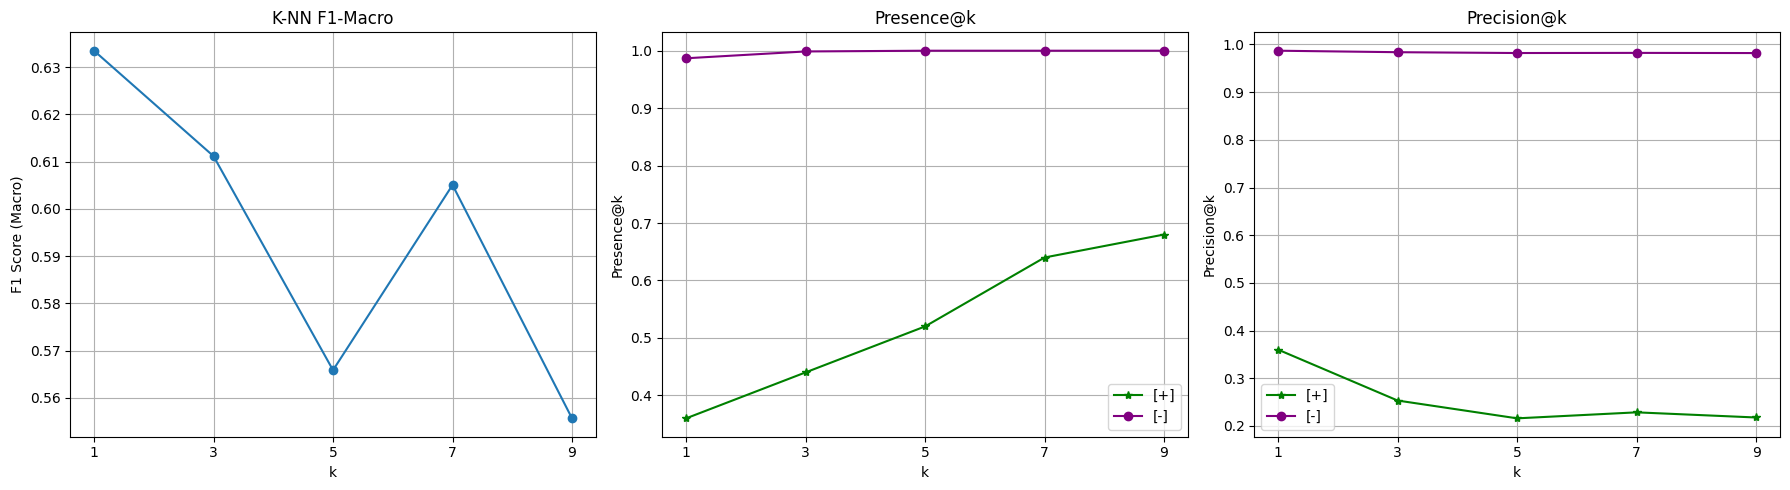

In [ ]:
evaluate_retrieval_system(BasicRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9])

## BinomialRetrievalSystem

Select n positives based on binomial random sampling $$ n \sim Binomial(k,p(C+|q)) $$

Questo tipo di retriever:
- funziona bene per i positivi
- funziona un pò male per i negativi

Il problema è che il ruolo della distanza viene rilegato soltanto a scegliere QUALI positivi e QUALI negativi ritornare, perdendo il suo ruolo decisionale sul QUANTI di ciascun gruppo selezionare.

Facendo salire k così, se il punto si trova in una zona densa di probabilità positiva, vengono presi più positivi anche se molto più distanti dei punti negeativi.

--> Bisogna pensare ad un metodologia meno netta della distribuzione binomiale, che tenga conto anche della distanza di ciascun punto.

In [10]:
class BinomialUnifiedRetrievalSystem(RetrievalSystem):
    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1), C=3, K_0=20):
        query_emb = self.embedding_model.encode([query])[0].astype('float32')
        query_pca = self.pca.transform([query_emb])[0]

        bayes_probs = self._posterior_probabilities(query_pca)
        if show_bayesian:
            print("\n[Bayesian Probabilities for Query]")
            print(bayes_probs)

        # Global search
        D, I = self.index_all.search(np.array([query_emb]), max(C * top_k, K_0))
        candidates = self.db.iloc[I[0]].copy()
        candidates['score'] = D[0]

        # Sample how many positives to include
        n_pos = int(np.random.binomial(candidates['Successful'].sum(), bayes_probs["P(C+|x)"]))
        n_neg = top_k - n_pos

        # Split candidates based on class
        pos_candidates = candidates[candidates['Successful'] == 1]
        neg_candidates = candidates[candidates['Successful'] == 0]

        # Take top n_pos and n_neg based on score
        top_pos = pos_candidates.nlargest(n=n_pos, columns='score') if n_pos > 0 else pd.DataFrame()
        top_neg = neg_candidates.nlargest(n=n_neg, columns='score') if n_neg > 0 else pd.DataFrame()

        # Combine results
        results = pd.concat([top_pos, top_neg])
        results['P(C+|x)'] = bayes_probs['P(C+|x)']
        return results.sort_values(by='score', ascending=False).reset_index(drop=True)

    def __call__(self, query, top_k=10, **kwargs):
      return self.retrieve(query=query, top_k=top_k, **kwargs)



In [ ]:
class BinomialSplitRetrievalSystem(RetrievalSystem):
    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1)):
        query_emb = self.embedding_model.encode([query])[0].astype('float32')
        query_pca = self.pca.transform([query_emb])[0]

        bayes_probs = self._posterior_probabilities(query_pca)
        if show_bayesian:
            print("\n[Bayesian Probabilities for Query]")
            print(bayes_probs)

        n_pos = int(np.random.binomial(top_k, bayes_probs["P(C+|x)"]))
        n_neg = top_k - n_pos

        top_pos = pd.DataFrame()
        top_neg = pd.DataFrame()
        if n_pos > 0:
            D_pos, I_pos = self.index_pos.search(np.array([query_emb]), n_pos)
            top_pos = self.db_pos.iloc[I_pos[0]].copy()
            top_pos['score'] = D_pos[0]
        if n_neg > 0:
            D_neg, I_neg = self.index_neg.search(np.array([query_emb]), n_neg)
            top_neg = self.db_neg.iloc[I_neg[0]].copy()
            top_neg['score'] = D_neg[0]

        results = pd.concat([top_pos, top_neg])
        results['P(C+|x)'] = bayes_probs['P(C+|x)']
        return results.sort_values(by='score', ascending=False).reset_index(drop=True)



[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= BinomialRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.4269
Confusion Matrix:
[[1611  745]
 [   8   17]]
Precision(+)@k: 0.6800
Presence(+)@k: 0.6800
Precision(-)@k: 0.6838
Presence(-)@k: 0.6838

k=3
F1 Macro: 0.4427
Confusion Matrix:
[[1668  688]
 [   4   21]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.9200
Precision(-)@k: 0.6999
Presence(-)@k: 0.8960

k=5
F1 Macro: 0.4431
Confusion Matrix:
[[1678  678]
 [   5   20]]
Precision(+)@k: 0.7040
Presence(+)@k: 0.9200
Precision(-)@k: 0.6993
Presence(-)@k: 0.9444

k=7
F1 Macro: 0.4382
Confusion Matrix:
[[1659  697]
 [   6   19]]
Precision(+)@k: 0.7314
Presence(+)@k: 0.9600
Precision(-)@k: 0.6940
Presence(-)@k: 0.9610

k=9
F1 Macro: 0.4401
Confusion Matrix:
[[1654  702]


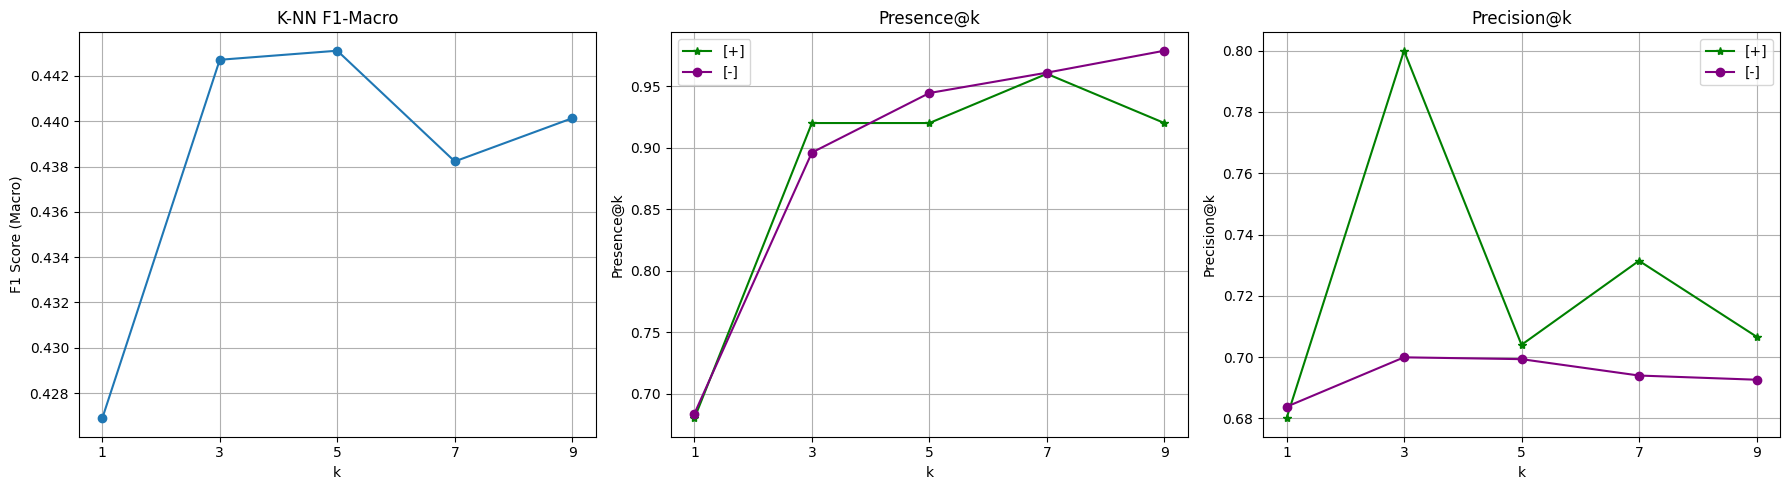

In [ ]:
evaluate_retrieval_system(BinomialSplitRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9])


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= BinomialUnifiedRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5350
Confusion Matrix:
[[2075  281]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8807
Presence(-)@k: 0.8807

k=3
F1 Macro: 0.5767
Confusion Matrix:
[[2199  157]
 [   6   19]]
Precision(+)@k: 0.7467
Presence(+)@k: 0.8400
Precision(-)@k: 0.9233
Presence(-)@k: 0.9584

k=5
F1 Macro: 0.5952
Confusion Matrix:
[[2256  100]
 [  10   15]]
Precision(+)@k: 0.5760
Presence(+)@k: 0.8400
Precision(-)@k: 0.9477
Presence(-)@k: 0.9890

k=7
F1 Macro: 0.5788
Confusion Matrix:
[[2297   59]
 [  17    8]]
Precision(+)@k: 0.4114
Presence(+)@k: 0.8000
Precision(-)@k: 0.9586
Presence(-)@k: 0.9953

k=9
F1 Macro: 0.6121
Confusion Matrix:
[[2300

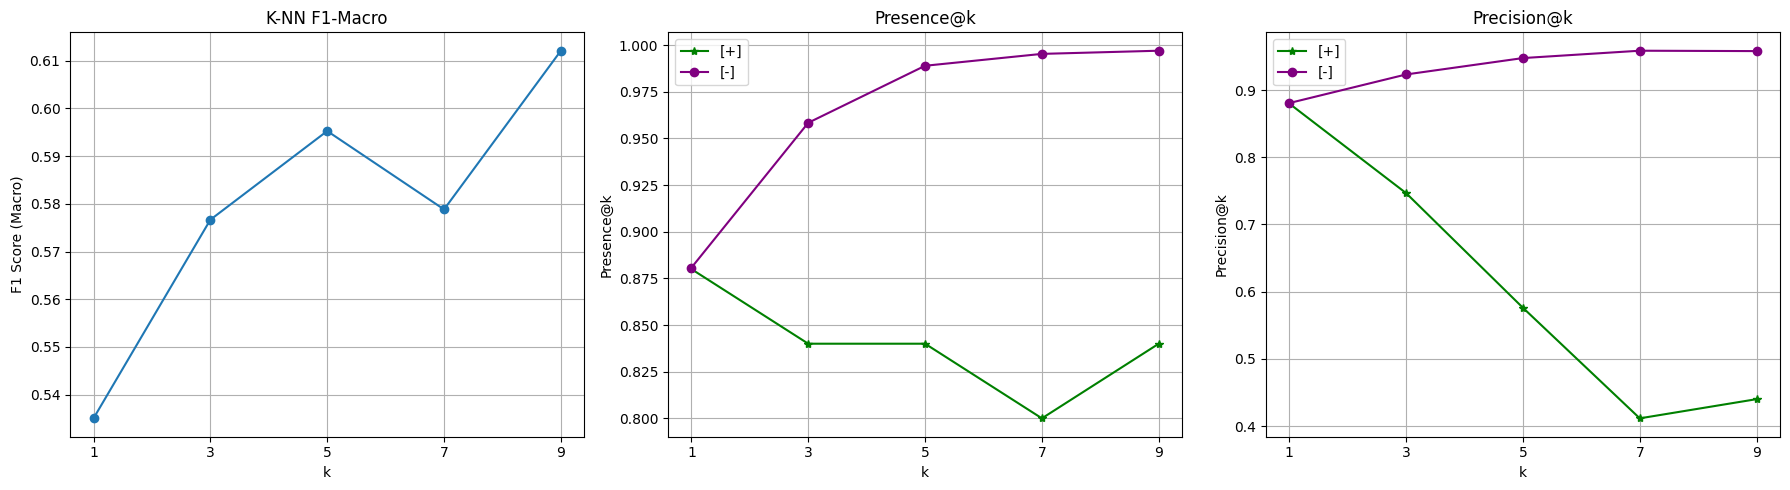

In [11]:
evaluate_retrieval_system(BinomialUnifiedRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9])

## Scoring Function $$f\left(<p,q>,P(C(p)|q)\right)$$

While the basical retrieval system only uses similarities, penalizing + classes due to their low presence in the database, the binomial retrievel excessively premiates +es.

We do need a scoring function to balance  P(C+|q) and sim(p,q).

$$f\left(<p,q>,P(C(p)|q)\right) = g(<p,q>)\big(θ_1 + θ_2P(C(p)|q)\big)$$

Where P(C(p)) is point's p label (+ or -), $g:ℝ^{2} → ℝ $.

Precisely:
- when $p \in C- ⇒ P(C-|q) = 1 - P(C+|q) $,
- when $p \in C+ ⇒ P(C+|q)$

This is how we try to combine local similarities <p,q> with position of q in the PCA plane.

θs are hyperparameters. When set to $θ_1 = \theta_2 = 1$ the equation becomes:
$$f\left(<p,q>,P(C(p)|q)\right) = g(<p,q>)(1 +P(C(p)|q))$$

While if one wants to rescale distances proportionally to the probability its enough to set $\theta_1 = 0, \theta_2 = 1$

Then: $$f\left(<p,q>,P(C(p)|q)\right) = g(<p,q>)P(C(p)|q)$$


Since the score $f$ is funcion of p and q, for the sake of simpliciy, we can write:
$$f\left(<p,q>,P(C(p)|q)\right)= f(p,q)$$


### Split Ranking

We separately retrieve k-(+)es and k-(-)es elements. Then, we mix them and re-rank according to $f(p,q)$.

In [ ]:
class SplitRetrievalSystem(RetrievalSystem, ABC):
    @abstractmethod
    def g(self, dot_products):
        """Transform dot products via g."""
        pass

    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1)):
        a, b = theta

        # Encode query and project with PCA
        query_emb = self.embedding_model.encode([query])[0].astype('float32').reshape(1, -1)
        query_pca = self.pca.transform(query_emb)[0]
        P_Cpos_q = self._posterior_probabilities(query_pca)["P(C+|x)"]

        # Retrieve candidates
        D_pos, I_pos = self.index_pos.search(query_emb, top_k)
        D_neg, I_neg = self.index_neg.search(query_emb, top_k)

        pos_candidates = self.db_pos.iloc[I_pos[0]].copy()
        neg_candidates = self.db_neg.iloc[I_neg[0]].copy()

        # Store dot products
        pos_candidates['dot_product'] = D_pos[0]
        neg_candidates['dot_product'] = D_neg[0]

        # Apply g to dot products
        g_pos = self.g(D_pos[0])
        g_neg = self.g(D_neg[0])

        # Compute score = g(<p,q>) * (a + b * P(C(p)|q))
        pos_candidates['score'] = g_pos * (a + b * P_Cpos_q)
        neg_candidates['score'] = g_neg * (a + b * (1 - P_Cpos_q))

        # Combine and rank
        combined = pd.concat([pos_candidates, neg_candidates])
        results = combined.sort_values(by='score', ascending=False).head(top_k).reset_index(drop=True)
        results['P(C+|x)'] = P_Cpos_q

        if show_bayesian:
            print("\n[Bayesian Probability]")
            print(f"P(C+|x) = {P_Cpos_q:.4f}")

        return results


#### Linear g(x)=x

In [ ]:
class SplitLinearRetrievalSystem(SplitRetrievalSystem):
    def g(self, dot_products):
        return dot_products


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.4490
Confusion Matrix:
[[1702  654]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7224
Presence(-)@k: 0.7224

k=3
F1 Macro: 0.4499
Confusion Matrix:
[[1707  649]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7243
Presence(-)@k: 0.7279

k=5
F1 Macro: 0.4501
Confusion Matrix:
[[1708  648]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7252
Presence(-)@k: 0.7309

k=7
F1 Macro: 0.4503
Confusion Matrix:
[[1709  647]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7259
Presence(-)@k: 0.7326

k=9
F1 Macro: 0.4507
Confusion Matrix:
[[1711  64

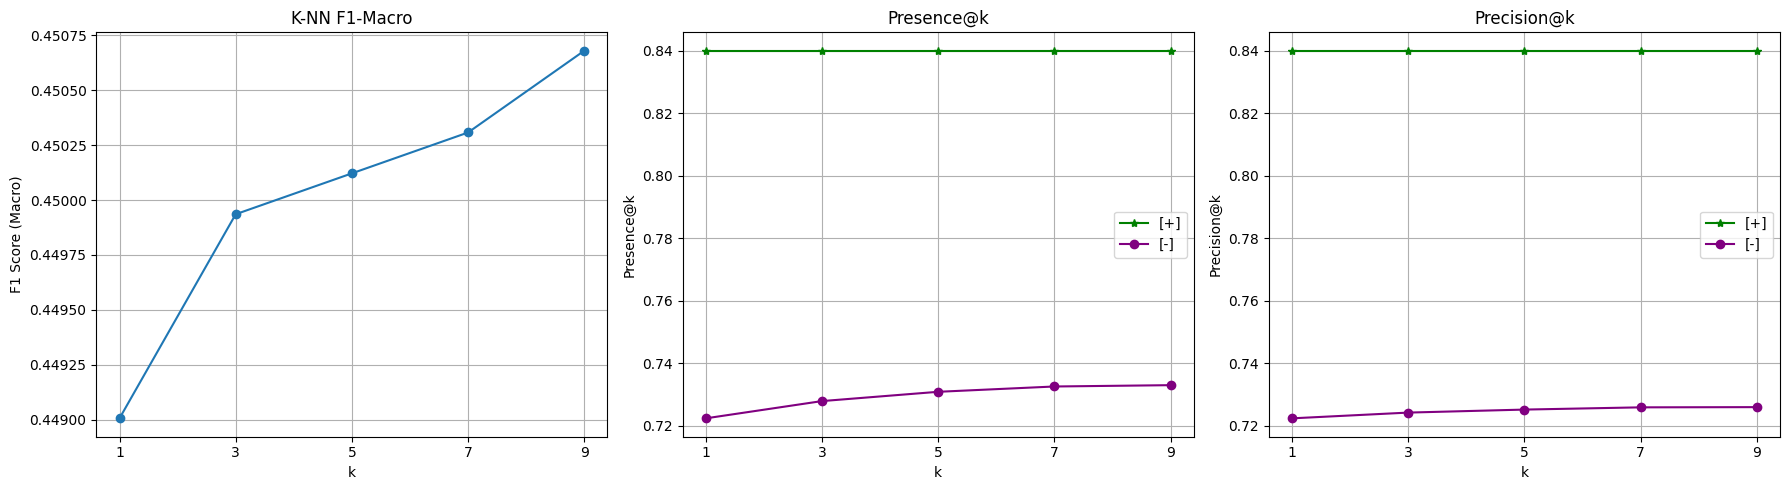

In [ ]:
evaluate_retrieval_system(SplitLinearRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9], theta=(1, 1))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.4442
Confusion Matrix:
[[1676  680]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7114
Presence(-)@k: 0.7114

k=3
F1 Macro: 0.4442
Confusion Matrix:
[[1676  680]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7112
Presence(-)@k: 0.7131

k=5
F1 Macro: 0.4449
Confusion Matrix:
[[1680  676]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7119
Presence(-)@k: 0.7148

k=7
F1 Macro: 0.4447
Confusion Matrix:
[[1679  677]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7121
Presence(-)@k: 0.7152

k=9
F1 Macro: 0.4449
Confusion Matrix:
[[1680  67

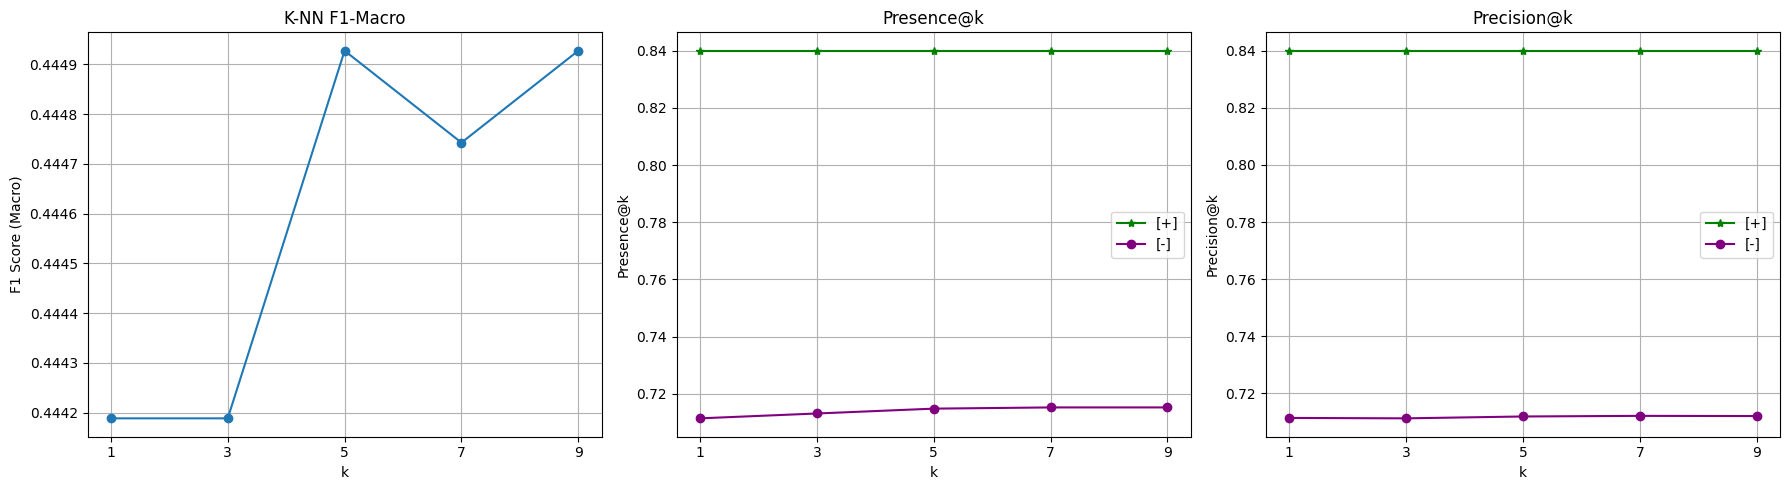

In [ ]:
evaluate_retrieval_system(SplitLinearRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9], theta=(0, 1))

#### Log g(x) = log(x)

Less-similar points results more similar after log.

In [ ]:
class SplitLogRetrievalSystem(SplitRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.4422
Confusion Matrix:
[[1665  691]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7067
Presence(-)@k: 0.7067

k=3
F1 Macro: 0.4420
Confusion Matrix:
[[1664  692]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7067
Presence(-)@k: 0.7076

k=5
F1 Macro: 0.4422
Confusion Matrix:
[[1665  691]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7070
Presence(-)@k: 0.7088

k=7
F1 Macro: 0.4423
Confusion Matrix:
[[1666  690]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7073
Presence(-)@k: 0.7097

k=9
F1 Macro: 0.4425
Confusion Matrix:
[[1667  689]


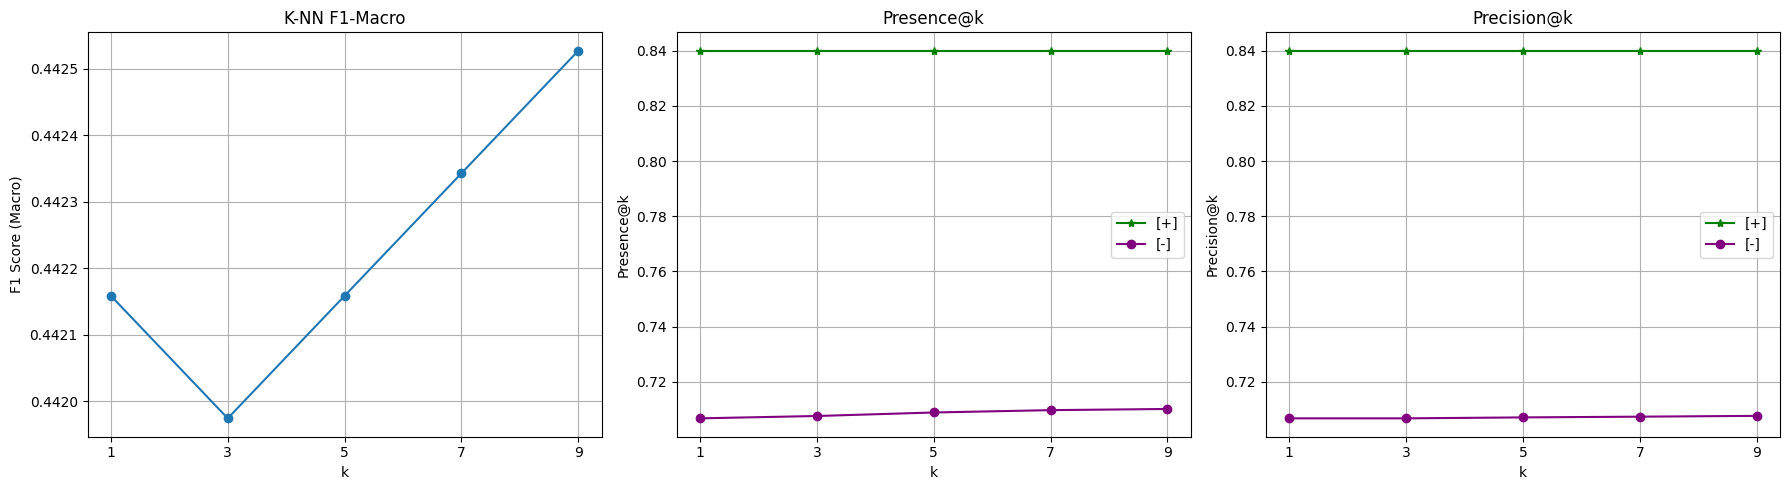

In [ ]:
evaluate_retrieval_system(SplitLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9], theta=(1, 1))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.4412
Confusion Matrix:
[[1660  696]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7046
Presence(-)@k: 0.7046

k=3
F1 Macro: 0.4412
Confusion Matrix:
[[1660  696]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7044
Presence(-)@k: 0.7046

k=5
F1 Macro: 0.4412
Confusion Matrix:
[[1660  696]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7045
Presence(-)@k: 0.7046

k=7
F1 Macro: 0.4412
Confusion Matrix:
[[1660  696]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.7045
Presence(-)@k: 0.7046

k=9
F1 Macro: 0.4412
Confusion Matrix:
[[1660  696]


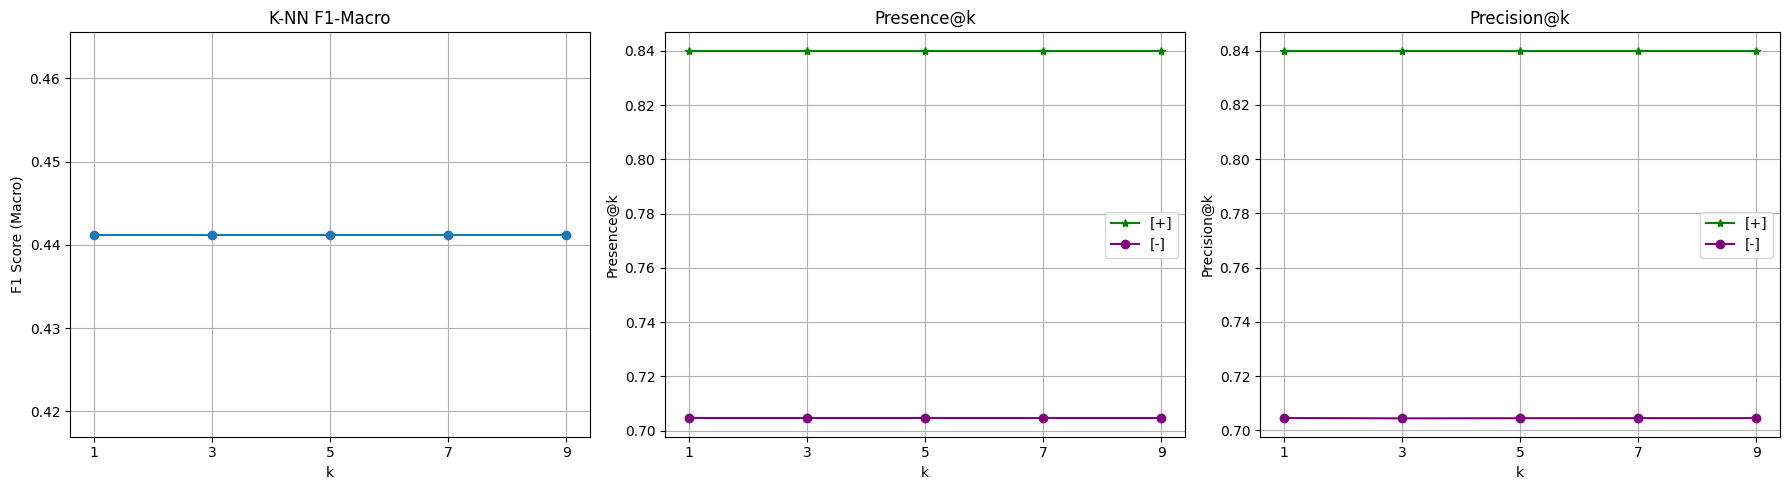

In [ ]:
evaluate_retrieval_system(SplitLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9], theta=(0, 1))

### Unified Ranking

Instead of sampling k +es and k -es, we retreive $max(K0,Ck)$, score them all, then cut-off at $k$

In [ ]:
class UnifiedRetrievalSystem(RetrievalSystem, ABC):
    @abstractmethod
    def g(self, dot_products):
        """Apply transformation to dot products."""
        pass

    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1), C=3, K_0=20):
        a, b = theta

        # Encode + PCA
        query_emb = self.embedding_model.encode([query])[0].astype('float32').reshape(1, -1)
        query_pca = self.pca.transform(query_emb)[0]
        P_Cpos_q = self._posterior_probabilities(query_pca)["P(C+|x)"]

        # FAISS retrieval
        D, I = self.index_all.search(query_emb, max(top_k * C, K_0))
        candidates = self.db.iloc[I[0]].copy()
        candidates['dot_product'] = np.clip(D[0], 1e-6, None)

        # Bayes weights in [0,1] according to label
        bayesian_weight = np.where(candidates[self.label_col], P_Cpos_q, 1 - P_Cpos_q)

        # Compute score using g(<p,q>)
        g_values = self.g(candidates['dot_product'].values)
        candidates['score'] = g_values * (a + b * bayesian_weight)

        # Sort & return top_k
        results = candidates.sort_values(by='score', ascending=False).head(top_k).reset_index(drop=True)
        results['P(C+|x)'] = P_Cpos_q

        if show_bayesian:
            print("\n[Bayesian Probability]")
            print(f"P(C+|x) = {P_Cpos_q:.4f}")

        return results

    def __call__(self, query, top_k, show_bayesian=False, theta=(1, 1),C=3,K_0=20):
        return self.retrieve(query, top_k, show_bayesian=show_bayesian, theta=theta,C=C,K_0=K_0)


#### Linear g(x) = x

In [ ]:
class UnifiedLinearRetrievalSystem(UnifiedRetrievalSystem):
    def g(self, dot_products):
        return dot_products


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5251
Confusion Matrix:
[[2052  304]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8710
Presence(-)@k: 0.8710

k=3
F1 Macro: 0.5608
Confusion Matrix:
[[2160  196]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9114
Presence(-)@k: 0.9465

k=5
F1 Macro: 0.5920
Confusion Matrix:
[[2230  126]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9362
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9489
Presence(-)@k: 0.9928

k=9
F1 Macro: 0.6035
Confusion Matrix:
[[2279  

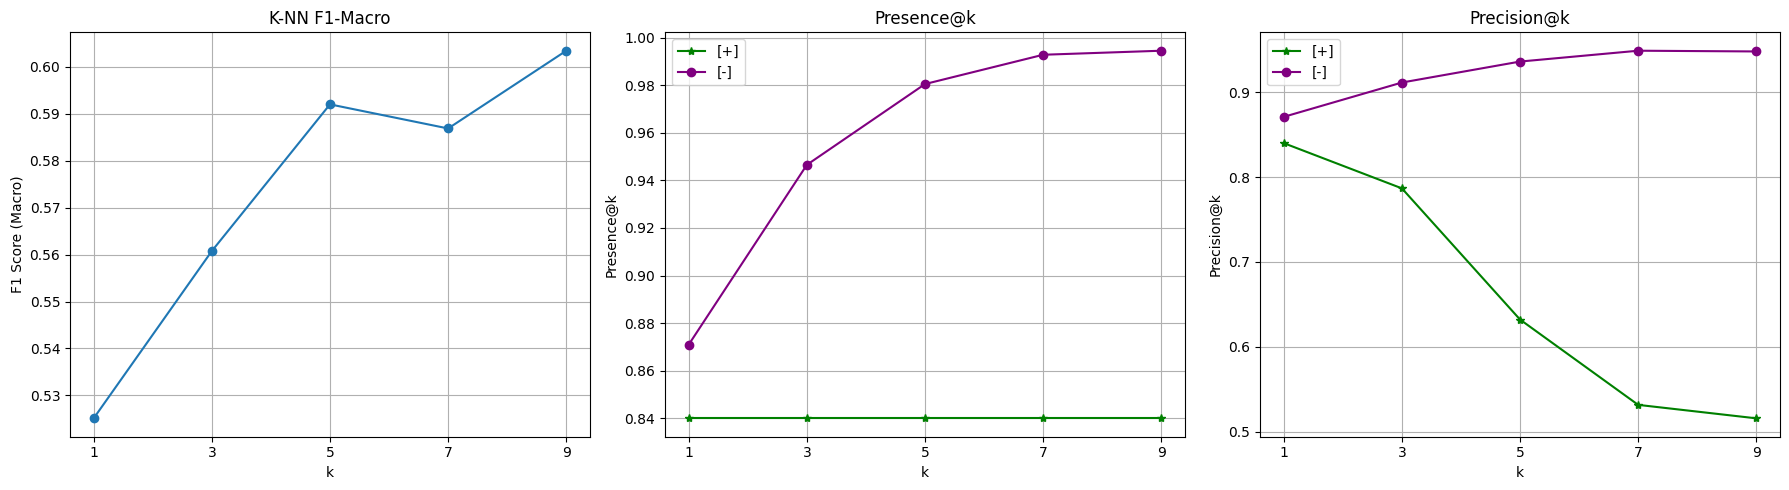

In [ ]:
evaluate_retrieval_system(UnifiedLinearRetrievalSystem,data,k_vals=[1,3,5,7,9], theta=(1, 1))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Gaussian:
  mu: [ 0.056 -0.008  0.012  0.006  0.013]
  sigma: [4.164 2.261 1.888 1.387 1.222]

[INFO] Done!

k=1
F1 Macro: 0.5411
Confusion Matrix:
[[2102  254]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8922
Presence(-)@k: 0.8922

k=3
F1 Macro: 0.5711
Confusion Matrix:
[[2181  175]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9233
Presence(-)@k: 0.9525

k=5
F1 Macro: 0.6032
Confusion Matrix:
[[2244  112]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9439
Presence(-)@k: 0.9809

k=7
F1 Macro: 0.5926
Confusion Matrix:
[[2276   80]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k:

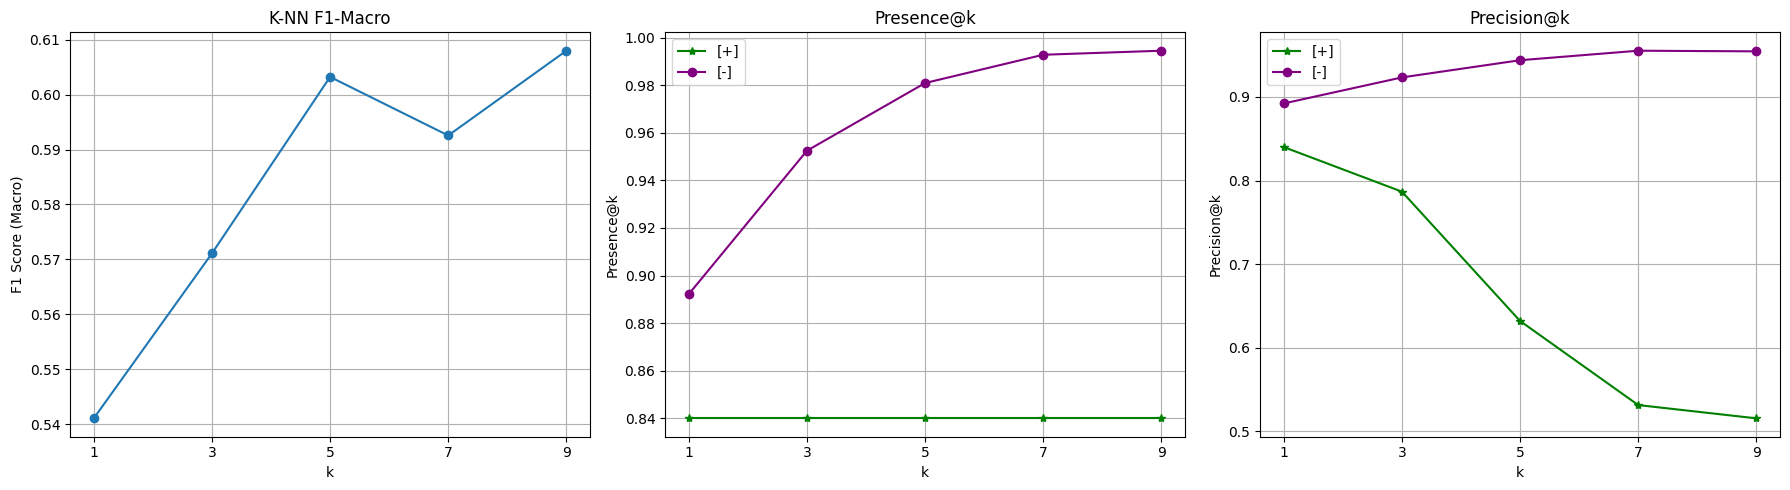

In [ ]:
evaluate_retrieval_system(UnifiedLinearRetrievalSystem,data,k_vals=[1,3,5,7,9], theta=(1, 1), n_components=5)

For k>5, the number of negatives retrieved becomes too high: no matter what is k, there will be no enough (+)es to retrieve nearby.

#### Log g(x) = log(x)

In [ ]:
class UnifiedLogRetrievalSystem(UnifiedRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))



[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5239
Confusion Matrix:
[[2048  308]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8693
Presence(-)@k: 0.8693

k=3
F1 Macro: 0.5598
Confusion Matrix:
[[2158  198]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9103
Presence(-)@k: 0.9457

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9356
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9487
Presence(-)@k: 0.9928

k=9
F1 Macro: 0.6035
Confusion Matrix:
[[2279   77

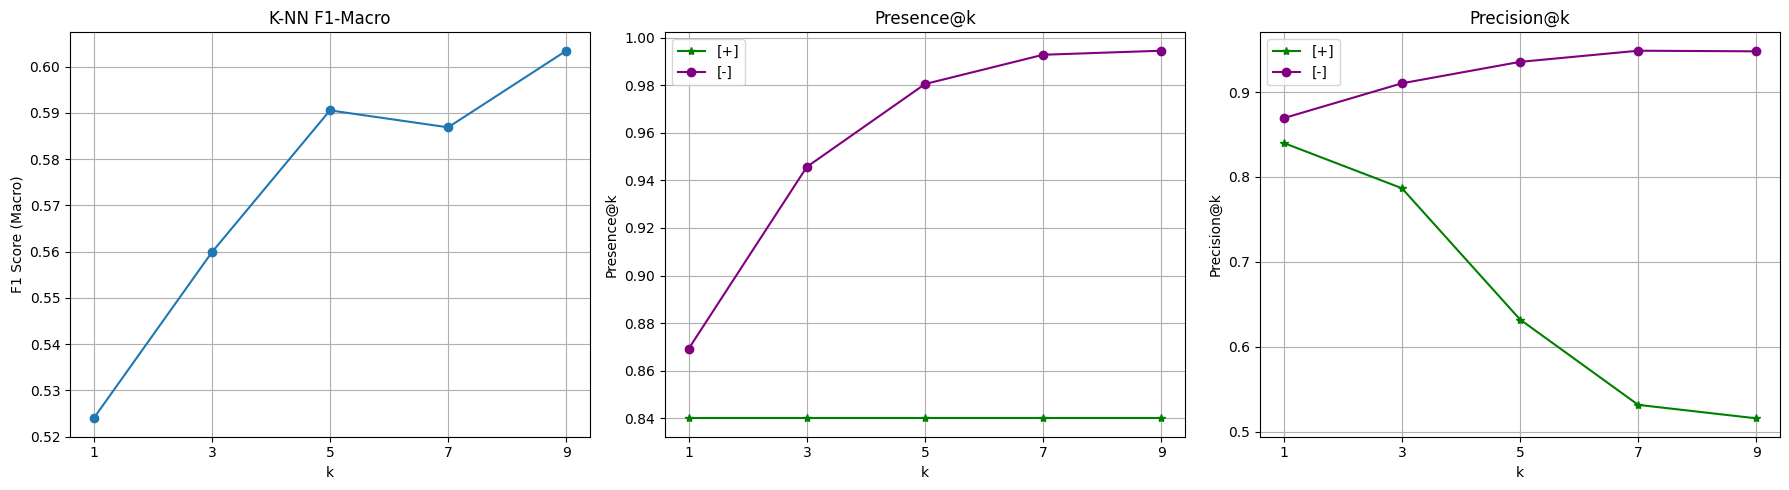

In [ ]:
evaluate_retrieval_system(UnifiedLogRetrievalSystem,data,k_vals=[1,3,5,7,9], theta=(1, 1))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Gaussian:
  mu: [ 0.056 -0.008  0.012  0.006  0.013]
  sigma: [4.164 2.261 1.888 1.387 1.222]

[INFO] Done!

k=1
F1 Macro: 0.5407
Confusion Matrix:
[[2101  255]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8918
Presence(-)@k: 0.8918

k=3
F1 Macro: 0.5711
Confusion Matrix:
[[2181  175]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9233
Presence(-)@k: 0.9525

k=5
F1 Macro: 0.6032
Confusion Matrix:
[[2244  112]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9439
Presence(-)@k: 0.9809

k=7
F1 Macro: 0.5926
Confusion Matrix:
[[2276   80]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.

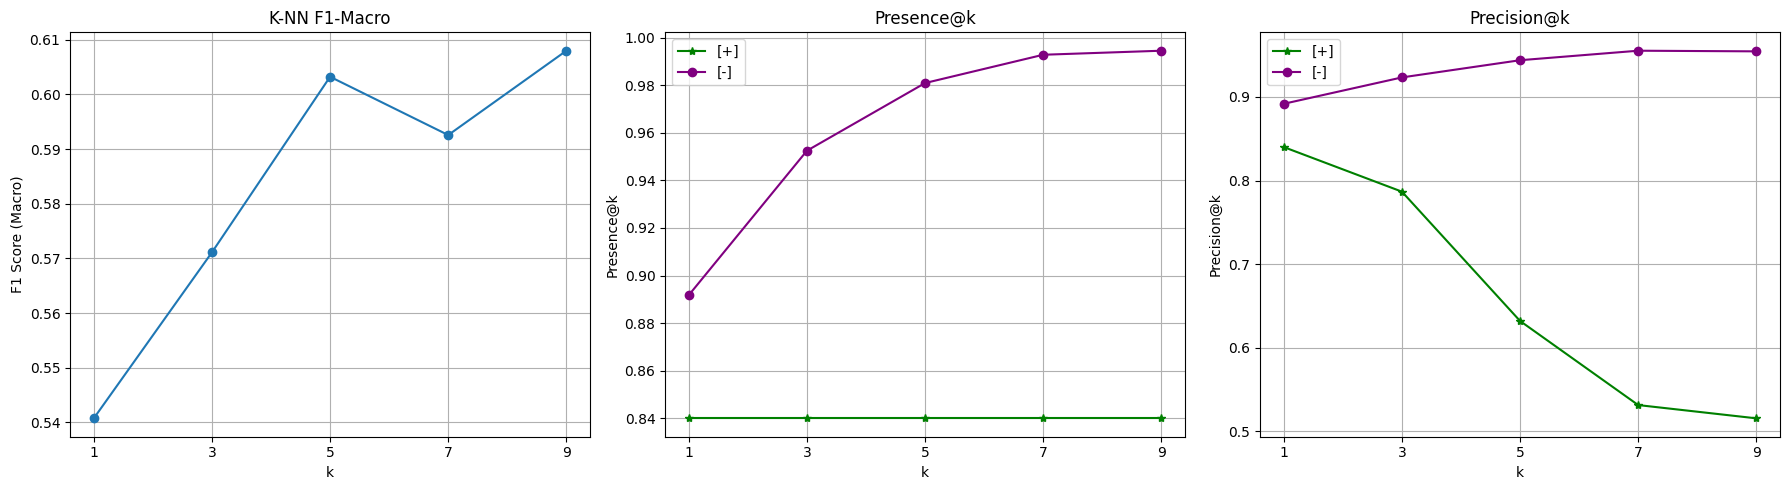

In [ ]:
evaluate_retrieval_system(UnifiedLogRetrievalSystem,data,k_vals=[1,3,5,7,9], theta=(1, 1),n_components = 5)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5239
Confusion Matrix:
[[2048  308]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8693
Presence(-)@k: 0.8693

k=3
F1 Macro: 0.5598
Confusion Matrix:
[[2158  198]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9103
Presence(-)@k: 0.9457

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9356
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9487
Presence(-)@k: 0.9928

k=9
F1 Macro: 0.6035
Confusion Matrix:
[[2279   77

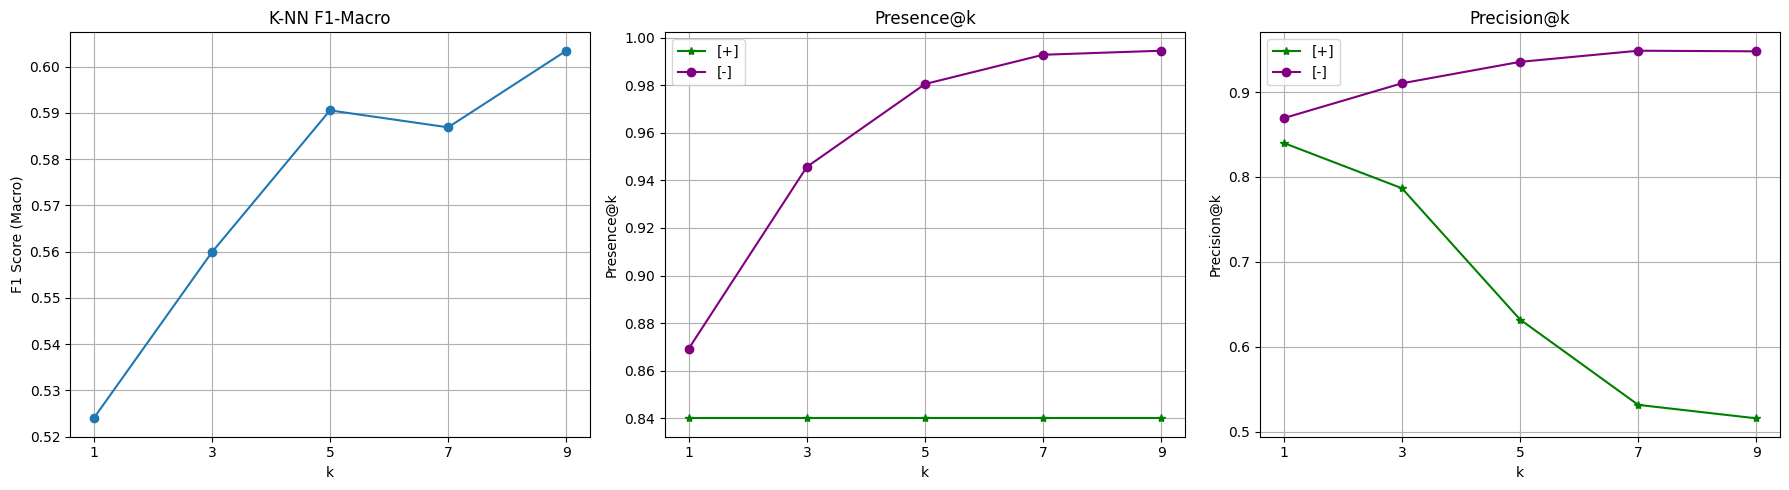

In [ ]:
evaluate_retrieval_system(UnifiedLogRetrievalSystem,data,k_vals=[1,3,5,7,9], theta=(0,1))

## $(-) \sim U([x_{max} - x_{min}],[y_{max} - y_{min}])$

Assumes (-)es are everywhere.

In case of PCA(n = 2):
$$p_-(x,y) = \frac{1}{(x_{max} - x_{min})(y_{max} - y_{min})} $$

In general:
$$
(-) \sim U\left( [x_{\max}^{(1)} - x_{\min}^{(1)}], [x_{\max}^{(2)} - x_{\min}^{(2)}], \dots, [x_{\max}^{(n)} - x_{\min}^{(n)}] \right)
$$

$$p_-(\vec{x}) = ∏_{i = 1}^{n_{comps}}\frac{1}{x^{(i)}_{max} - x^{(i)}_{min}}$$

We select max and mins within a coverage tollerange (e.g. 95% of the coverage range, meaning between the 2.5 and 97.5 percentiles)



### Binomial


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= BinomialRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.3949
Confusion Matrix:
[[1426  930]
 [   7   18]]
Precision(+)@k: 0.7200
Presence(+)@k: 0.7200
Precision(-)@k: 0.6053
Presence(-)@k: 0.6053

k=3
F1 Macro: 0.3937
Confusion Matrix:
[[1414  942]
 [   6   19]]
Precision(+)@k: 0.7200
Presence(+)@k: 0.9200
Precision(-)@k: 0.5949
Presence(-)@k: 0.7857

k=5
F1 Macro: 0.3890
Confusion Matrix:
[[1394  962]
 [   7   18]]
Precision(+)@k: 0.7360
Presence(+)@k: 1.0000
Precision(-)@k: 0.5945
Presence(-)@k: 0.8459

k=7
F1 Macro: 0.3891
Confusion Matrix:
[[1395  961]
 [   7   18]]
Precision(+)@k: 0.6857
Presence(+)@k: 0.9600
Precision(-)@k: 0.5955
Presence(-)@k: 0.8688

k=9
F1 Macro:

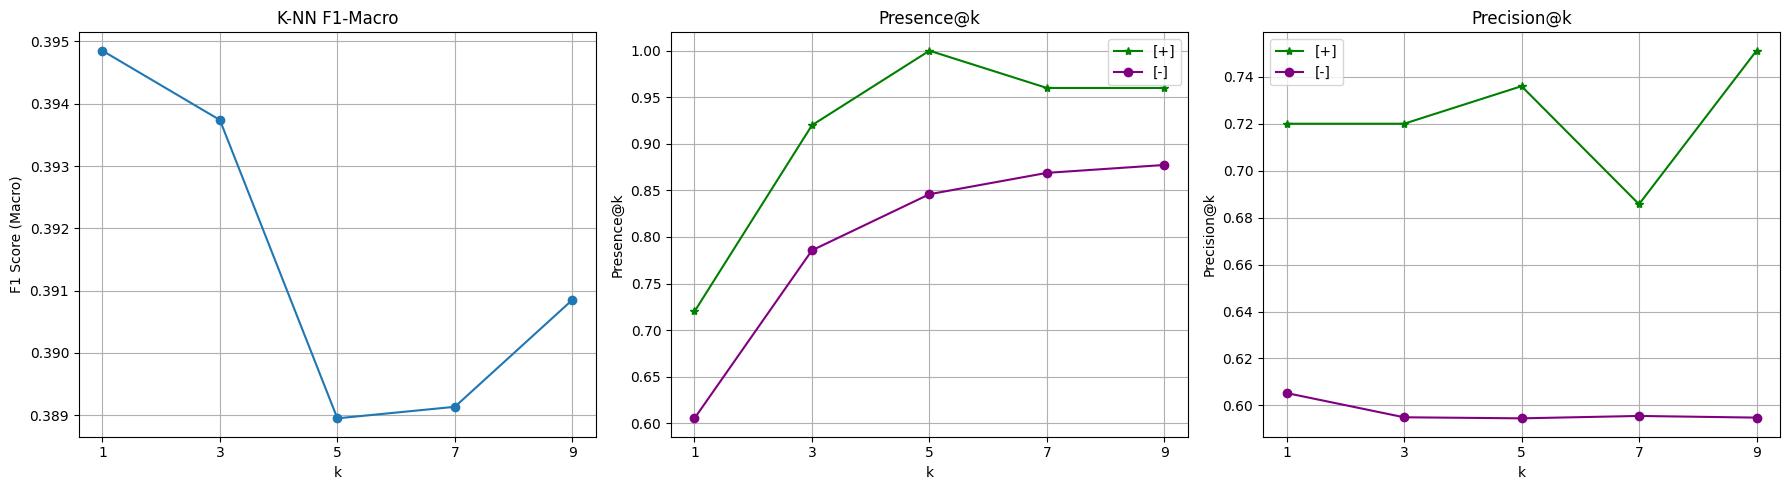

In [ ]:
evaluate_retrieval_system(
    BinomialRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= BinomialRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644 -3.39  -2.728 -2.245]
  upper = [8.435 4.006 3.927 2.638 1.855]

[INFO] Done!

k=1
F1 Macro: 0.3875
Confusion Matrix:
[[1369  987]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.5811
Presence(-)@k: 0.5811

k=3
F1 Macro: 0.3953
Confusion Matrix:
[[1399  957]
 [   2   23]]
Precision(+)@k: 0.8533
Presence(+)@k: 0.9600
Precision(-)@k: 0.5829
Presence(-)@k: 0.6812

k=5
F1 Macro: 0.3996
Confusion Matrix:
[[1422  934]
 [   2   23]]
Precision(+)@k: 0.8560
Presence(+)@k: 0.9600
Precision(-)@k: 0.5935
Presence(-)@k: 0.7224

k=7
F1 Macro: 0.3942
Confusion Matrix:
[[1399  957]
 [   3   22]]
Precision(+)@k: 0.8457
Pre

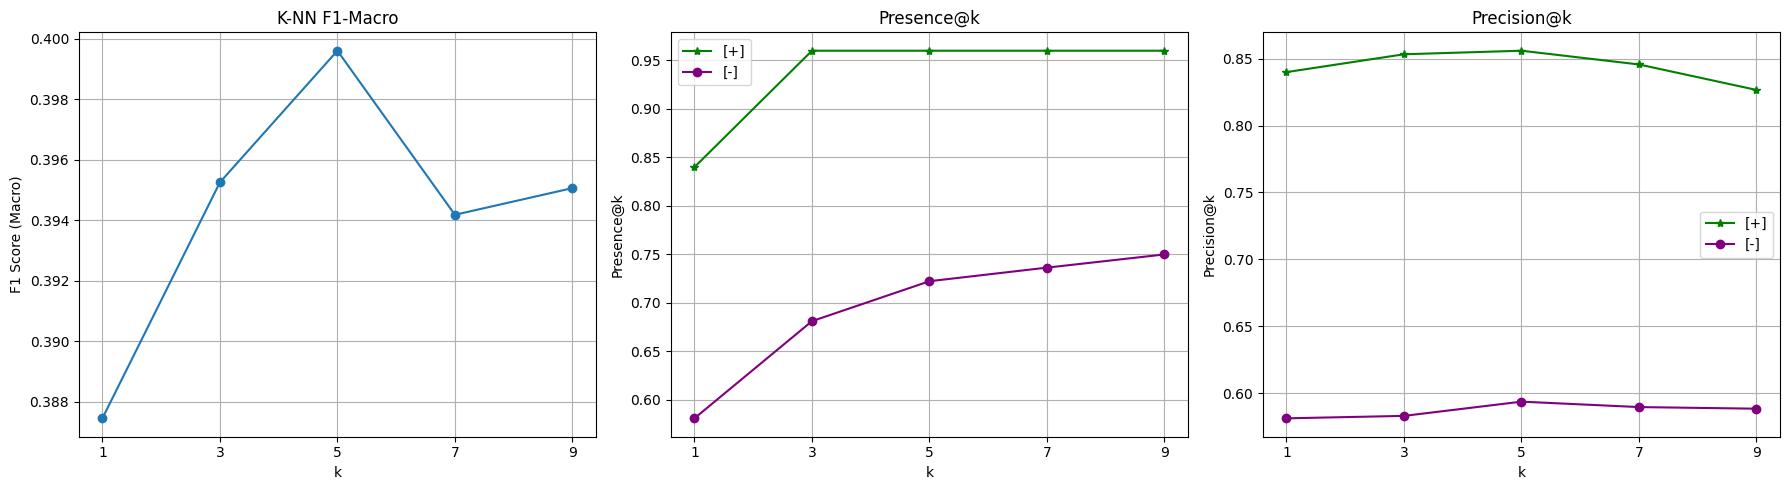

In [ ]:
evaluate_retrieval_system(
    BinomialRetrievalSystem,data,
    n_components=5,
    k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)

### Unified


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5269
Confusion Matrix:
[[2058  298]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8735
Presence(-)@k: 0.8735

k=3
F1 Macro: 0.5622
Confusion Matrix:
[[2163  193]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9123
Presence(-)@k: 0.9465

k=5
F1 Macro: 0.5913
Confusion Matrix:
[[2229  127]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9365
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9494
Presence(-)@k: 0.9928

k=9
F1 M

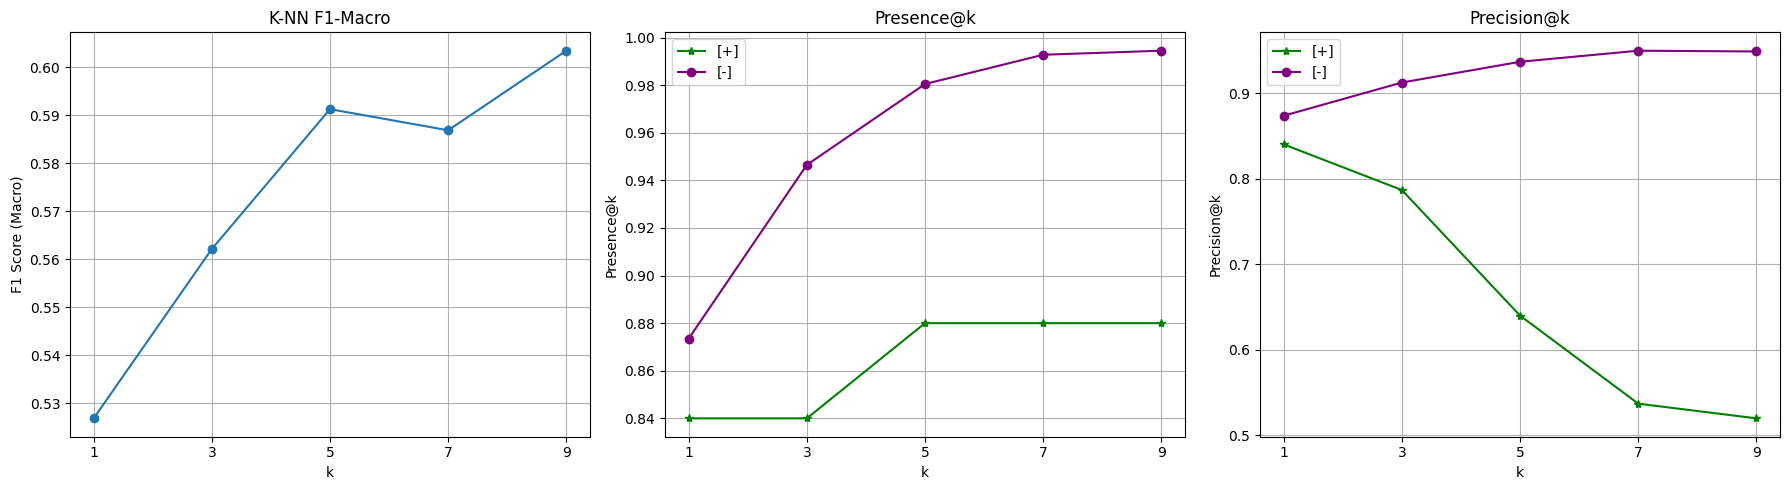

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5285
Confusion Matrix:
[[2054  302]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8718
Presence(-)@k: 0.8718

k=3
F1 Macro: 0.5608
Confusion Matrix:
[[2160  196]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9114
Presence(-)@k: 0.9457

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9362
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9493
Presence(-)@k: 0.9928

k=9
F1 Macr

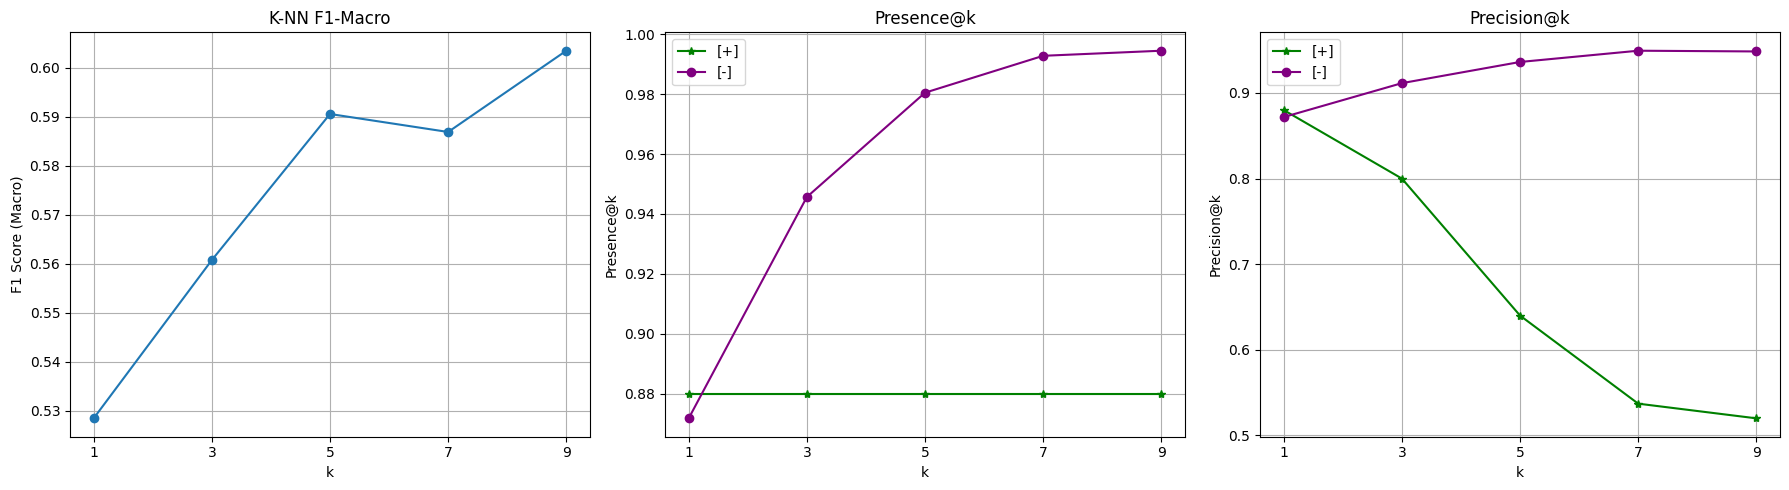

In [ ]:
evaluate_retrieval_system(
    UnifiedLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644 -3.39  -2.728 -2.245]
  upper = [8.435 4.006 3.927 2.638 1.855]

[INFO] Done!

k=1
F1 Macro: 0.5360
Confusion Matrix:
[[2078  278]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8820
Presence(-)@k: 0.8820

k=3
F1 Macro: 0.5660
Confusion Matrix:
[[2171  185]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9178
Presence(-)@k: 0.9499

k=5
F1 Macro: 0.5974
Confusion Matrix:
[[2237  119]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9407
Presence(-)@k: 0.9817

k=7
F1 Macro: 0.5926
Confusion Matrix:
[[2276   80]
 [  13   12]]
Precision(+)@k: 0.5371
P

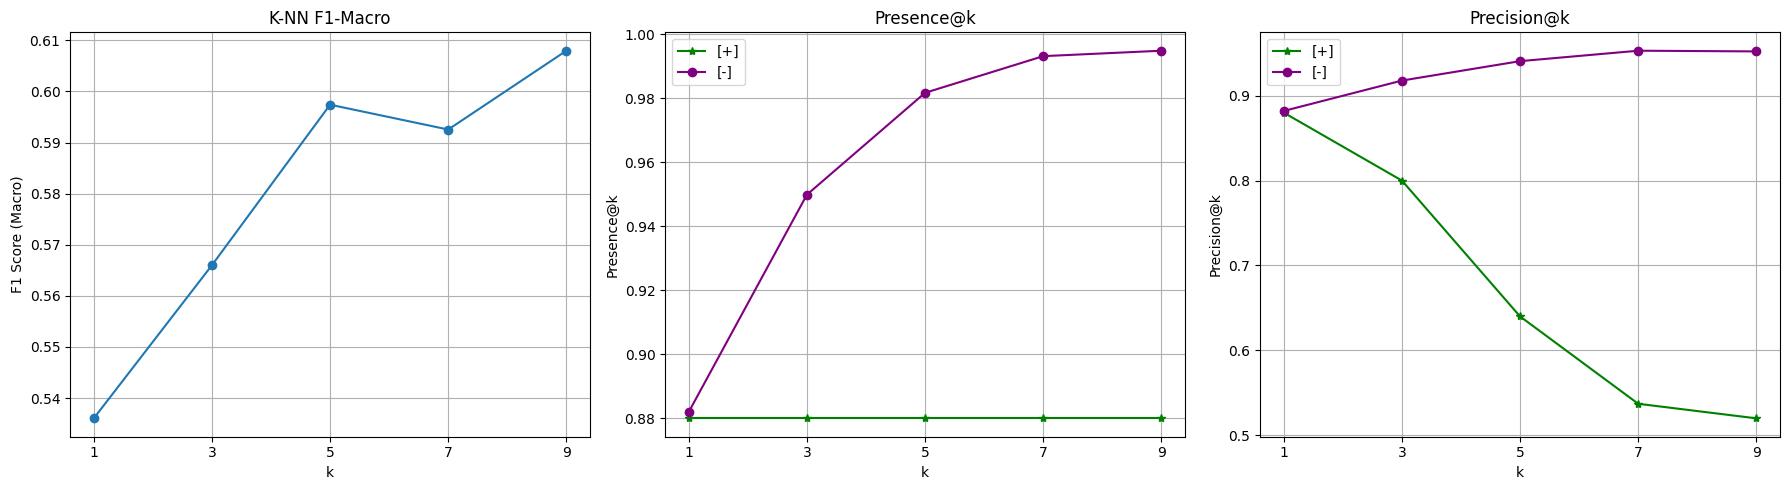

In [ ]:
evaluate_retrieval_system(
    UnifiedLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
    n_components=5,
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5418
Confusion Matrix:
[[2142  214]
 [   8   17]]
Precision(+)@k: 0.6800
Presence(+)@k: 0.6800
Precision(-)@k: 0.9092
Presence(-)@k: 0.9092

k=3
F1 Macro: 0.5902
Confusion Matrix:
[[2250  106]
 [  10   15]]
Precision(+)@k: 0.5467
Presence(+)@k: 0.6800
Precision(-)@k: 0.9467
Presence(-)@k: 0.9767

k=5
F1 Macro: 0.5837
Confusion Matrix:
[[2258   98]
 [  12   13]]
Precision(+)@k: 0.5360
Presence(+)@k: 0.8800
Precision(-)@k: 0.9491
Presence(-)@k: 0.9881

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9494
Presence(-)@k: 0.9928

k=9
F1 M

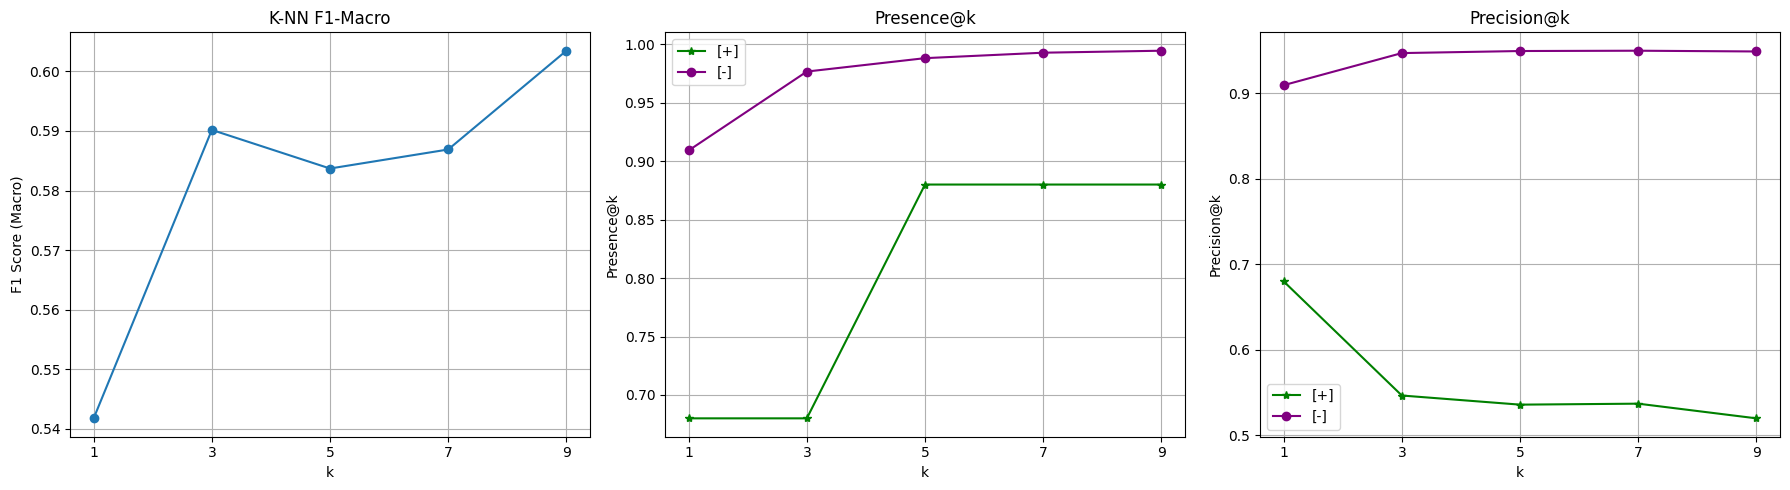

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,1),
    negative_distribution = "Uniform",
    K_0 = 10,
    C=3
)

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,1),
    negative_distribution = "Uniform",
    K_0 = 0,
    C=3
)

### Split


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.3872
Confusion Matrix:
[[1362  994]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.5781
Presence(-)@k: 0.5781

k=3
F1 Macro: 0.3874
Confusion Matrix:
[[1363  993]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.5785
Presence(-)@k: 0.5789

k=5
F1 Macro: 0.3872
Confusion Matrix:
[[1362  994]
 [   3   22]]
Precision(+)@k: 0.8720
Presence(+)@k: 0.8800
Precision(-)@k: 0.5789
Presence(-)@k: 0.5811

k=7
F1 Macro: 0.3875
Confusion Matrix:
[[1364  992]
 [   3   22]]
Precision(+)@k: 0.8629
Presence(+)@k: 0.8800
Precision(-)@k: 0.5792
Presence(-)@k: 0.5815

k=9
F1 Macro:

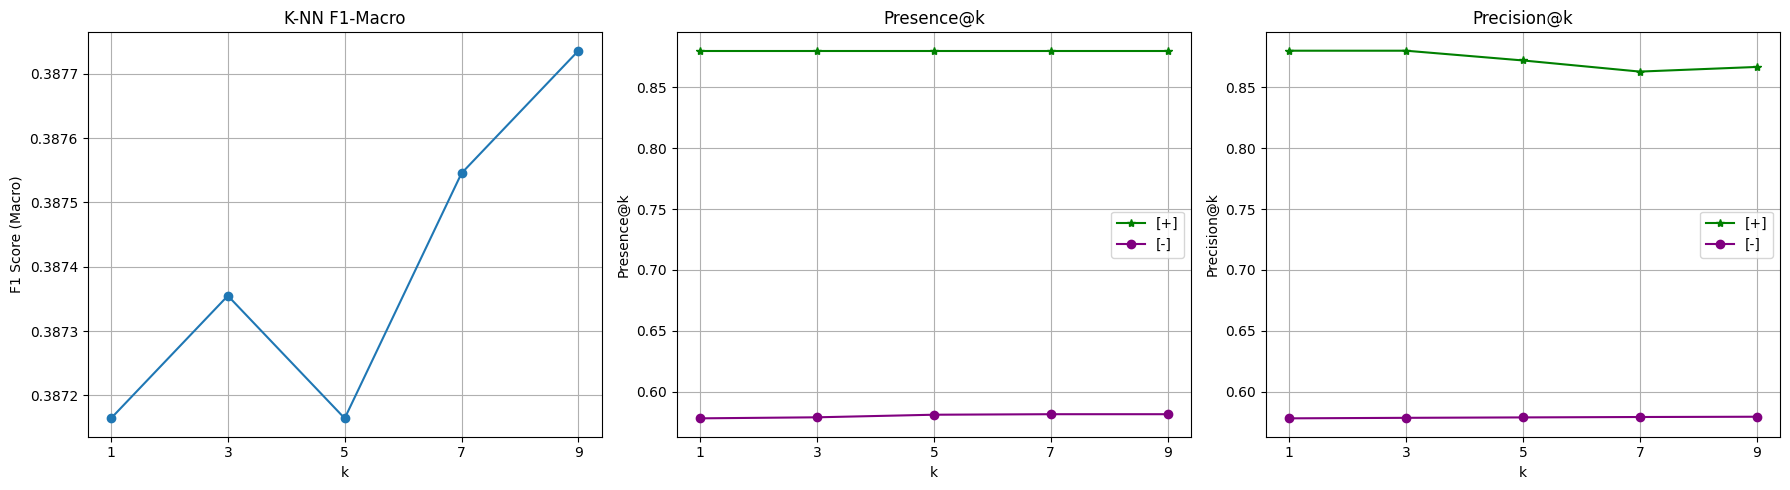

In [ ]:
evaluate_retrieval_system(
    SplitLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.3965
Confusion Matrix:
[[1417  939]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6014
Presence(-)@k: 0.6014

k=3
F1 Macro: 0.3969
Confusion Matrix:
[[1419  937]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6023
Presence(-)@k: 0.6074

k=5
F1 Macro: 0.3978
Confusion Matrix:
[[1424  932]
 [   4   21]]
Precision(+)@k: 0.8480
Presence(+)@k: 0.8800
Precision(-)@k: 0.6037
Presence(-)@k: 0.6108

k=7
F1 Macro: 0.3980
Confusion Matrix:
[[1425  931]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 0.8800
Precision(-)@k: 0.6044
Presence(-)@k: 0.6125

k=9
F1 Mac

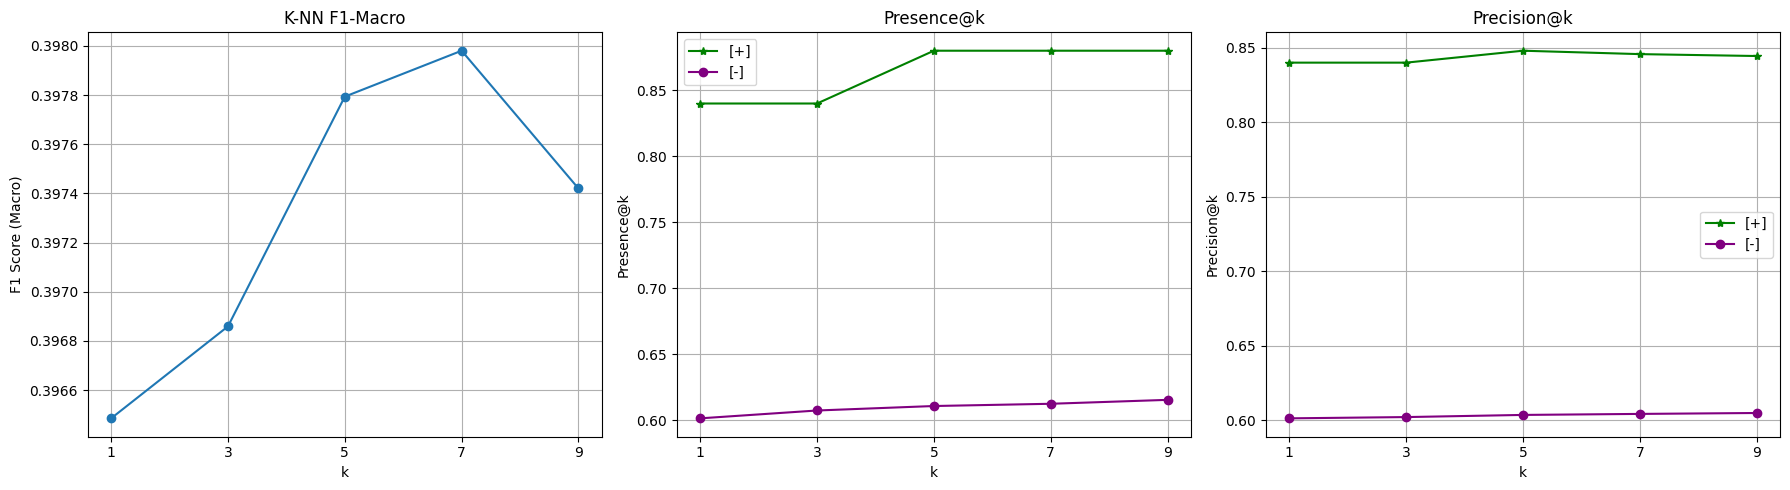

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    negative_distribution="Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644 -3.39  -2.728 -2.245]
  upper = [8.435 4.006 3.927 2.638 1.855]

[INFO] Done!

k=1
F1 Macro: 0.4026
Confusion Matrix:
[[1432  924]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.6078
Presence(-)@k: 0.6078

k=3
F1 Macro: 0.4026
Confusion Matrix:
[[1432  924]
 [   1   24]]
Precision(+)@k: 0.9467
Presence(+)@k: 0.9600
Precision(-)@k: 0.6075
Presence(-)@k: 0.6104

k=5
F1 Macro: 0.4024
Confusion Matrix:
[[1431  925]
 [   1   24]]
Precision(+)@k: 0.9520
Presence(+)@k: 0.9600
Precision(-)@k: 0.6082
Presence(-)@k: 0.6133

k=7
F1 Macro: 0.4034
Confusion Matrix:
[[1436  920]
 [   1   24]]
Precision(+)@k: 0.9486


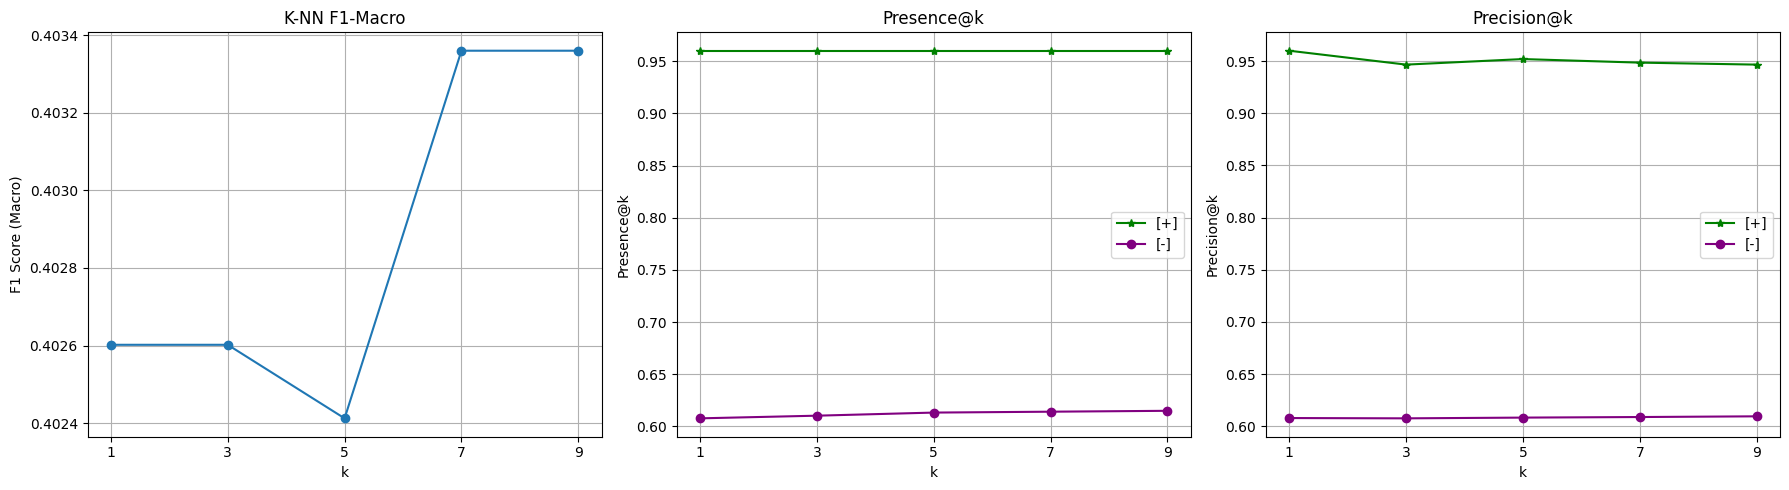

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 1),
    n_components = 5,
    negative_distribution="Uniform",
)

## Smoothing Probability Effect

So far, to me the best method appears to be the Unified score.

However, the effect of the probability is yet too aggressive: we need to figure out alternatives to the scoring function $f_\theta$ to lower this effect.

We can:
- select $\theta_1 = α\theta_2$
- Positive Boost (premiate only (+)es): $$f_\theta(p,q) = g(<p,q>)(1 + \alpha l\left(P(C+|q)[p \in C+]\right)$$

where $l: [0,1] → ℝ$

### $θ_2 = αθ_1$


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5302
Confusion Matrix:
[[2069  287]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8782
Presence(-)@k: 0.8782

k=3
F1 Macro: 0.5645
Confusion Matrix:
[[2168  188]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9150
Presence(-)@k: 0.9491

k=5
F1 Macro: 0.5951
Confusion Matrix:
[[2234  122]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9376
Presence(-)@k: 0.9809

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9499
Presence(-)@k: 0.9928

k=9
F1 M

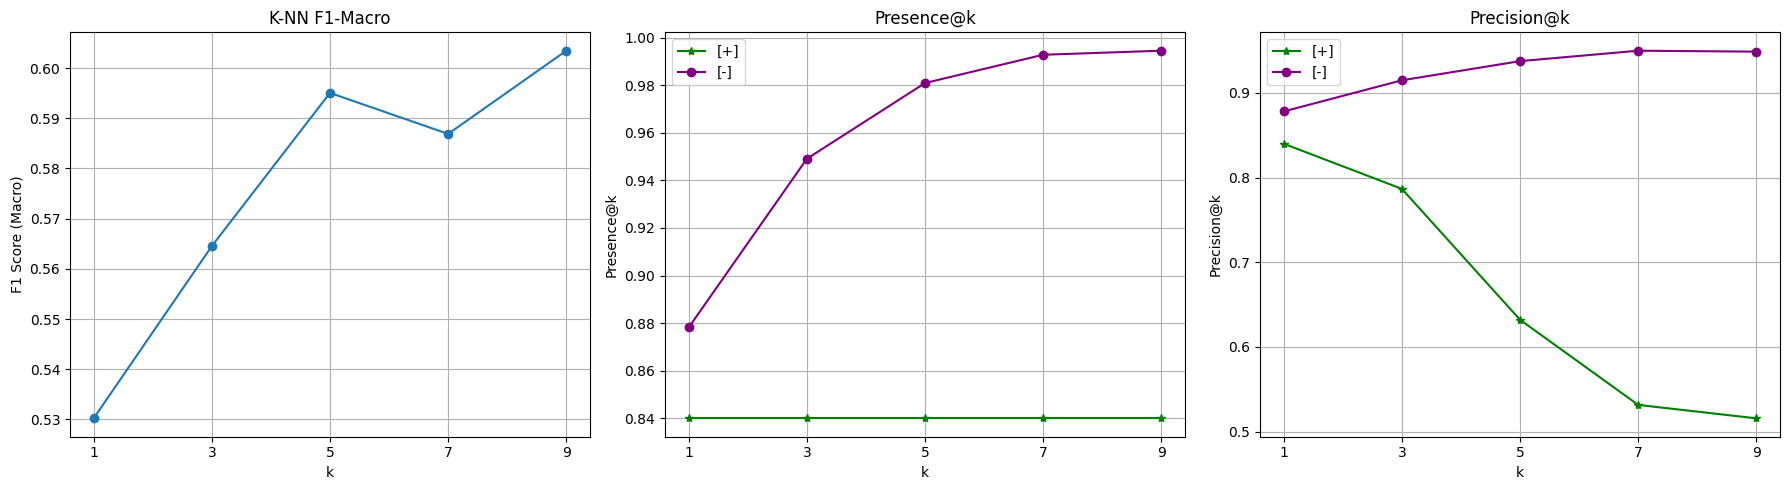

In [ ]:
# \alpha = 0.2
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.2),
    negative_distribution = "Uniform"
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5287
Confusion Matrix:
[[2064  292]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8761
Presence(-)@k: 0.8761

k=3
F1 Macro: 0.5631
Confusion Matrix:
[[2165  191]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9137
Presence(-)@k: 0.9482

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2232  124]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9373
Presence(-)@k: 0.9809

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9497
Presence(-)@k: 0.9928

k=9
F1 M

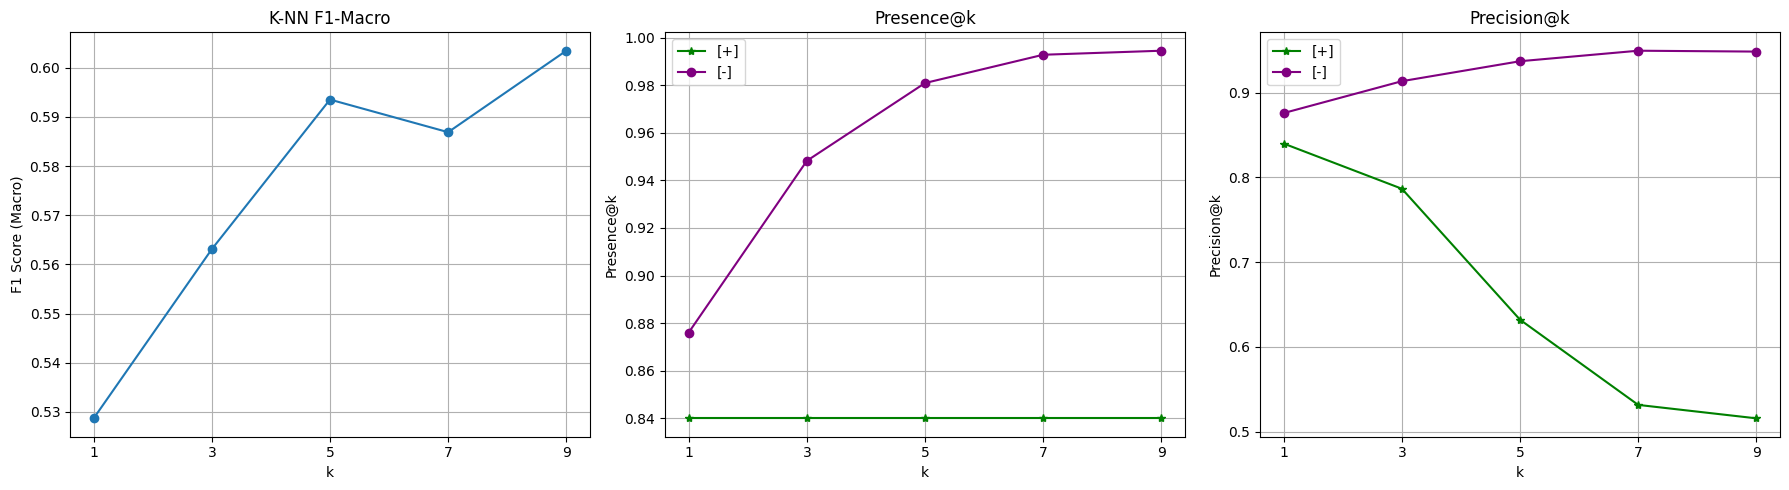

In [ ]:
# \alpha = 1/3
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform"
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644 -3.39  -2.728 -2.245]
  upper = [8.435 4.006 3.927 2.638 1.855]

[INFO] Done!

k=1
F1 Macro: 0.5390
Confusion Matrix:
[[2087  269]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8858
Presence(-)@k: 0.8858

k=3
F1 Macro: 0.5690
Confusion Matrix:
[[2177  179]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9202
Presence(-)@k: 0.9525

k=5
F1 Macro: 0.6015
Confusion Matrix:
[[2242  114]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9419
Presence(-)@k: 0.9817

k=7
F1 Macro: 0.5935
Confusion Matrix:
[[2277   79]
 [  13   12]]
Precision(+)@k: 0.537

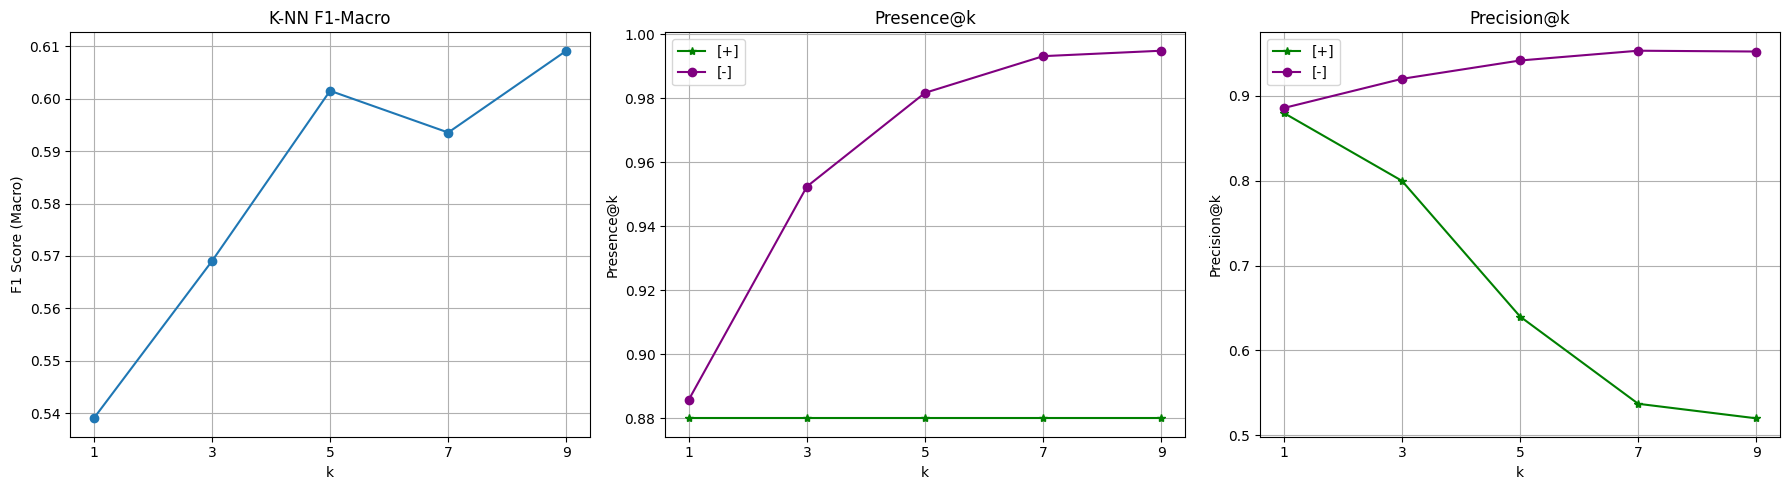

In [ ]:
# \alpha = 1/5, n_components = 5
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    n_components=5,
    theta=(1,0.2),
    negative_distribution = "Uniform"
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5263
Confusion Matrix:
[[2056  300]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8727
Presence(-)@k: 0.8727

k=3
F1 Macro: 0.5617
Confusion Matrix:
[[2162  194]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9121
Presence(-)@k: 0.9474

k=5
F1 Macro: 0.5928
Confusion Matrix:
[[2231  125]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9364
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9491
Presence(-)@k: 0.9928

k=9
F1 Macro: 0.6035
Confusion Matrix:
[[2279  

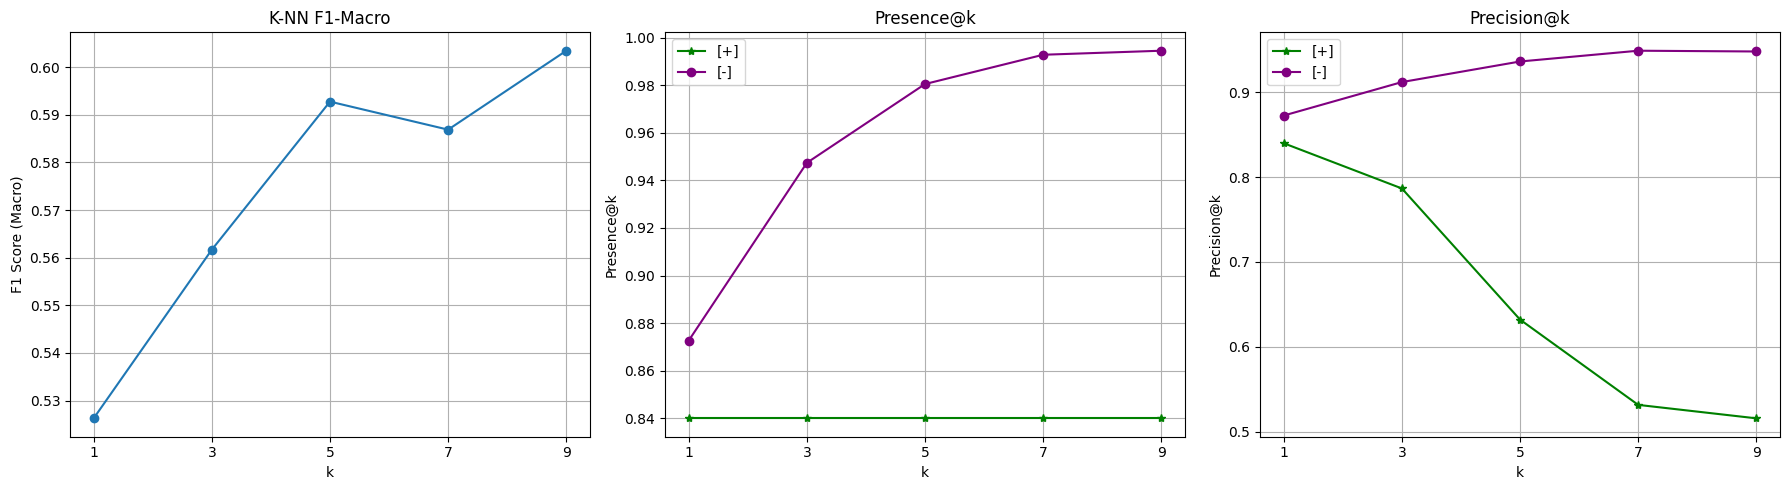

In [ ]:
# \alpha 1/3, Gaussian
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33)
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5275
Confusion Matrix:
[[2060  296]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8744
Presence(-)@k: 0.8744

k=3
F1 Macro: 0.5622
Confusion Matrix:
[[2163  193]
 [   5   20]]
Precision(+)@k: 0.7867
Presence(+)@k: 0.8400
Precision(-)@k: 0.9130
Presence(-)@k: 0.9478

k=5
F1 Macro: 0.5920
Confusion Matrix:
[[2230  126]
 [   7   18]]
Precision(+)@k: 0.6320
Presence(+)@k: 0.8400
Precision(-)@k: 0.9368
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9497
Presence(-)@k: 0.9928

k=9
F1 M

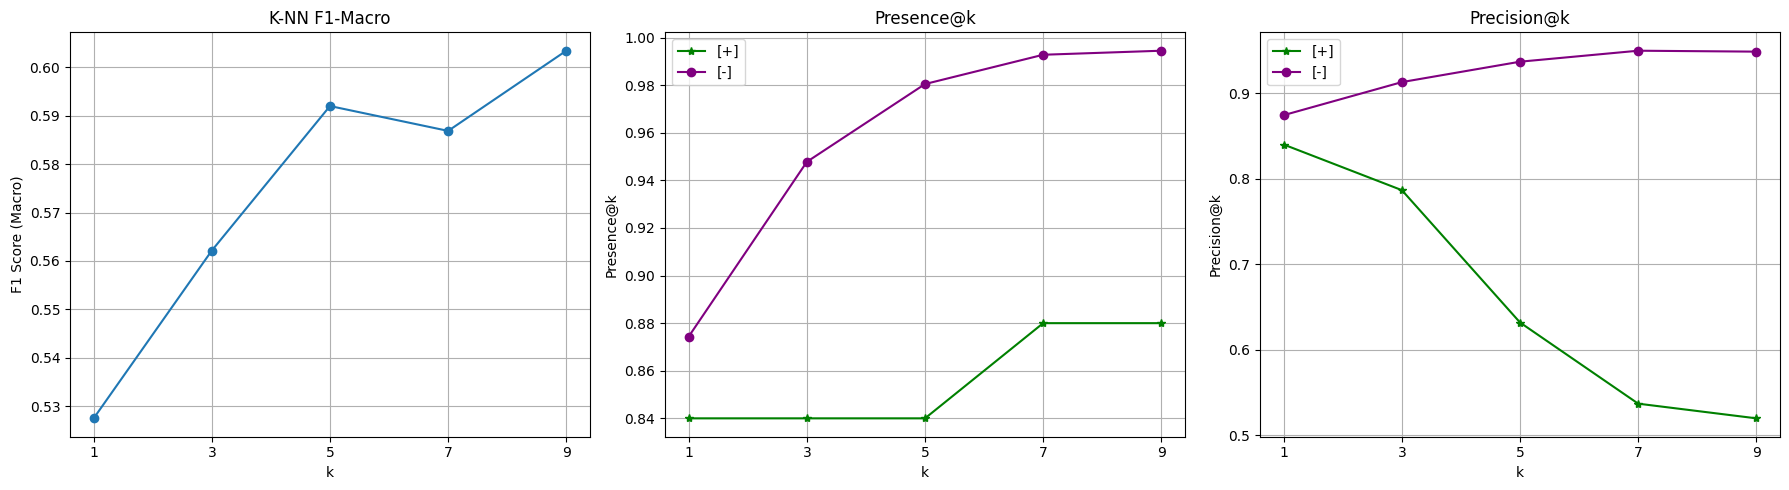

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.5),
    negative_distribution = "Uniform"
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.4928
Confusion Matrix:
[[1923  433]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8162
Presence(-)@k: 0.8162

k=3
F1 Macro: 0.5167
Confusion Matrix:
[[2022  334]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.8543
Presence(-)@k: 0.8918

k=5
F1 Macro: 0.5393
Confusion Matrix:
[[2097  259]
 [   4   21]]
Precision(+)@k: 0.8160
Presence(+)@k: 0.8400
Precision(-)@k: 0.8785
Presence(-)@k: 0.9253

k=7
F1 Macro: 0.5509
Confusion Matrix:
[[2137  219]
 [   5   20]]
Precision(+)@k: 0.7486
Presence(+)@k: 0.8400
Precision(-)@k: 0.8981
Presence(-)@k: 0.9567

k=9
F1 M

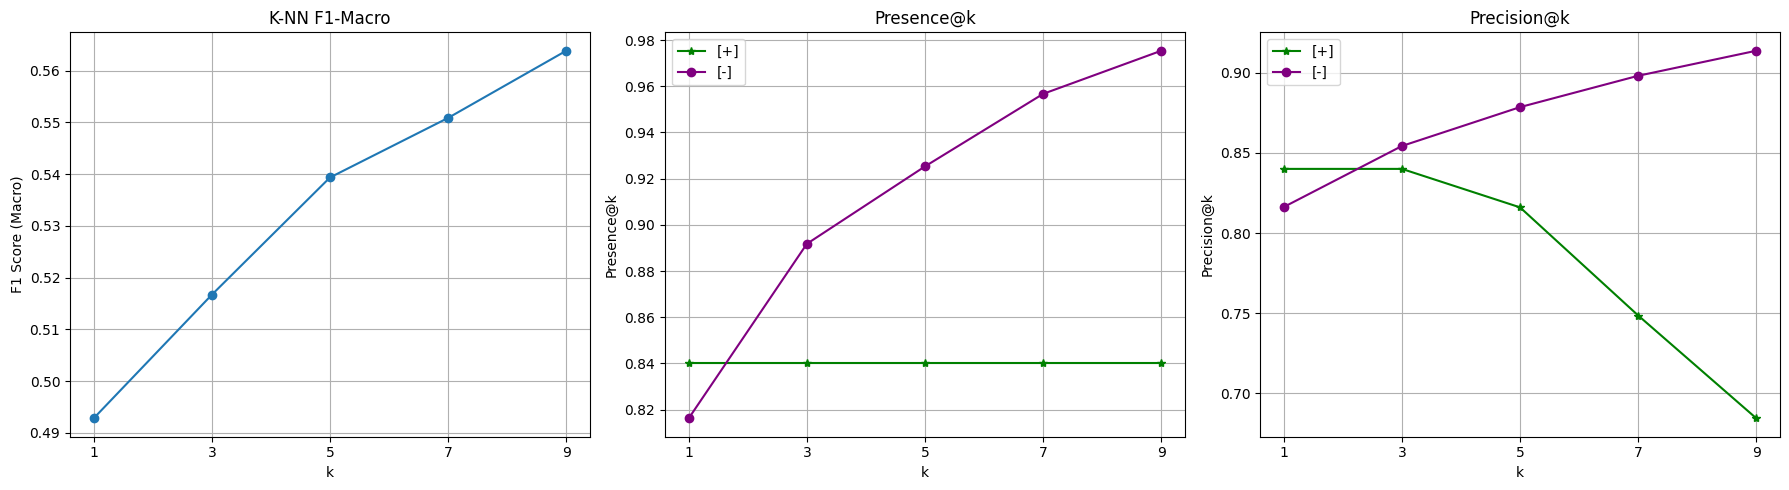

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
    K_0 = 50,
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5425
Confusion Matrix:
[[2144  212]
 [   8   17]]
Precision(+)@k: 0.6800
Presence(+)@k: 0.6800
Precision(-)@k: 0.9100
Presence(-)@k: 0.9100

k=3
F1 Macro: 0.5910
Confusion Matrix:
[[2251  105]
 [  10   15]]
Precision(+)@k: 0.5467
Presence(+)@k: 0.6800
Precision(-)@k: 0.9469
Presence(-)@k: 0.9767

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9652
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9646
Presence(-)@k: 0.9970

k=9
F1 M

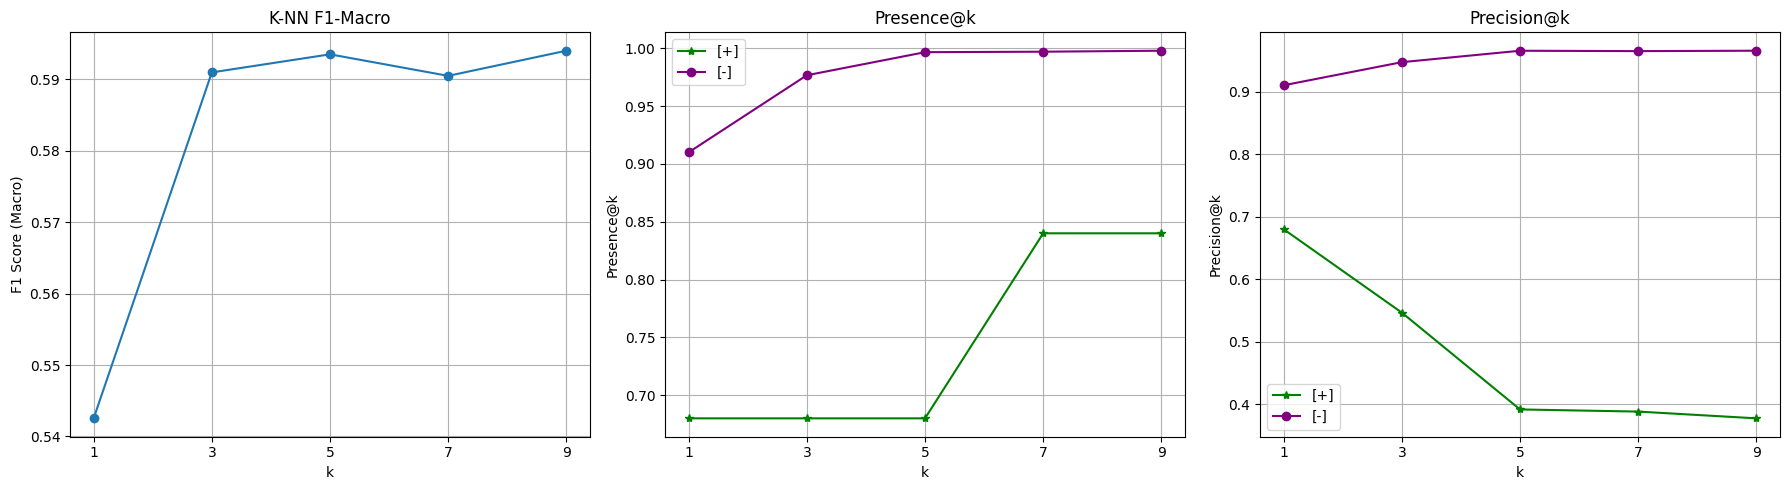

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
    K_0 = 10,
    C=2
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5418
Confusion Matrix:
[[2142  214]
 [   8   17]]
Precision(+)@k: 0.6800
Presence(+)@k: 0.6800
Precision(-)@k: 0.9092
Presence(-)@k: 0.9092

k=3
F1 Macro: 0.5902
Confusion Matrix:
[[2250  106]
 [  10   15]]
Precision(+)@k: 0.5467
Presence(+)@k: 0.6800
Precision(-)@k: 0.9467
Presence(-)@k: 0.9767

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9650
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9645
Presence(-)@k: 0.9970

k=9
F1 M

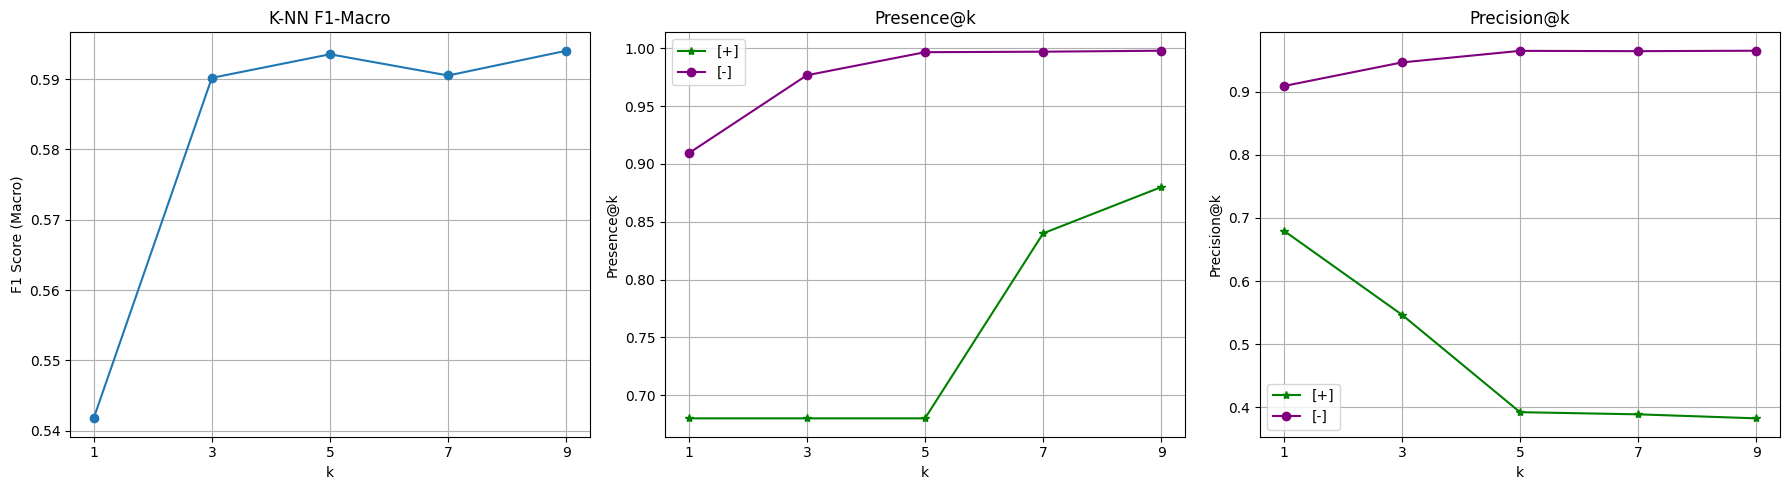

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,1),
    negative_distribution = "Uniform",
    K_0 = 10,
    C=2
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5843
Confusion Matrix:
[[2293   63]
 [  16    9]]
Precision(+)@k: 0.3600
Presence(+)@k: 0.3600
Precision(-)@k: 0.9733
Presence(-)@k: 0.9733

k=3
F1 Macro: 0.5925
Confusion Matrix:
[[2292   64]
 [  15   10]]
Precision(+)@k: 0.3867
Presence(+)@k: 0.6000
Precision(-)@k: 0.9653
Presence(-)@k: 0.9898

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9652
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9646
Presence(-)@k: 0.9970

k=9
F1 M

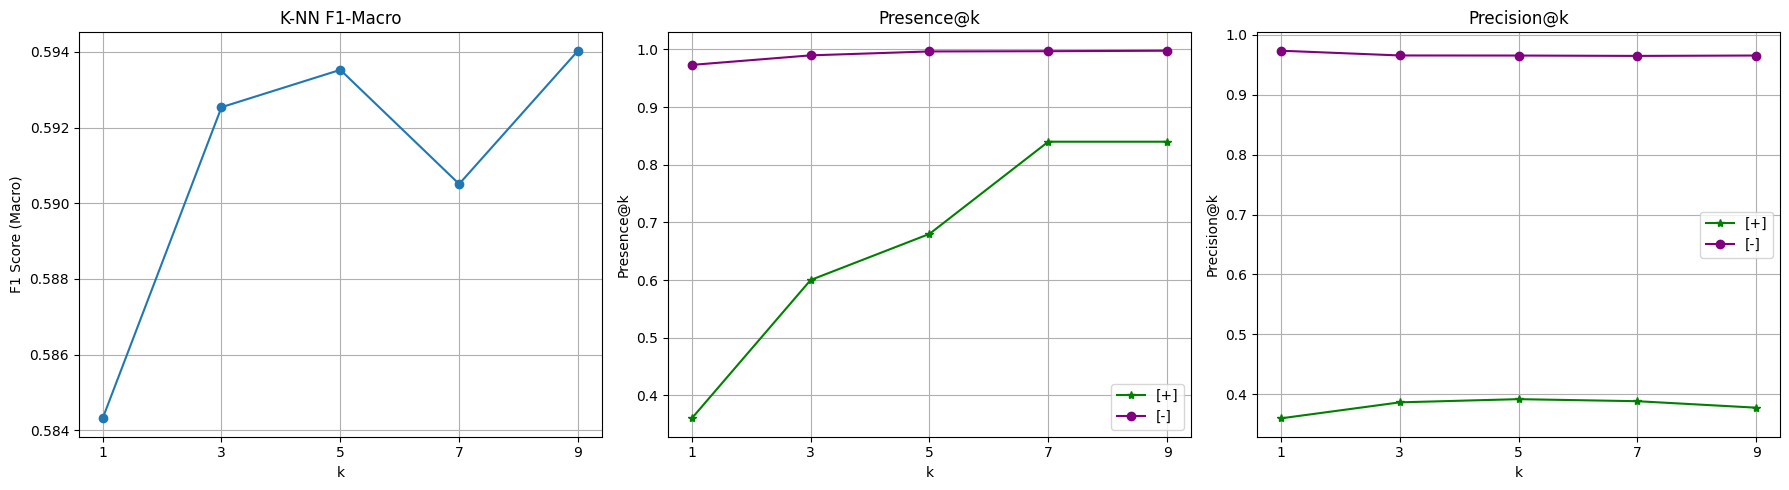

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
    K_0 = 0,
    C=2
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5843
Confusion Matrix:
[[2293   63]
 [  16    9]]
Precision(+)@k: 0.3600
Presence(+)@k: 0.3600
Precision(-)@k: 0.9733
Presence(-)@k: 0.9733

k=3
F1 Macro: 0.5925
Confusion Matrix:
[[2292   64]
 [  15   10]]
Precision(+)@k: 0.3867
Presence(+)@k: 0.6000
Precision(-)@k: 0.9653
Presence(-)@k: 0.9898

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9650
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9645
Presence(-)@k: 0.9970

k=9
F1 M

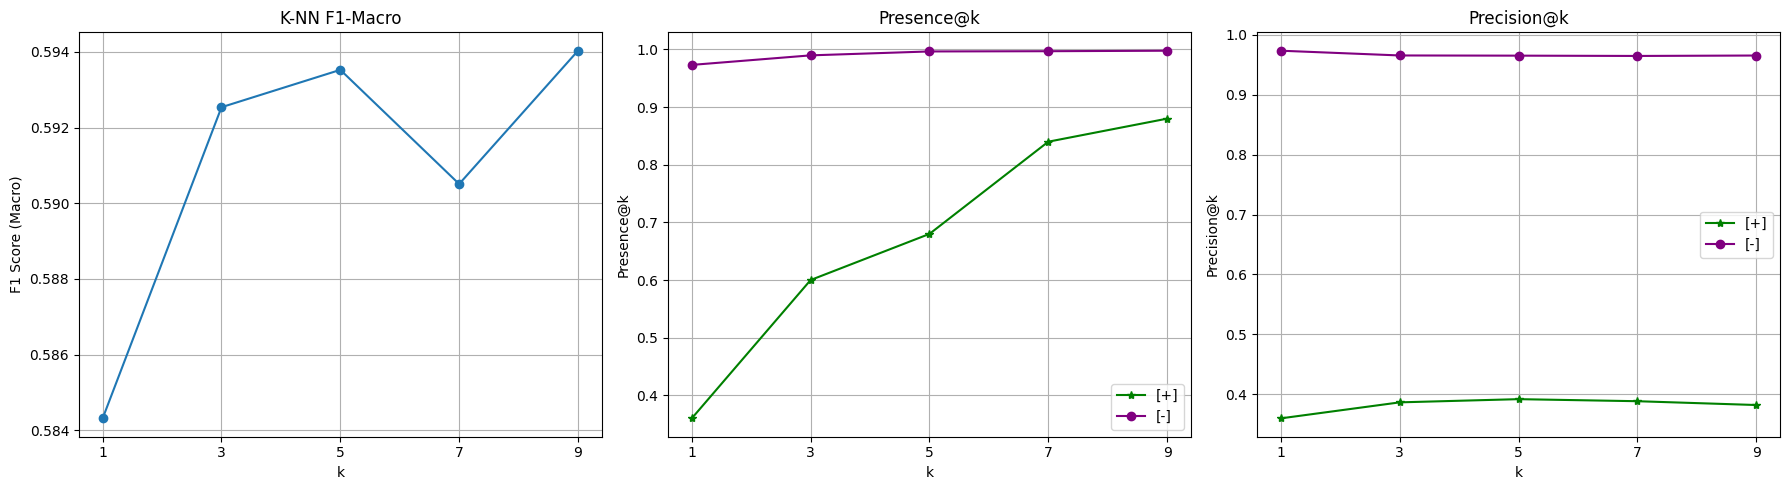

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,1),
    negative_distribution = "Uniform",
    K_0 = 0,
    C=2
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= UnifiedLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5794
Confusion Matrix:
[[2270   86]
 [  14   11]]
Precision(+)@k: 0.4400
Presence(+)@k: 0.4400
Precision(-)@k: 0.9635
Presence(-)@k: 0.9635

k=3
F1 Macro: 0.6007
Confusion Matrix:
[[2262   94]
 [  10   15]]
Precision(+)@k: 0.5200
Presence(+)@k: 0.6800
Precision(-)@k: 0.9513
Presence(-)@k: 0.9805

k=5
F1 Macro: 0.5845
Confusion Matrix:
[[2259   97]
 [  12   13]]
Precision(+)@k: 0.5280
Presence(+)@k: 0.8400
Precision(-)@k: 0.9495
Presence(-)@k: 0.9885

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5314
Presence(+)@k: 0.8400
Precision(-)@k: 0.9497
Presence(-)@k: 0.9928

k=9
F1 M

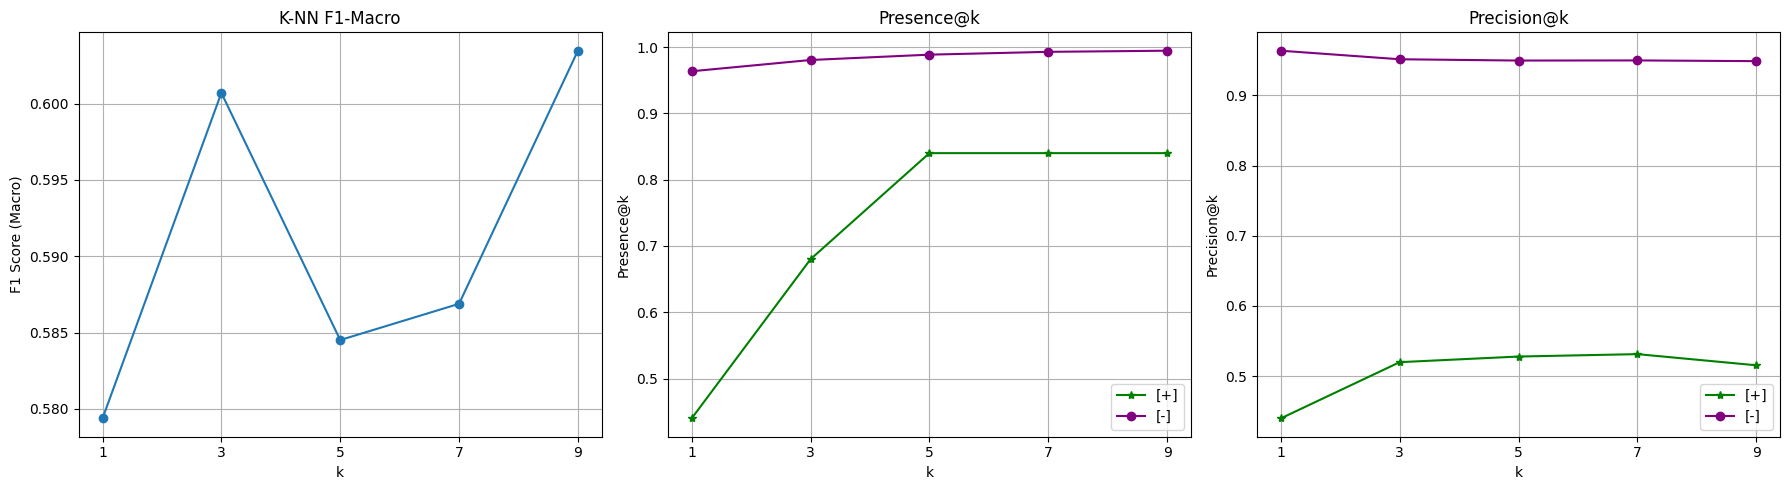

In [ ]:
evaluate_retrieval_system(
    UnifiedLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
    K_0 = 0,
    C=3
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=5)...
[INFO] Setting up FAISS indexes...

======= UnifiedLogRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776 -1.096 -0.523 -1.175]
  sigma: [2.912 1.895 1.496 1.071 0.984]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644 -3.39  -2.728 -2.245]
  upper = [8.435 4.006 3.927 2.638 1.855]

[INFO] Done!

k=1
F1 Macro: 0.5357
Confusion Matrix:
[[2077  279]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8816
Presence(-)@k: 0.8816

k=3
F1 Macro: 0.5655
Confusion Matrix:
[[2170  186]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9174
Presence(-)@k: 0.9495

k=5
F1 Macro: 0.5974
Confusion Matrix:
[[2237  119]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9406
Presence(-)@k: 0.9817

k=7
F1 Macro: 0.5926
Confusion Matrix:
[[2276   80]
 [  13   12]]
Precision(+)@k: 0.5371
P

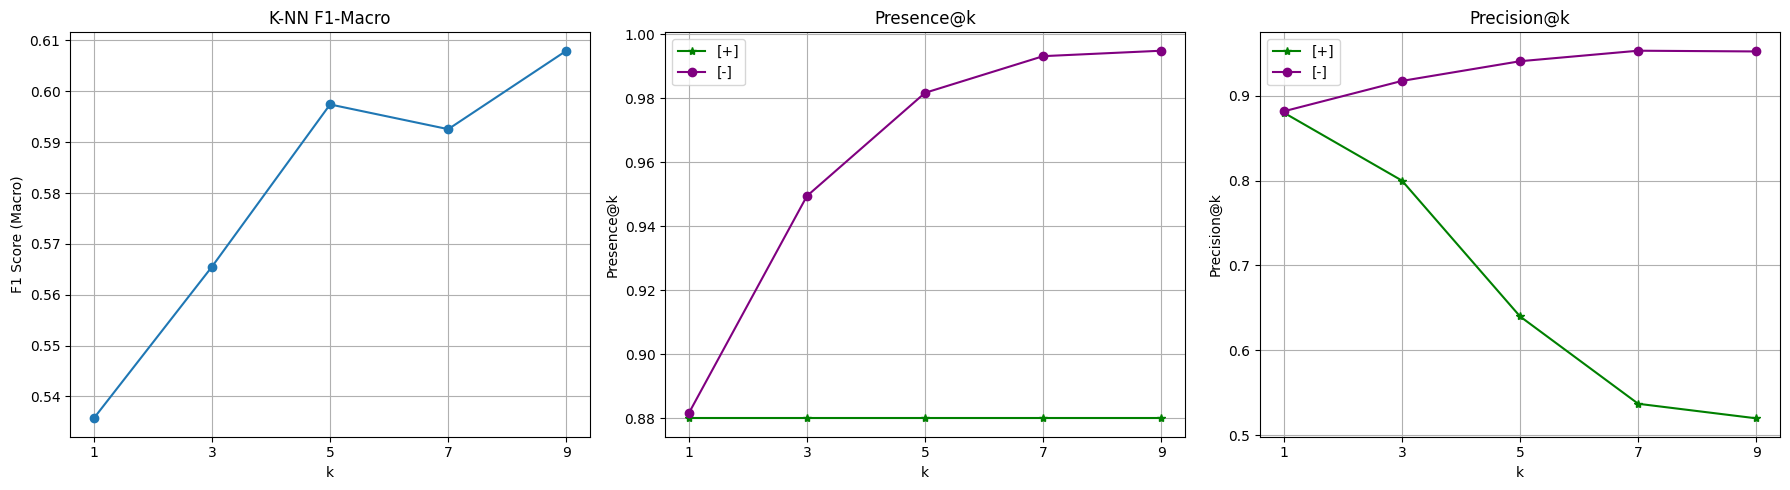

In [ ]:
evaluate_retrieval_system(
    UnifiedLogRetrievalSystem,data, k_vals=[1, 3, 5, 7, 9],
    theta=(1, 2),
    negative_distribution="Uniform",
    n_components=5,
)

### Positive Boost
$$f_\theta(p,q) = g(<p,q>)(1 + \alpha l\left(P(C+|q)[p \in C+]\right)$$

where $l: [0,1] → ℝ$

#### Unified

In [ ]:
class PositiveBoostRetrievalSystem(RetrievalSystem, ABC):
    def __init__(self, *args, alpha=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    @abstractmethod
    def g(self, dot_products):
        """Transform dot products via g(<p,q>)."""
        pass

    @abstractmethod
    def l(self, p_cpos_q: float):
        """Boost function applied to P(C+|q)."""
        pass

    def retrieve(self, query, top_k, show_bayesian=False, theta = (1,1), C=3, K_0=20):
        # Encode and transform
        query_emb = self.embedding_model.encode([query])[0].astype('float32').reshape(1, -1)
        query_pca = self.pca.transform(query_emb)[0]
        P_Cpos_q = self._posterior_probabilities(query_pca)["P(C+|x)"]

        # FAISS retrieval
        D, I = self.index_all.search(query_emb, max(top_k * C, K_0))
        candidates = self.db.iloc[I[0]].copy()
        candidates['dot_product'] = np.clip(D[0], 1e-6, None)

        # Compute g(<p,q>) and boosting term
        g_values = self.g(candidates['dot_product'].values)
        boost_val = self.l(P_Cpos_q)

        is_positive = candidates[self.label_col].values.astype(bool)
        boost_factors = theta[0] + theta[1] * boost_val * is_positive

        # Final scoring
        candidates['score'] = g_values * boost_factors
        candidates['P(C+|x)'] = P_Cpos_q

        results = candidates.sort_values(by='score', ascending=False).head(top_k).reset_index(drop=True)

        if show_bayesian:
            print("\n[Bayesian Probability]")
            print(f"P(C+|x) = {P_Cpos_q:.4f}")

        return results

    def __call__(self, query, top_k, show_bayesian=False, theta=(1, 1),C=3,K_0=20):
        return self.retrieve(query, top_k, show_bayesian, theta, C=C,K_0=K_0)


In [ ]:
class PosBoost_LinearG_LinearL(PositiveBoostRetrievalSystem):
    def g(self, dot_products):
        return dot_products

    def l(self, p_cpos_q):
        return p_cpos_q

class PosBoost_LinearG_LogL(PositiveBoostRetrievalSystem):
    def g(self, dot_products):
        return dot_products

    def l(self, p_cpos_q):
        return -np.log(np.clip(p_cpos_q, 1e-6, 1.0))


class PosBoost_LogG_LinearL(PositiveBoostRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))

    def l(self, p_cpos_q):
        return p_cpos_q

class PosBoost_LogG_LogL(PositiveBoostRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))

    def l(self, p_cpos_q):
        return -np.log(np.clip(p_cpos_q, 1e-6, None))



[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5187
Confusion Matrix:
[[2020  336]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8574
Presence(-)@k: 0.8574

k=3
F1 Macro: 0.5580
Confusion Matrix:
[[2154  202]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9056
Presence(-)@k: 0.9457

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9328
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9466
Presence(-)@k: 0.9928

k=9
F1 Macro

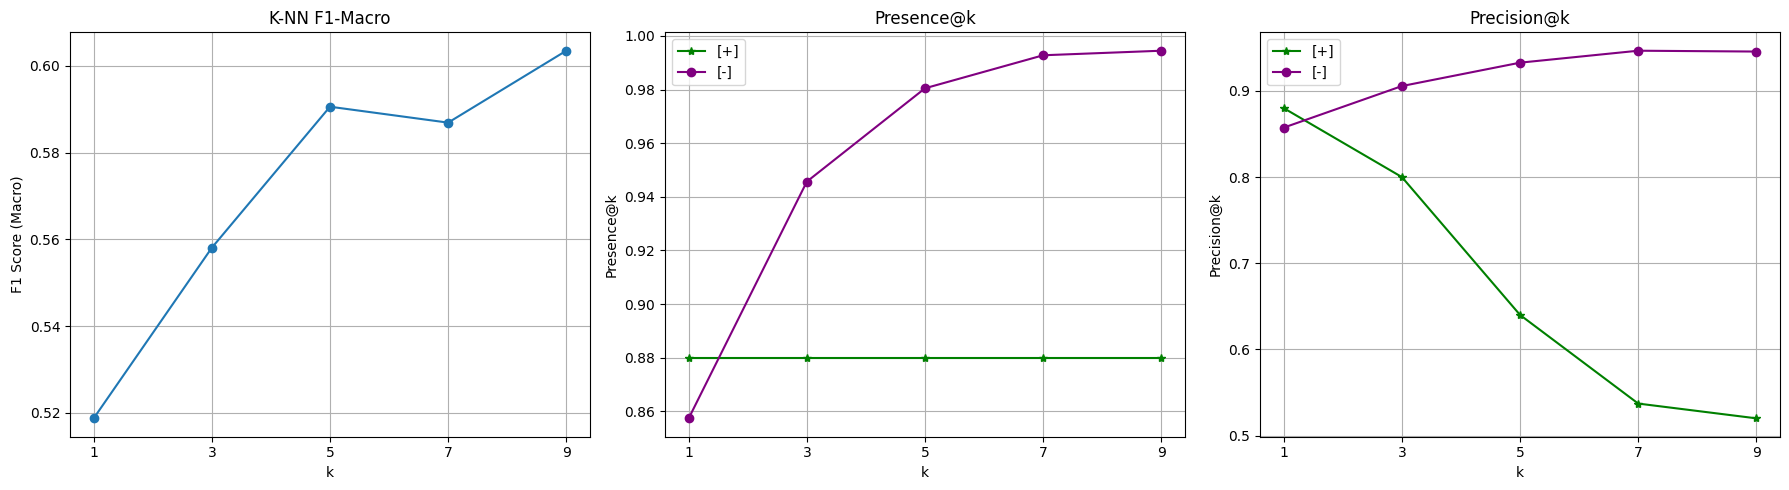

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform")


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5204
Confusion Matrix:
[[2026  330]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8599
Presence(-)@k: 0.8599

k=3
F1 Macro: 0.5589
Confusion Matrix:
[[2156  200]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9069
Presence(-)@k: 0.9469

k=5
F1 Macro: 0.5920
Confusion Matrix:
[[2230  126]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9333
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9468
Presence(-)@k: 0.9928

k=9
F1 Macro

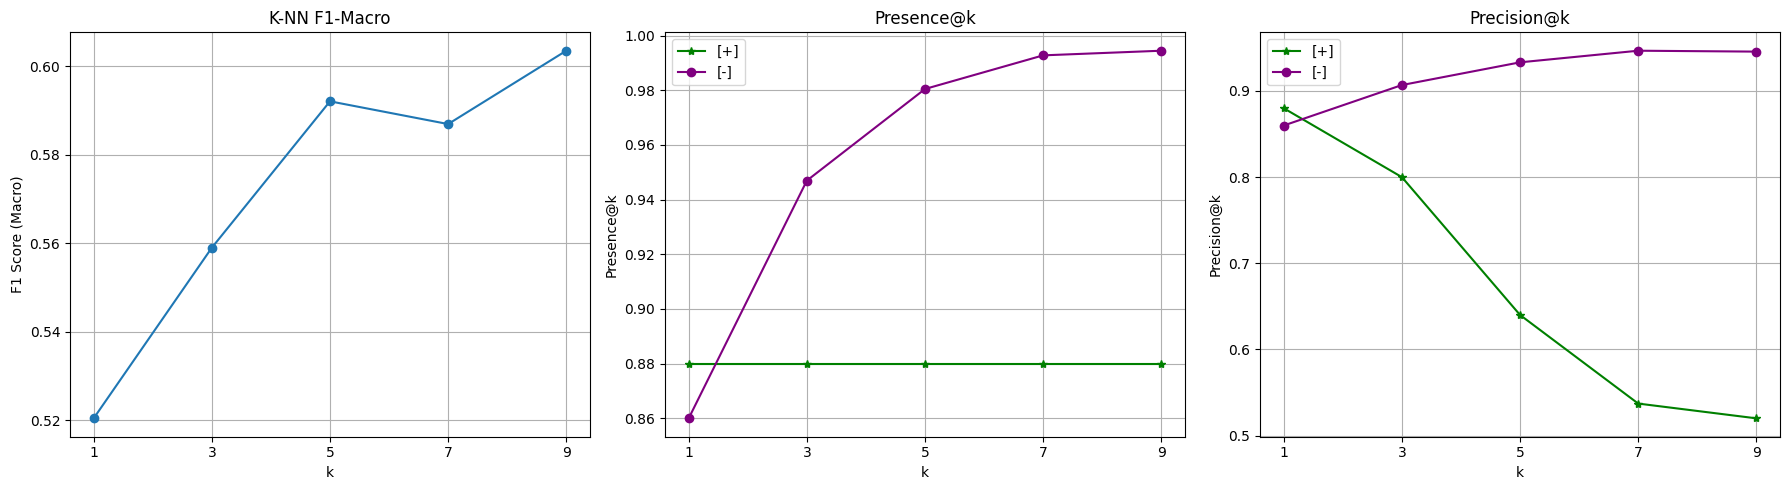

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform", theta = (1,0.33))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5370
Confusion Matrix:
[[2129  227]
 [   8   17]]
Precision(+)@k: 0.6800
Presence(+)@k: 0.6800
Precision(-)@k: 0.9037
Presence(-)@k: 0.9037

k=3
F1 Macro: 0.5894
Confusion Matrix:
[[2249  107]
 [  10   15]]
Precision(+)@k: 0.5467
Presence(+)@k: 0.6800
Precision(-)@k: 0.9448
Presence(-)@k: 0.9767

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9638
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9631
Presence(-)@k: 0.9970

k=9
F1 Macro

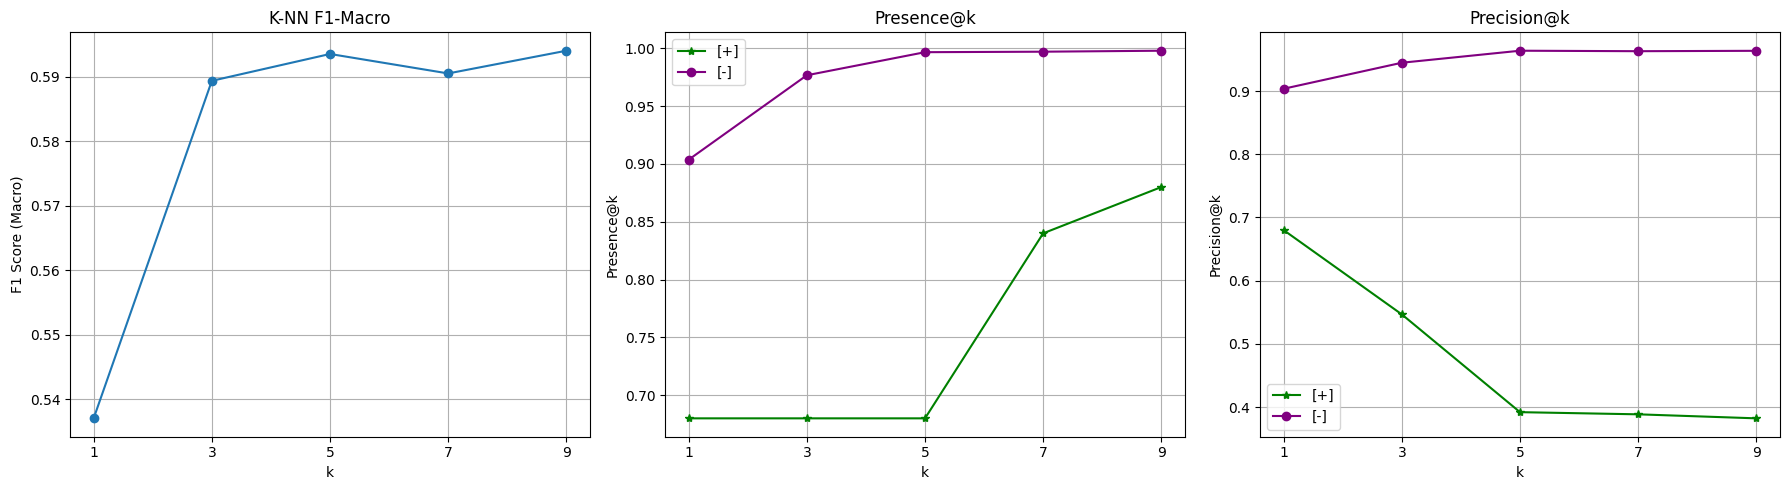

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform", theta = (1,0.33),K_0=10,C=2)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5833
Confusion Matrix:
[[2292   64]
 [  16    9]]
Precision(+)@k: 0.3600
Presence(+)@k: 0.3600
Precision(-)@k: 0.9728
Presence(-)@k: 0.9728

k=3
F1 Macro: 0.5914
Confusion Matrix:
[[2291   65]
 [  15   10]]
Precision(+)@k: 0.3867
Presence(+)@k: 0.6000
Precision(-)@k: 0.9641
Presence(-)@k: 0.9898

k=5
F1 Macro: 0.5935
Confusion Matrix:
[[2301   55]
 [  16    9]]
Precision(+)@k: 0.3920
Presence(+)@k: 0.6800
Precision(-)@k: 0.9638
Presence(-)@k: 0.9966

k=7
F1 Macro: 0.5905
Confusion Matrix:
[[2307   49]
 [  17    8]]
Precision(+)@k: 0.3886
Presence(+)@k: 0.8400
Precision(-)@k: 0.9631
Presence(-)@k: 0.9970

k=9
F1 Macro

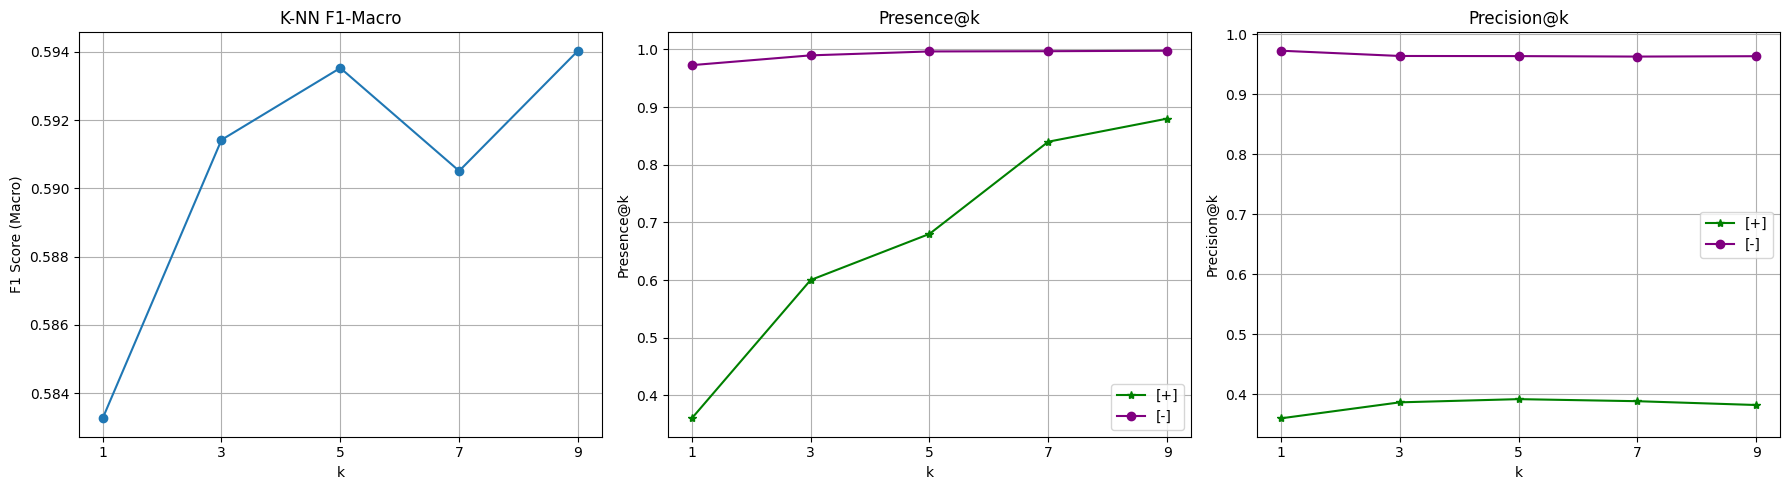

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform", theta = (1,0.33),K_0=0,C=2)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5753
Confusion Matrix:
[[2265   91]
 [  14   11]]
Precision(+)@k: 0.4400
Presence(+)@k: 0.4400
Precision(-)@k: 0.9614
Presence(-)@k: 0.9614

k=3
F1 Macro: 0.5998
Confusion Matrix:
[[2261   95]
 [  10   15]]
Precision(+)@k: 0.5200
Presence(+)@k: 0.6800
Precision(-)@k: 0.9501
Presence(-)@k: 0.9805

k=5
F1 Macro: 0.5837
Confusion Matrix:
[[2258   98]
 [  12   13]]
Precision(+)@k: 0.5360
Presence(+)@k: 0.8800
Precision(-)@k: 0.9469
Presence(-)@k: 0.9881

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9468
Presence(-)@k: 0.9928

k=9
F1 Macro

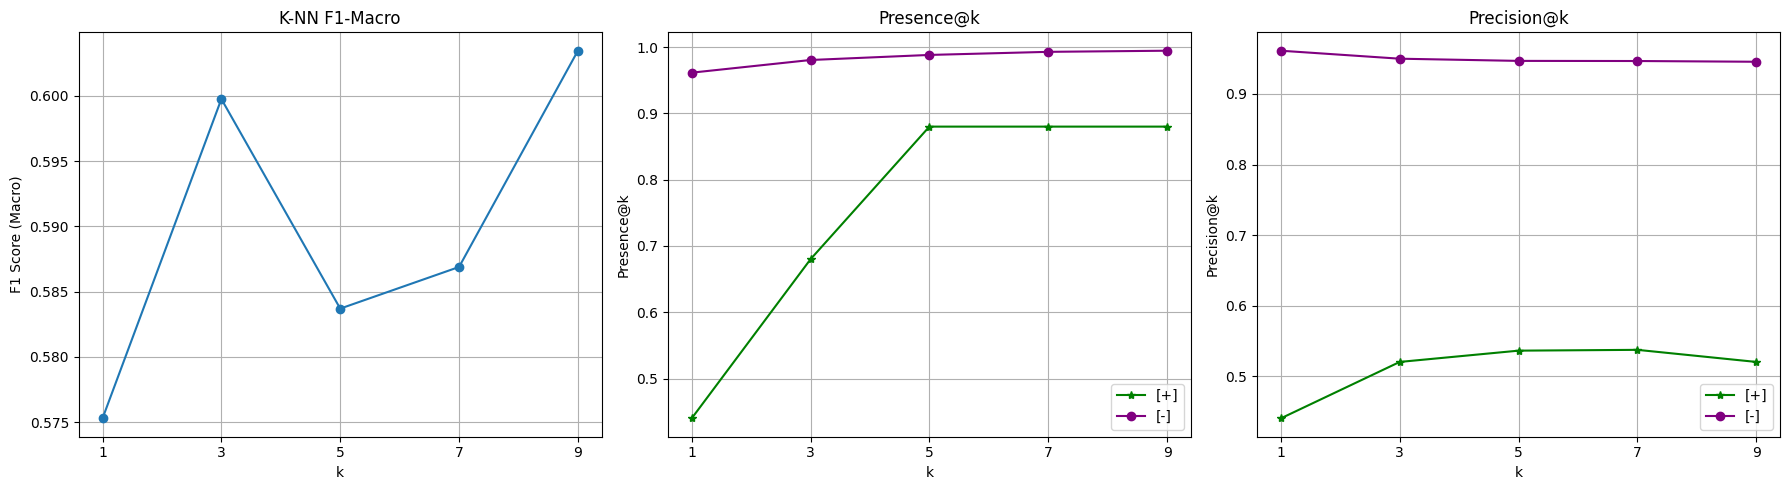

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform", theta = (1,0.33),K_0=0,C=3)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5235
Confusion Matrix:
[[2066  290]
 [   6   19]]
Precision(+)@k: 0.7600
Presence(+)@k: 0.7600
Precision(-)@k: 0.8769
Presence(-)@k: 0.8769

k=3
F1 Macro: 0.5647
Confusion Matrix:
[[2194  162]
 [   8   17]]
Precision(+)@k: 0.6667
Presence(+)@k: 0.8000
Precision(-)@k: 0.9213
Presence(-)@k: 0.9597

k=5
F1 Macro: 0.5879
Confusion Matrix:
[[2255  101]
 [  11   14]]
Precision(+)@k: 0.4960
Presence(+)@k: 0.8000
Precision(-)@k: 0.9423
Presence(-)@k: 0.9868

k=7
F1 Macro: 0.5802
Confusion Matrix:
[[2289   67]
 [  16    9]]
Precision(+)@k: 0.4229
Presence(+)@k: 0.8800
Precision(-)@k: 0.9534
Presence(-)@k: 0.9958

k=9
F1 Macro: 0

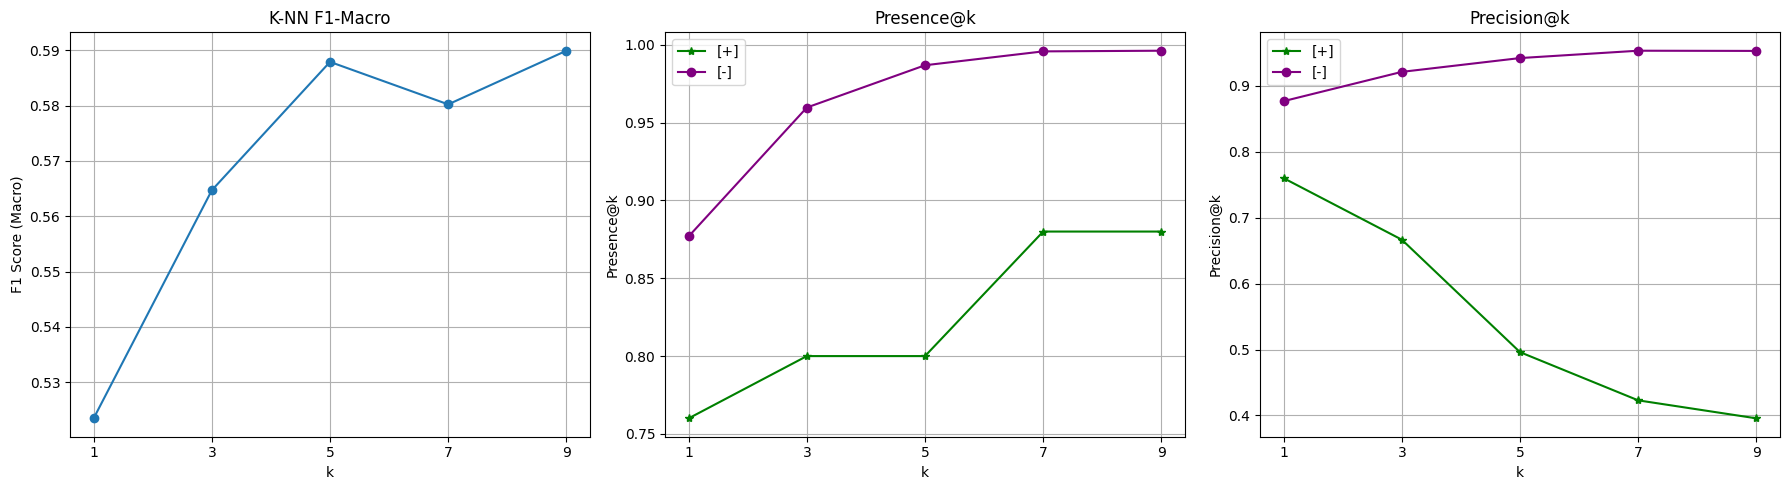

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LogL,data,negative_distribution = "Uniform")


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5240
Confusion Matrix:
[[2068  288]
 [   6   19]]
Precision(+)@k: 0.7600
Presence(+)@k: 0.7600
Precision(-)@k: 0.8778
Presence(-)@k: 0.8778

k=3
F1 Macro: 0.5657
Confusion Matrix:
[[2196  160]
 [   8   17]]
Precision(+)@k: 0.6667
Presence(+)@k: 0.8000
Precision(-)@k: 0.9223
Presence(-)@k: 0.9605

k=5
F1 Macro: 0.5904
Confusion Matrix:
[[2258   98]
 [  11   14]]
Precision(+)@k: 0.4960
Presence(+)@k: 0.8000
Precision(-)@k: 0.9430
Presence(-)@k: 0.9868

k=7
F1 Macro: 0.5802
Confusion Matrix:
[[2289   67]
 [  16    9]]
Precision(+)@k: 0.4229
Presence(+)@k: 0.8800
Precision(-)@k: 0.9537
Presence(-)@k: 0.9958

k=9
F1 Macro: 0

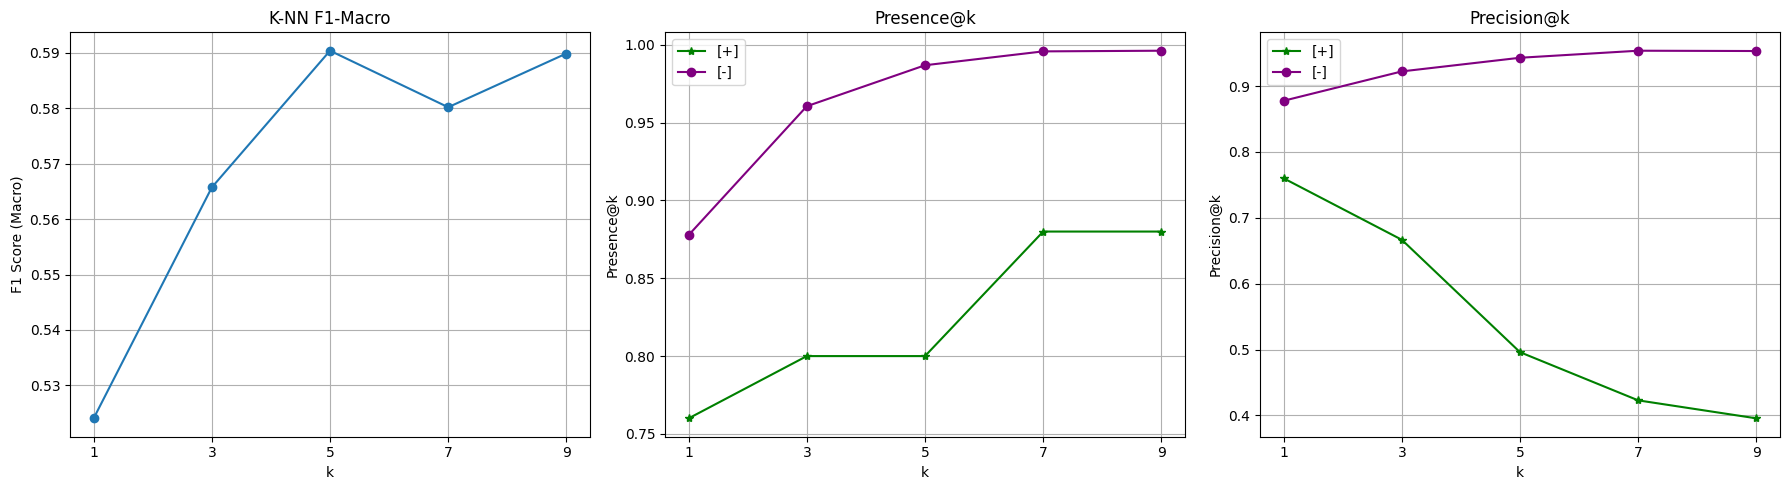

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LogL,data,negative_distribution = "Uniform", theta = (1,0.33))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5185
Confusion Matrix:
[[2019  337]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8570
Presence(-)@k: 0.8570

k=3
F1 Macro: 0.5580
Confusion Matrix:
[[2154  202]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9056
Presence(-)@k: 0.9457

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9328
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9466
Presence(-)@k: 0.9928

k=9
F1 Macro

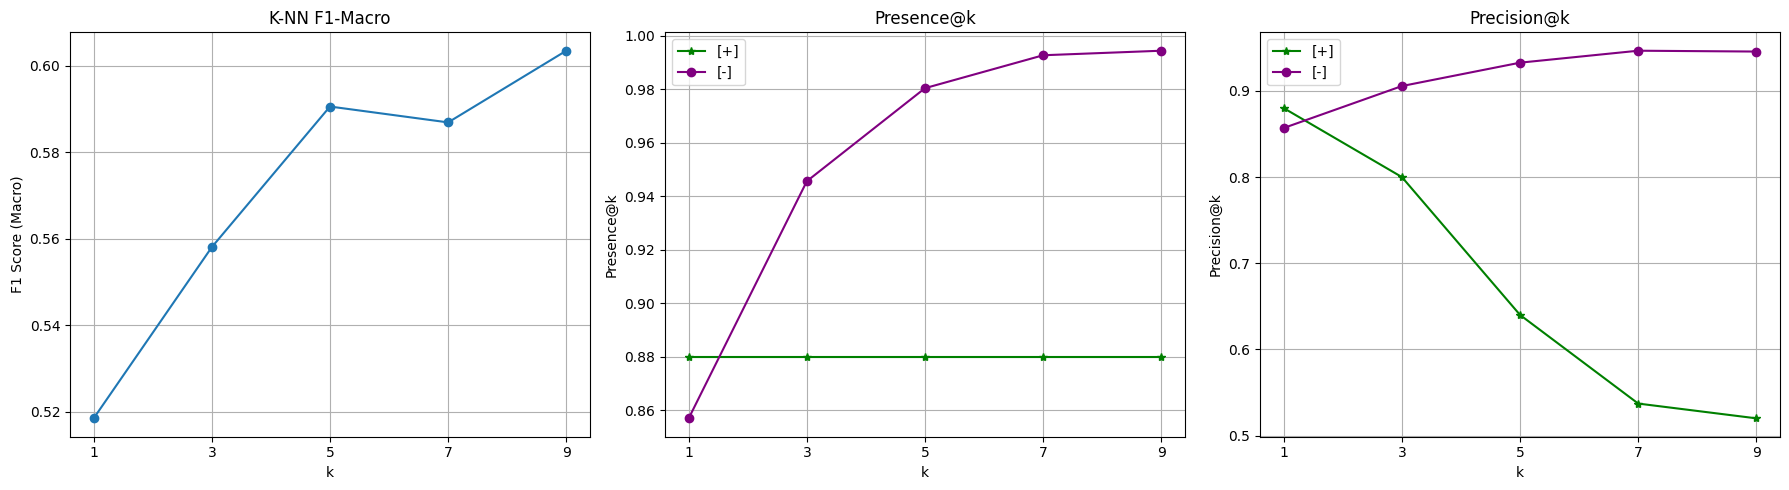

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LinearL,data,negative_distribution = "Uniform", theta = (1,2))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.5229
Confusion Matrix:
[[2064  292]
 [   6   19]]
Precision(+)@k: 0.7600
Presence(+)@k: 0.7600
Precision(-)@k: 0.8761
Presence(-)@k: 0.8761

k=3
F1 Macro: 0.5636
Confusion Matrix:
[[2192  164]
 [   8   17]]
Precision(+)@k: 0.6667
Presence(+)@k: 0.8000
Precision(-)@k: 0.9206
Presence(-)@k: 0.9588

k=5
F1 Macro: 0.5871
Confusion Matrix:
[[2254  102]
 [  11   14]]
Precision(+)@k: 0.4960
Presence(+)@k: 0.8000
Precision(-)@k: 0.9421
Presence(-)@k: 0.9868

k=7
F1 Macro: 0.5802
Confusion Matrix:
[[2289   67]
 [  16    9]]
Precision(+)@k: 0.4229
Presence(+)@k: 0.8800
Precision(-)@k: 0.9534
Presence(-)@k: 0.9958

k=9
F1 Macro: 0

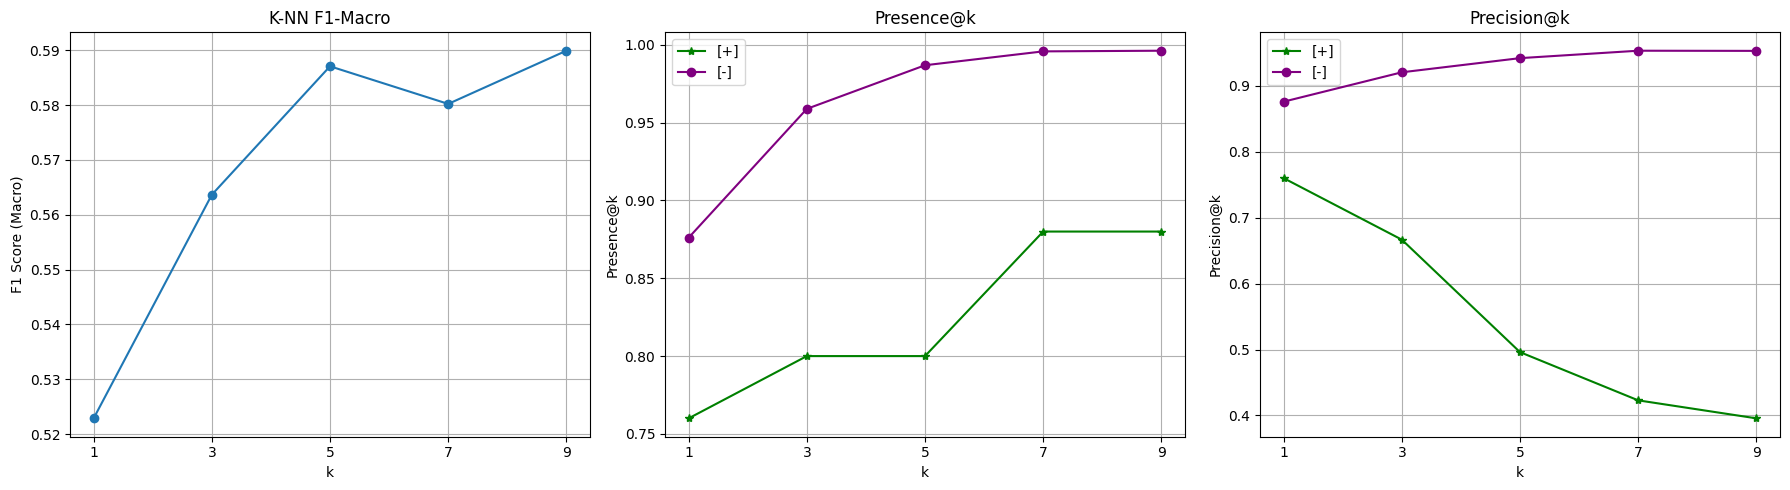

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LogL,data,negative_distribution = "Uniform", theta = (1,2))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoost_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.5185
Confusion Matrix:
[[2019  337]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.8570
Presence(-)@k: 0.8570

k=3
F1 Macro: 0.5585
Confusion Matrix:
[[2155  201]
 [   5   20]]
Precision(+)@k: 0.8000
Presence(+)@k: 0.8800
Precision(-)@k: 0.9058
Presence(-)@k: 0.9461

k=5
F1 Macro: 0.5906
Confusion Matrix:
[[2228  128]
 [   7   18]]
Precision(+)@k: 0.6400
Presence(+)@k: 0.8800
Precision(-)@k: 0.9327
Presence(-)@k: 0.9805

k=7
F1 Macro: 0.5869
Confusion Matrix:
[[2270   86]
 [  13   12]]
Precision(+)@k: 0.5371
Presence(+)@k: 0.8800
Precision(-)@k: 0.9466
Presence(-)@k: 0.9928

k=9
F1 Macro: 0.6035
Confusion Matrix:
[[2279   77]
 [

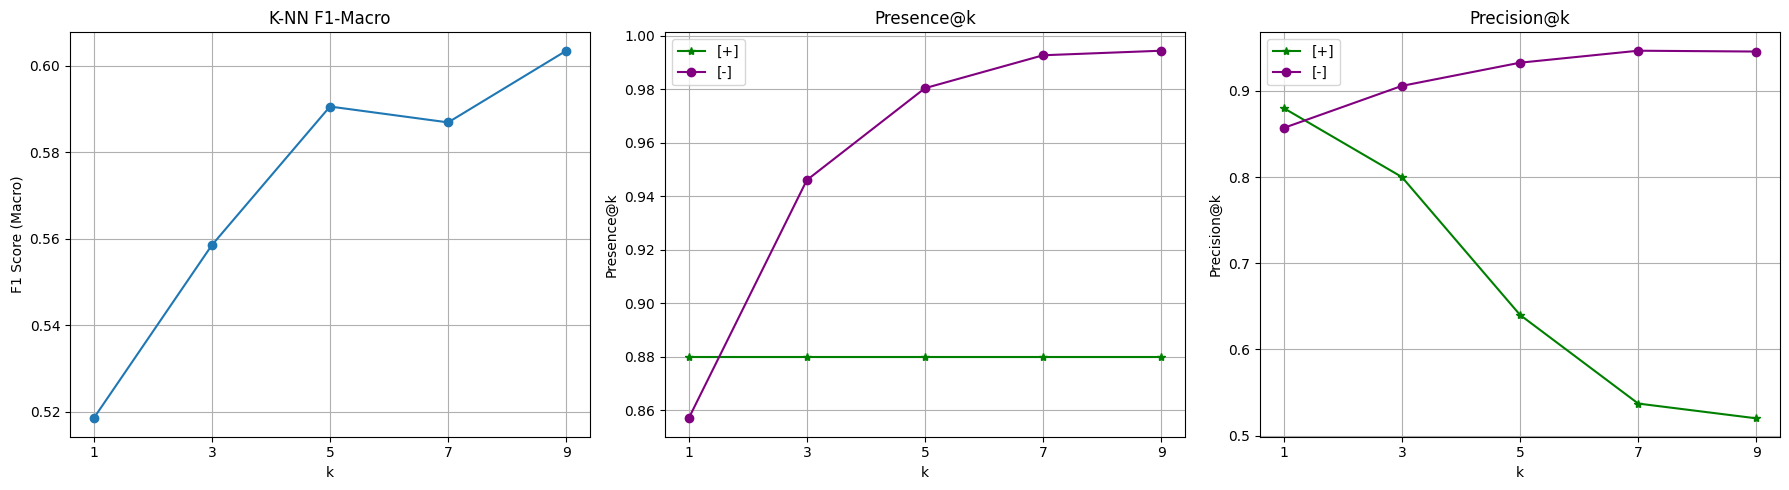

In [ ]:
evaluate_retrieval_system(PosBoost_LinearG_LogL,data)

#### Split


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.4255
Confusion Matrix:
[[1574  782]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6681
Presence(-)@k: 0.6681

k=3
F1 Macro: 0.4337
Confusion Matrix:
[[1619  737]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6829
Presence(-)@k: 0.7088

k=5
F1 Macro: 0.4387
Confusion Matrix:
[[1646  710]
 [   4   21]]
Precision(+)@k: 0.8320
Presence(+)@k: 0.8400
Precision(-)@k: 0.6902
Presence(-)@k: 0.7186

k=7
F1 Macro: 0.4394
Confusion Matrix:
[[1650  706]
 [   4   21]]
Precision(+)@k: 0.8286
Presence(+)@k: 0.8400
Precision(-)@k: 0.6940
Presence(-)@k: 0.7271

k=9
F1 Mac

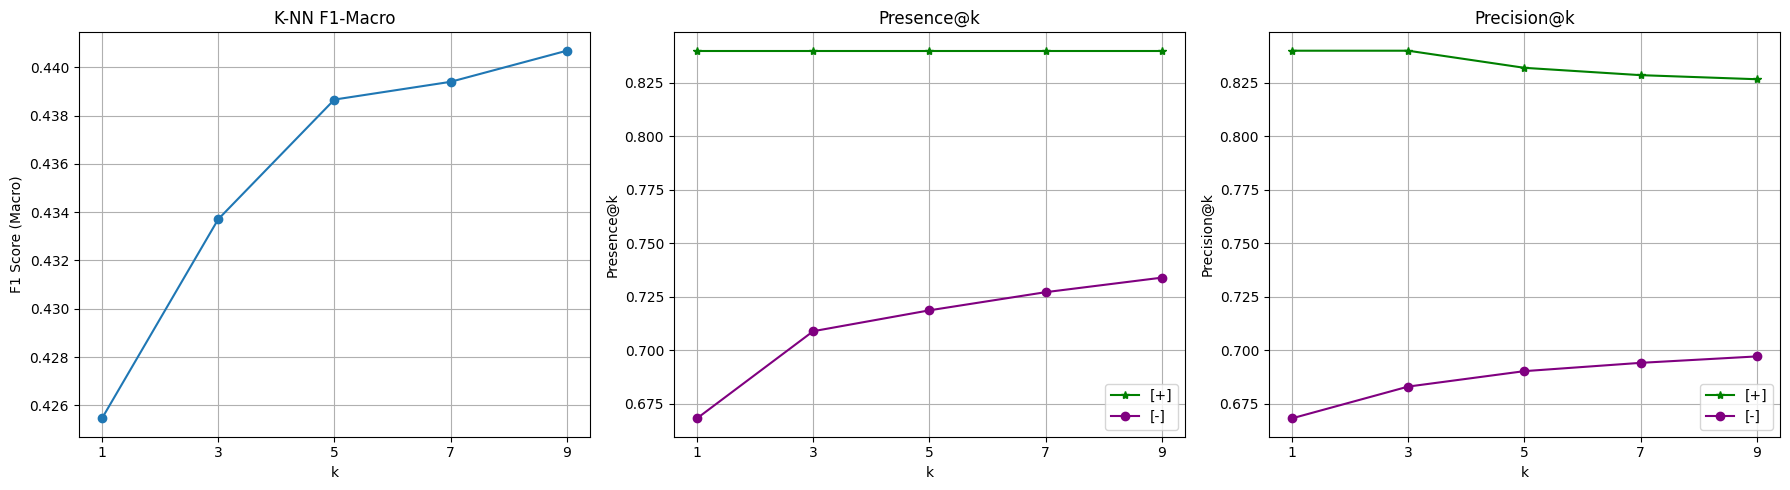

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,
    data,
    theta=(1,0.2),
    negative_distribution = "Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.4099
Confusion Matrix:
[[1489  867]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6320
Presence(-)@k: 0.6320

k=3
F1 Macro: 0.4106
Confusion Matrix:
[[1493  863]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6361
Presence(-)@k: 0.6520

k=5
F1 Macro: 0.4123
Confusion Matrix:
[[1502  854]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6413
Presence(-)@k: 0.6719

k=7
F1 Macro: 0.4137
Confusion Matrix:
[[1510  846]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6504
Presence(-)@k: 0.6931

k=9
F1 Mac

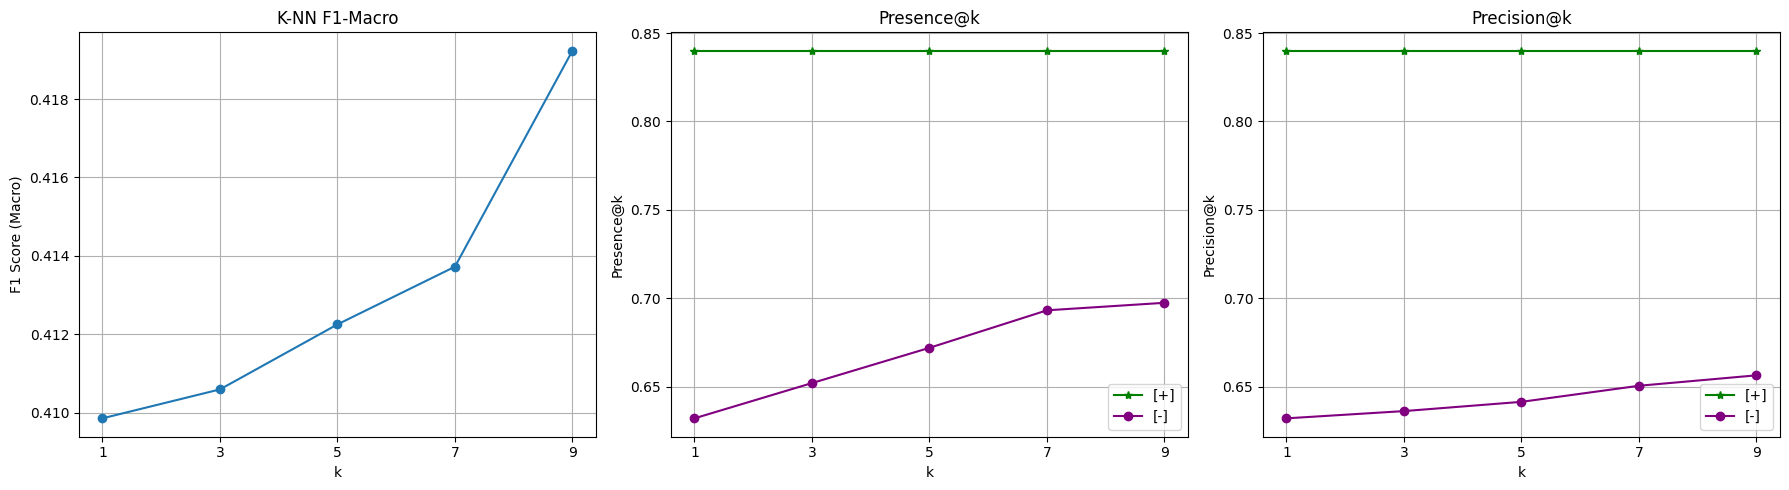

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.4099
Confusion Matrix:
[[1489  867]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6320
Presence(-)@k: 0.6320

k=3
F1 Macro: 0.4106
Confusion Matrix:
[[1493  863]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6361
Presence(-)@k: 0.6520

k=5
F1 Macro: 0.4123
Confusion Matrix:
[[1502  854]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6413
Presence(-)@k: 0.6719

k=7
F1 Macro: 0.4137
Confusion Matrix:
[[1510  846]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6504
Presence(-)@k: 0.6931

k=9
F1 Mac

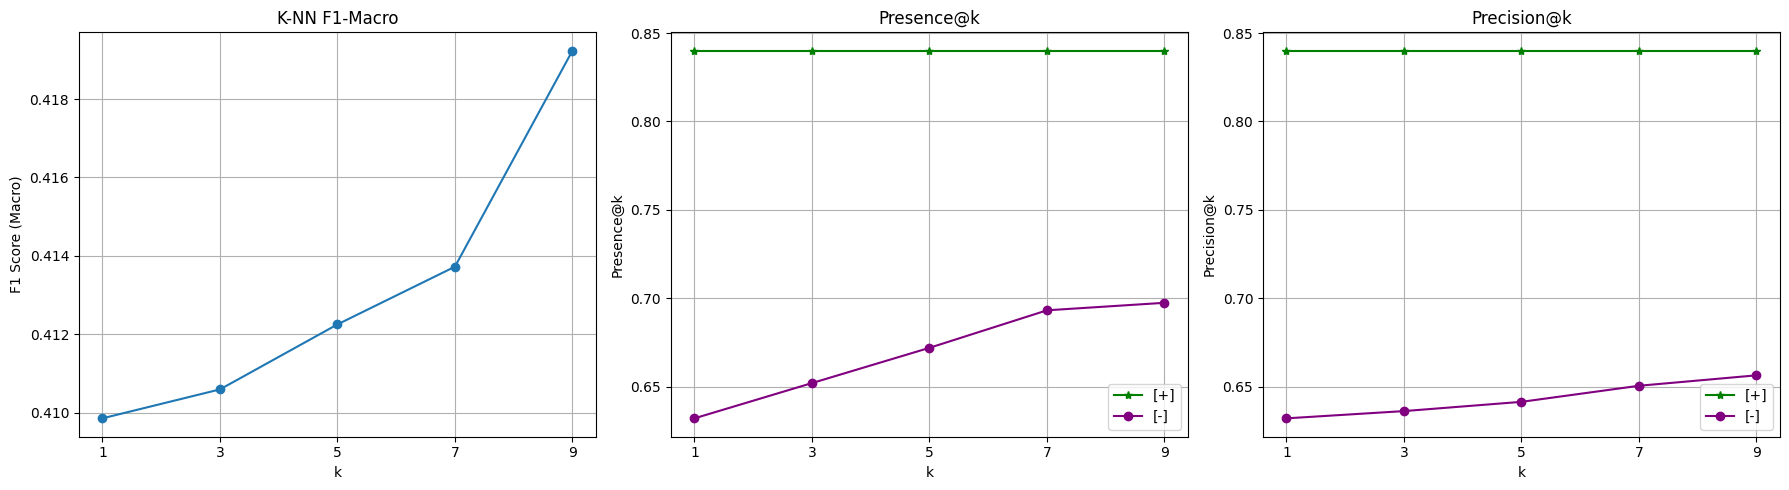

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,
    data,
    theta=(1,0.33),
    negative_distribution = "Uniform",
    K_0 = 10,
    C=2,
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.4036
Confusion Matrix:
[[1455  901]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6176
Presence(-)@k: 0.6176

k=3
F1 Macro: 0.4041
Confusion Matrix:
[[1458  898]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6184
Presence(-)@k: 0.6273

k=5
F1 Macro: 0.4043
Confusion Matrix:
[[1459  897]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.6195
Presence(-)@k: 0.6337

k=7
F1 Macro: 0.4050
Confusion Matrix:
[[1463  893]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 0.8800
Precision(-)@k: 0.6265
Presence(-)@k: 0.6643

k=9
F1 Mac

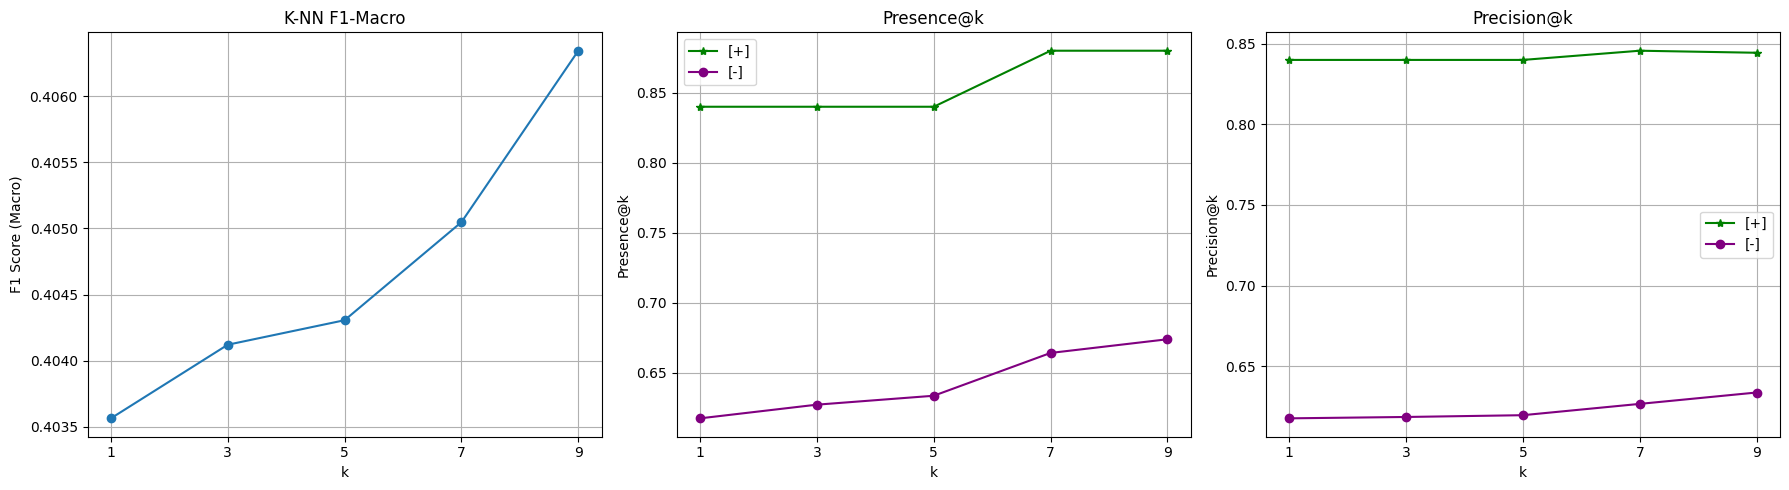

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,
    data,
    theta=(1,0.5),
    negative_distribution = "Uniform",
)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= SplitLinearRetrievalSystem Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.3914
Confusion Matrix:
[[1390  966]
 [   4   21]]
Precision(+)@k: 0.8400
Presence(+)@k: 0.8400
Precision(-)@k: 0.5900
Presence(-)@k: 0.5900

k=3
F1 Macro: 0.3931
Confusion Matrix:
[[1399  957]
 [   4   21]]
Precision(+)@k: 0.8533
Presence(+)@k: 0.8800
Precision(-)@k: 0.5932
Presence(-)@k: 0.5976

k=5
F1 Macro: 0.3927
Confusion Matrix:
[[1397  959]
 [   4   21]]
Precision(+)@k: 0.8480
Presence(+)@k: 0.8800
Precision(-)@k: 0.5935
Presence(-)@k: 0.5993

k=7
F1 Macro: 0.3937
Confusion Matrix:
[[1402  954]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 0.8800
Precision(-)@k: 0.5940
Presence(-)@k: 0.6019

k=9
F1 Mac

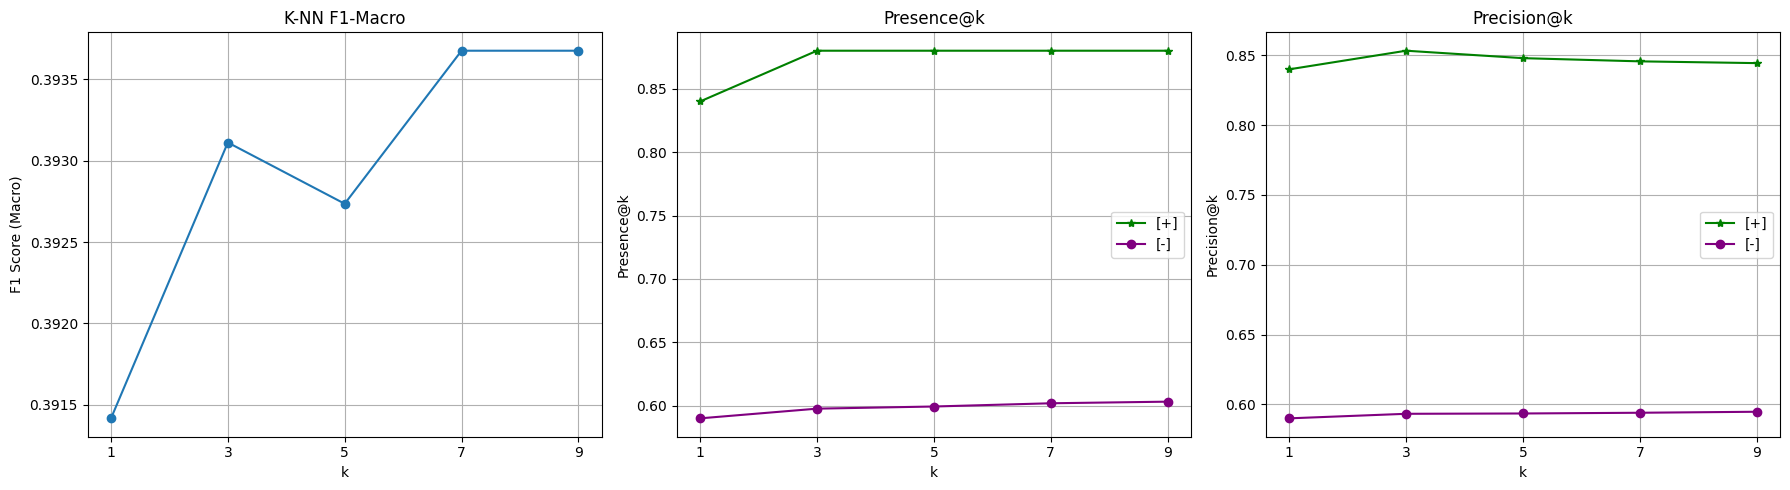

In [ ]:
evaluate_retrieval_system(
    SplitLinearRetrievalSystem,
    data,
    theta=(1,2),
    negative_distribution = "Uniform",
)

In [ ]:
class PositiveBoostSplitRetrievalSystem(RetrievalSystem, ABC):
    def __init__(self, *args, alpha=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    @abstractmethod
    def g(self, dot_products):
        """Transform dot products via g(<p,q>)."""
        pass

    @abstractmethod
    def l(self, p_cpos_q: float):
        """Boost function applied to P(C+|q)."""
        pass

    def retrieve(self, query, top_k, show_bayesian=False, theta=(1, 1), C=-1, K_0=-1):
        a, b = theta

        # Encode query and PCA projection
        query_emb = self.embedding_model.encode([query])[0].astype('float32').reshape(1, -1)
        query_pca = self.pca.transform(query_emb)[0]
        P_Cpos_q = self._posterior_probabilities(query_pca)["P(C+|x)"]

        # Retrieve positives and negatives separately
        D_pos, I_pos = self.index_pos.search(query_emb, top_k)
        D_neg, I_neg = self.index_neg.search(query_emb, top_k)

        pos_candidates = self.db_pos.iloc[I_pos[0]].copy()
        neg_candidates = self.db_neg.iloc[I_neg[0]].copy()

        pos_candidates['dot_product'] = D_pos[0]
        neg_candidates['dot_product'] = D_neg[0]

        # Apply g transformation
        g_pos = self.g(D_pos[0])
        g_neg = self.g(D_neg[0])

        # Compute boost value from posterior probability
        boost_val = self.l(P_Cpos_q)

        # Compute scores with boost applied ONLY to positives
        pos_candidates['score'] = g_pos * (a + b * self.alpha * boost_val)
        neg_candidates['score'] = g_neg * (a + b * 0)  # no boost for negatives

        # Combine and select top_k
        combined = pd.concat([pos_candidates, neg_candidates])
        results = combined.sort_values(by='score', ascending=False).head(top_k).reset_index(drop=True)
        results['P(C+|x)'] = P_Cpos_q

        if show_bayesian:
            print("\n[Bayesian Probability]")
            print(f"P(C+|x) = {P_Cpos_q:.4f}")

        return results

    def __call__(self, query, top_k, show_bayesian=False, theta=(1, 1),C=-1,K_0=-1):
        return self.retrieve(query, top_k, show_bayesian, theta)


In [ ]:
class PosBoostSplit_LinearG_LinearL(PositiveBoostSplitRetrievalSystem):
    def g(self, dot_products):
        return dot_products

    def l(self, p_cpos_q):
        return p_cpos_q

class PosBoostSplit_LinearG_LogL(PositiveBoostSplitRetrievalSystem):
    def g(self, dot_products):
        return dot_products

    def l(self, p_cpos_q):
        return -np.log(np.clip(p_cpos_q, 1e-6, 1.0))

class PosBoostSplit_LogG_LinearL(PositiveBoostSplitRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))

    def l(self, p_cpos_q):
        return p_cpos_q

class PosBoostSplit_LogG_LogL(PositiveBoostSplitRetrievalSystem):
    def g(self, dot_products):
        return np.log(np.clip(dot_products, 1e-6, None))

    def l(self, p_cpos_q):
        return -np.log(np.clip(p_cpos_q, 1e-6, None))



[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.2203
Confusion Matrix:
[[ 615 1741]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.2610
Presence(-)@k: 0.2610

k=3
F1 Macro: 0.2378
Confusion Matrix:
[[ 680 1676]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.2823
Presence(-)@k: 0.3086

k=5
F1 Macro: 0.2444
Confusion Matrix:
[[ 705 1651]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.2919
Presence(-)@k: 0.3217

k=7
F1 Macro: 0.2469
Confusion Matrix:
[[ 715 1641]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.2972
Presence(-)@k: 0.3277

k=9
F1 

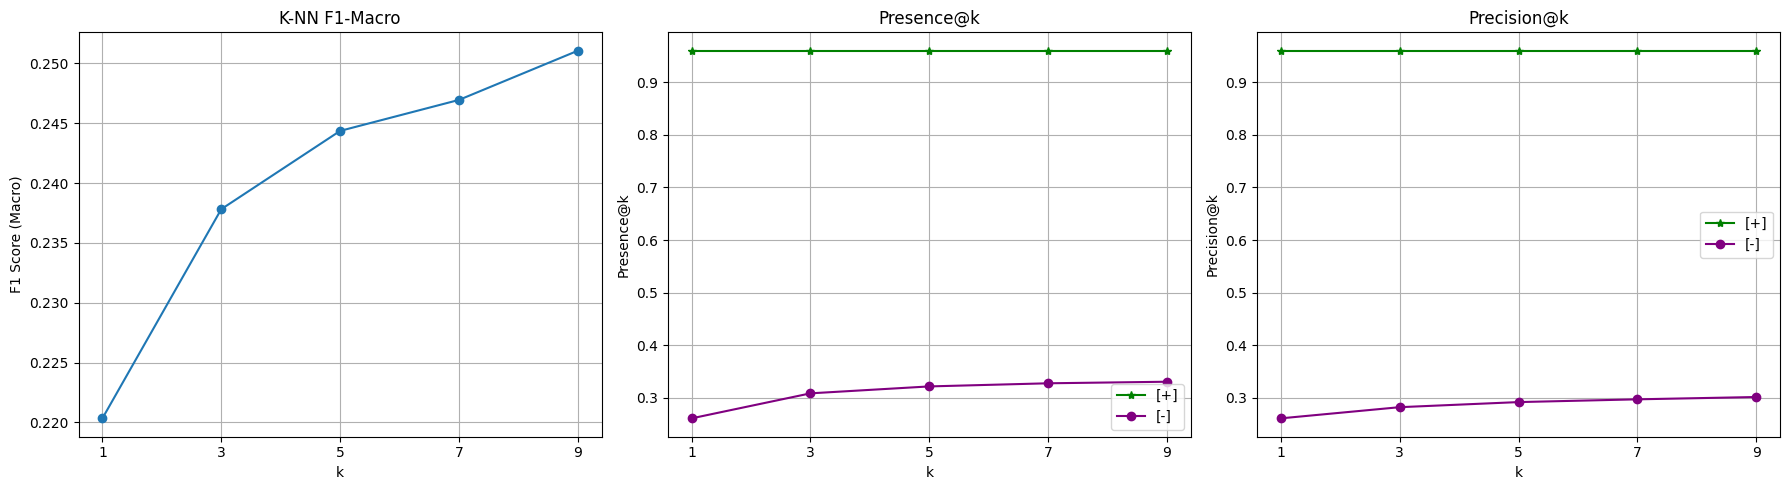

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LinearL,data,negative_distribution = "Uniform")


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.2923
Confusion Matrix:
[[ 900 1456]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3820
Presence(-)@k: 0.3820

k=3
F1 Macro: 0.3017
Confusion Matrix:
[[ 941 1415]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3946
Presence(-)@k: 0.4228

k=5
F1 Macro: 0.3078
Confusion Matrix:
[[ 968 1388]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.4052
Presence(-)@k: 0.4465

k=7
F1 Macro: 0.3114
Confusion Matrix:
[[ 984 1372]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.4158
Presence(-)@k: 0.4669

k=9
F1 

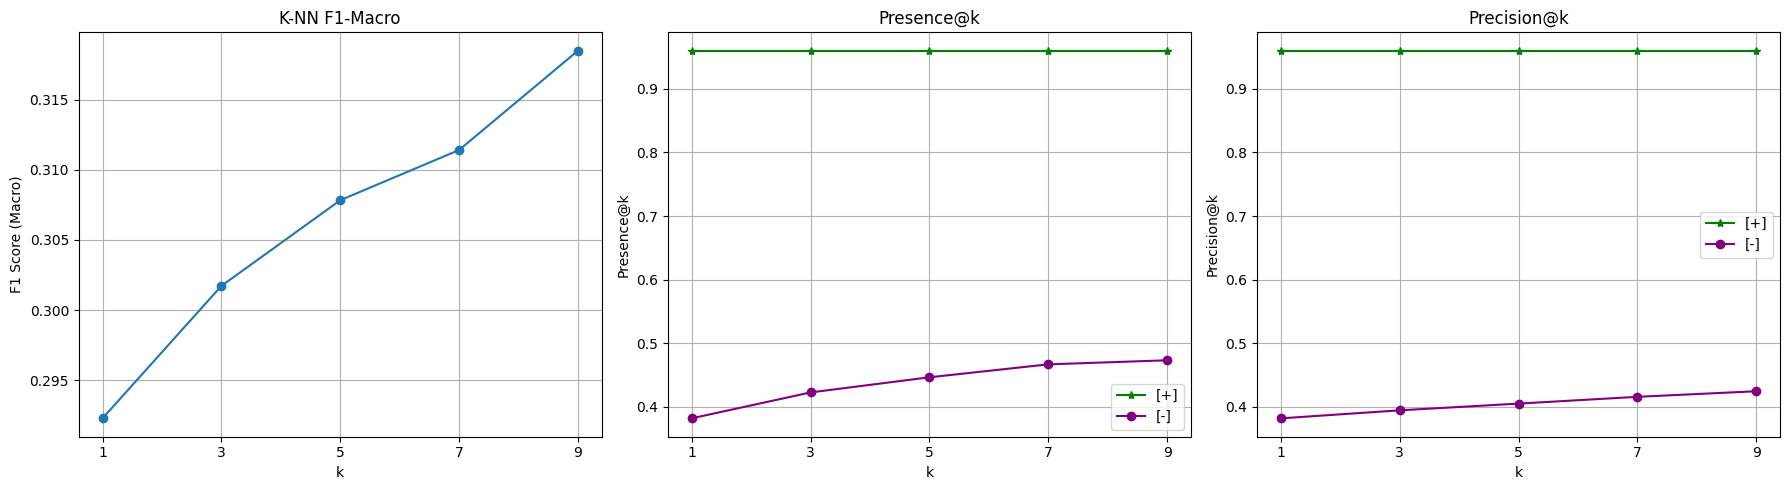

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LinearL,data,negative_distribution = "Uniform",theta = (1,0.33))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.2923
Confusion Matrix:
[[ 900 1456]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3820
Presence(-)@k: 0.3820

k=3
F1 Macro: 0.3017
Confusion Matrix:
[[ 941 1415]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3946
Presence(-)@k: 0.4228

k=5
F1 Macro: 0.3078
Confusion Matrix:
[[ 968 1388]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.4052
Presence(-)@k: 0.4465

k=7
F1 Macro: 0.3114
Confusion Matrix:
[[ 984 1372]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.4158
Presence(-)@k: 0.4669

k=9
F1 

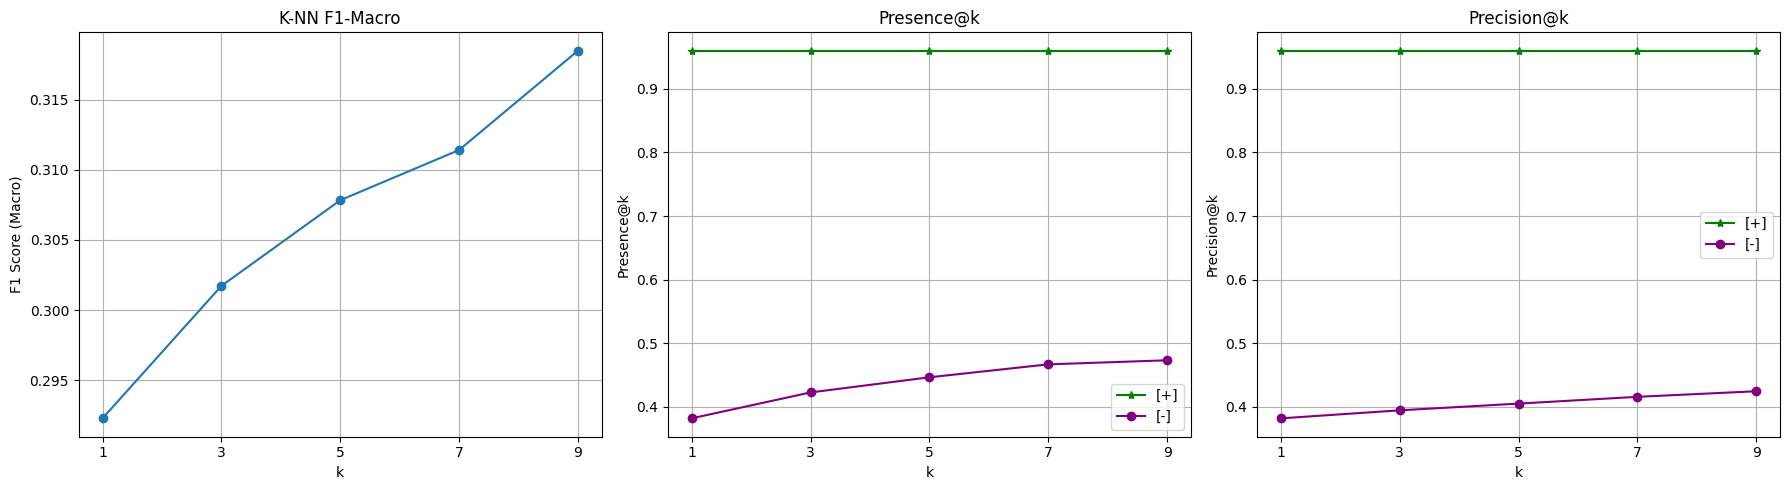

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LinearL,data,negative_distribution = "Uniform",theta = (1,0.33),K_0 = 2*20)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LinearL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.2652
Confusion Matrix:
[[ 787 1569]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3340
Presence(-)@k: 0.3340

k=3
F1 Macro: 0.2805
Confusion Matrix:
[[ 850 1506]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3530
Presence(-)@k: 0.3756

k=5
F1 Macro: 0.2843
Confusion Matrix:
[[ 866 1490]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3595
Presence(-)@k: 0.3875

k=7
F1 Macro: 0.2876
Confusion Matrix:
[[ 880 1476]
 [   1   24]]
Precision(+)@k: 0.9600
Presence(+)@k: 0.9600
Precision(-)@k: 0.3652
Presence(-)@k: 0.3952

k=9
F1 Macro: 0.2890
Confusion Matrix:
[[ 886 

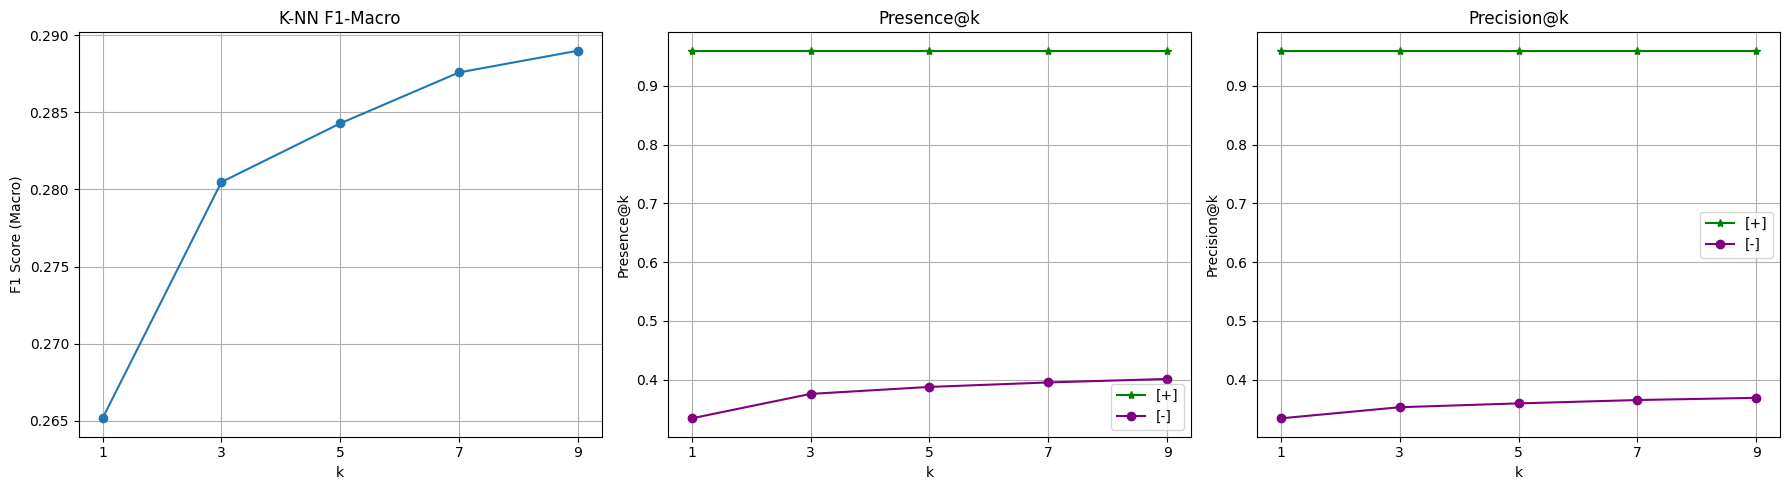

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LinearL,data)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.1060
Confusion Matrix:
[[ 250 2106]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.1061
Presence(-)@k: 0.1061

k=3
F1 Macro: 0.1078
Confusion Matrix:
[[ 255 2101]
 [   3   22]]
Precision(+)@k: 0.8667
Presence(+)@k: 0.9200
Precision(-)@k: 0.1070
Presence(-)@k: 0.1104

k=5
F1 Macro: 0.1069
Confusion Matrix:
[[ 254 2102]
 [   4   21]]
Precision(+)@k: 0.8320
Presence(+)@k: 0.9200
Precision(-)@k: 0.1058
Presence(-)@k: 0.1116

k=7
F1 Macro: 0.1076
Confusion Matrix:
[[ 256 2100]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 1.0000
Precision(-)@k: 0.1059
Presence(-)@k: 0.1121

k=9
F1 Mac

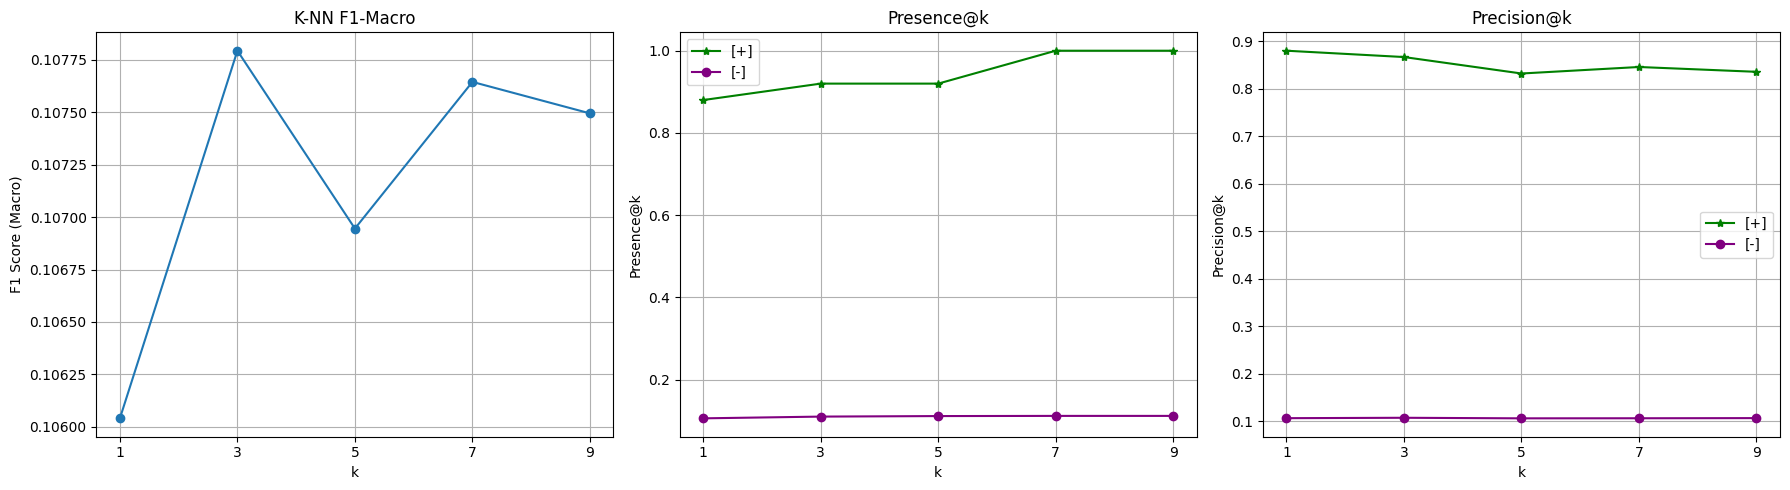

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LogL,data,negative_distribution = "Uniform")


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.1067
Confusion Matrix:
[[ 252 2104]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.1070
Presence(-)@k: 0.1070

k=3
F1 Macro: 0.1085
Confusion Matrix:
[[ 257 2099]
 [   3   22]]
Precision(+)@k: 0.8667
Presence(+)@k: 0.9200
Precision(-)@k: 0.1080
Presence(-)@k: 0.1112

k=5
F1 Macro: 0.1080
Confusion Matrix:
[[ 257 2099]
 [   4   21]]
Precision(+)@k: 0.8320
Presence(+)@k: 0.9200
Precision(-)@k: 0.1068
Presence(-)@k: 0.1125

k=7
F1 Macro: 0.1083
Confusion Matrix:
[[ 258 2098]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 1.0000
Precision(-)@k: 0.1067
Presence(-)@k: 0.1125

k=9
F1 Mac

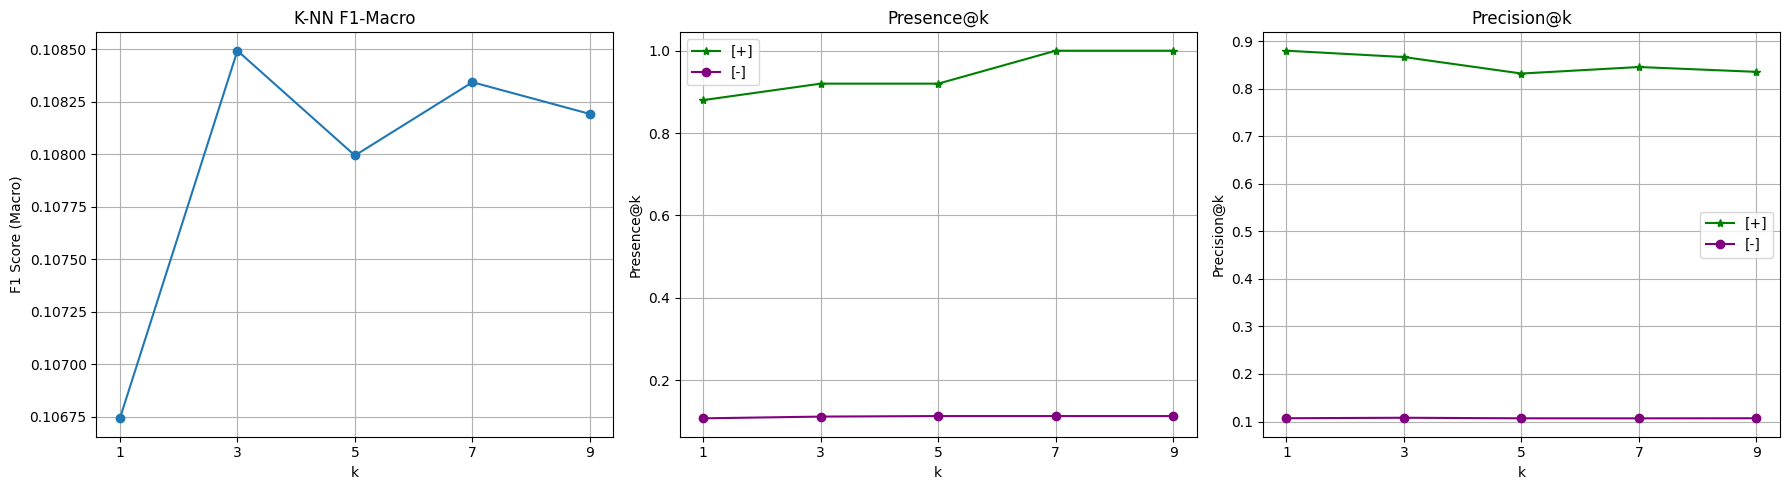

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LogL,data,negative_distribution = "Uniform",theta = (1,0.33))


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Uniform: coverage_range = 0.95
    Bounds: 
  lower = [-7.037 -4.644]
  upper = [8.435 4.006]

[INFO] Done!

k=1
F1 Macro: 0.1067
Confusion Matrix:
[[ 252 2104]
 [   3   22]]
Precision(+)@k: 0.8800
Presence(+)@k: 0.8800
Precision(-)@k: 0.1070
Presence(-)@k: 0.1070

k=3
F1 Macro: 0.1085
Confusion Matrix:
[[ 257 2099]
 [   3   22]]
Precision(+)@k: 0.8667
Presence(+)@k: 0.9200
Precision(-)@k: 0.1080
Presence(-)@k: 0.1112

k=5
F1 Macro: 0.1080
Confusion Matrix:
[[ 257 2099]
 [   4   21]]
Precision(+)@k: 0.8320
Presence(+)@k: 0.9200
Precision(-)@k: 0.1068
Presence(-)@k: 0.1125

k=7
F1 Macro: 0.1083
Confusion Matrix:
[[ 258 2098]
 [   4   21]]
Precision(+)@k: 0.8457
Presence(+)@k: 1.0000
Precision(-)@k: 0.1067
Presence(-)@k: 0.1125

k=9
F1 Mac

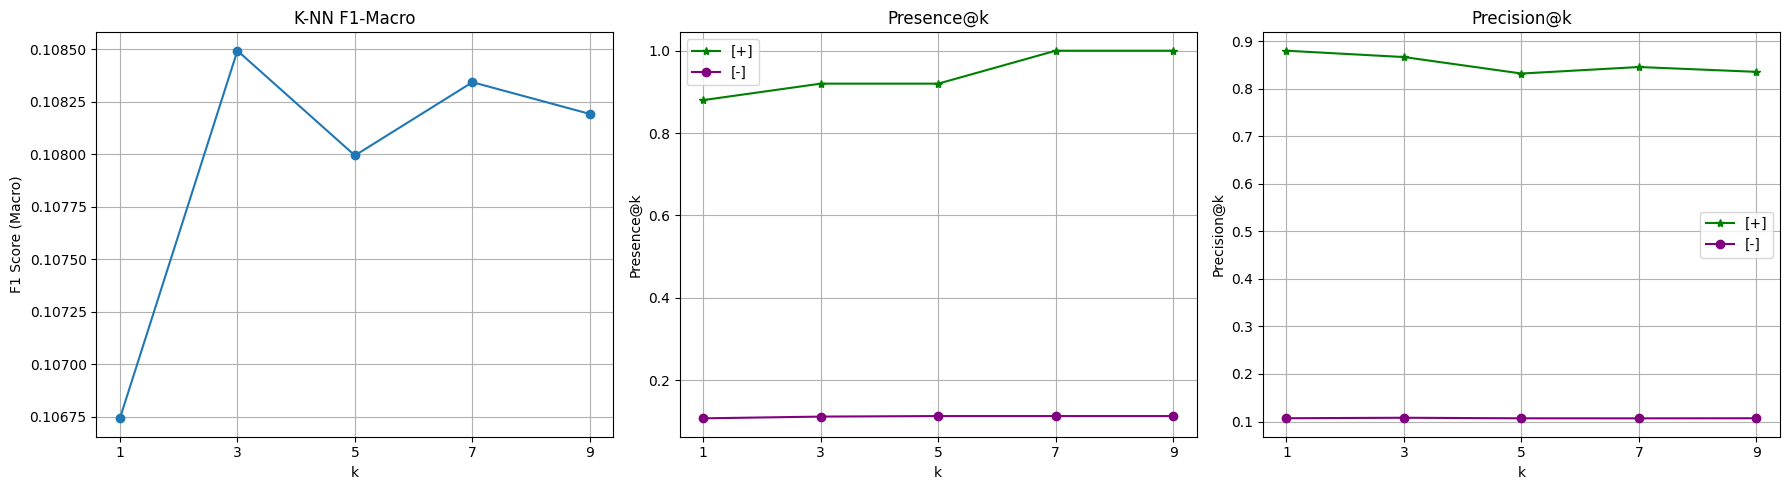

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LogL,data,negative_distribution = "Uniform",theta = (1,0.33),K_0 = 2*20)


[INFO] Loading embedding model: bert-base-nli-mean-tokens
[INFO] Computing embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO] Applying PCA (n_components=2)...
[INFO] Setting up FAISS indexes...

======= PosBoostSplit_LinearG_LogL Summary =======
Total: 9523, #(+) = 101, #(-) = 9422

 Generative Assumptions:
[+] Gaussian:
  mu: [-5.229  0.776]
  sigma: [2.912 1.895]
[-] Gaussian:
  mu: [ 0.056 -0.008]
  sigma: [4.164 2.261]

[INFO] Done!

k=1
F1 Macro: 0.0108
Confusion Matrix:
[[   1 2355]
 [   0   25]]
Precision(+)@k: 1.0000
Presence(+)@k: 1.0000
Precision(-)@k: 0.0004
Presence(-)@k: 0.0004

k=3
F1 Macro: 0.0108
Confusion Matrix:
[[   1 2355]
 [   0   25]]
Precision(+)@k: 1.0000
Presence(+)@k: 1.0000
Precision(-)@k: 0.0003
Presence(-)@k: 0.0004

k=5
F1 Macro: 0.0104
Confusion Matrix:
[[   0 2356]
 [   0   25]]
Precision(+)@k: 1.0000
Presence(+)@k: 1.0000
Precision(-)@k: 0.0005
Presence(-)@k: 0.0013

k=7
F1 Macro: 0.0112
Confusion Matrix:
[[   2 2354]
 [   0   25]]
Precision(+)@k: 1.0000
Presence(+)@k: 1.0000
Precision(-)@k: 0.0007
Presence(-)@k: 0.0017

k=9
F1 Macro: 0.0112
Confusion Matrix:
[[   2 235

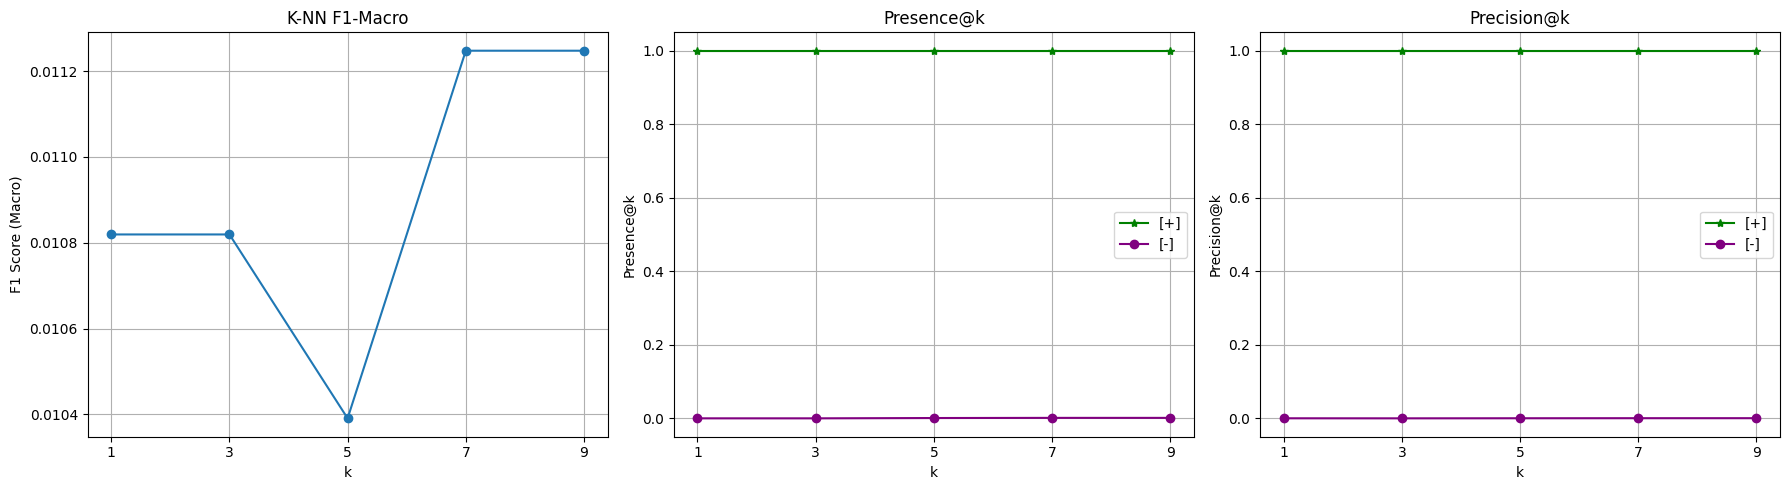

In [ ]:
evaluate_retrieval_system(PosBoostSplit_LinearG_LogL,data)